In [544]:
# Authors: 
# Elton Pan, Antonio del Rio Chanona

import pylab
import pandas as pd
import scipy.integrate as scp
import numpy as np
import seaborn as sns
from pylab import *
import csv
import os
import sys
import copy
import torch
from sklearn.preprocessing import StandardScaler
import collections
import numpy.random as rnd
from scipy.spatial.distance import cdist
import sobol_seq
from scipy.optimize import minimize
eps  = np.finfo(float).eps
import random
import time
import pickle
import imageio
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "Helvetica"
matplotlib.rcParams['font.size'] = 20
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from IPython.display import Audio # Import sound alert dependencies
from IPython import display # For live plots
from mpl_toolkits import mplot3d
from ipywidgets import interact
from __future__ import print_function
import sys
import threading
import json
from time import sleep
try:
    import thread
except ImportError:
    import _thread as thread
    
def quit_function(fn_name):
    # print to stderr, unbuffered in Python 2.
    print('@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@{0} TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@'.format(fn_name), file=sys.stderr)
    sys.stderr.flush() # Python 3 stderr is likely buffered.
    thread.interrupt_main() # raises KeyboardInterrupt
def exit_after(s):
    '''
    use as decorator to exit process if 
    function takes longer than s seconds
    '''
    def outer(fn):
        def inner(*args, **kwargs):
            timer = threading.Timer(s, quit_function, args=[fn.__name__])
            timer.start()
            try:
                result = fn(*args, **kwargs)
            finally:
                timer.cancel()
            return result
        return inner
    return outer

def Done():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

############ Defining Environment ##############
class Model_env: 
    
    # --- initializing model --- #
    def __init__(self, parameters, tf):
        
        # Object variable definitions
        self.parameters       = parameters
        self.tf = tf  
        
    # --- dynamic model definition --- #    
    # model takes state and action of previous time step and integrates -- definition of ODE system at time, t
    def model(self, t, state):
        # internal definitions
        params = self.parameters
        u_F  = self.u0[0] # Control for flow rate of reactant A
        u_T = self.u0[1]  # Control for temperature of cooling jacket
                
        # state vector
        CA  = state[0]
        CB  = state[1]
        CC  = state[2]
        T   = state[3]
        Vol = state[4]
        
        # parameters # Updated with new params
        CpA = params['CpA']; CpB = params['CpB'];
        CpC = params['CpC']; CpH2SO4 = params['CpH2SO4'];
        T0 = params['T0']; HRA = params['HRA'];
        HRB = params['HRB']; E1A = params['E1A'];
        E2A = params['E2A']; A1 = params['A1'];
        Tr1 = params['Tr1']; Tr2 = params['Tr2'];
        CA0 = params['CA0']; A2 = params['A2'];
        UA = params['UA']; N0H2S04 = params['N0H2S04'];

        # algebraic equations
        r1 = A1*exp(E1A*(1./Tr1-1./T))
        r2 = A2*exp(E2A*(1./Tr2-1./T))
        
        # variable rate equations
        dCA   = -r1*CA + (CA0-CA)*(u_F/Vol)
        dCB   =  r1*CA/2 - r2*CB - CB*(u_F/Vol)
        dCC   =  3*r2*CB - CC*(u_F/Vol)
        dT    =  (UA*10.**4*(u_T-T) - CA0*u_F*CpA*(T-T0) + (HRA*(-r1*CA)+HRB*(-r2*CB\
                    ))*Vol)/((CA*CpA+CpB*CB+CpC*CC)*Vol + N0H2S04*CpH2SO4)
        dVol  =  u_F

        return np.array([dCA, dCB, dCC, dT, dVol],dtype='float64') # Added Cq

    def simulation(self, x0, controls):
        # internal definitions
        model, tf     = self.model, self.tf
        self.controls = controls
        
        # initialize simulation
        current_state = x0
        
        # simulation #ONLY ONE STEP unlike the previous code shown above
        self.u0   = controls
        ode       = scp.ode(model)                      # define ode
        ode.set_integrator('lsoda', nsteps=3000)        # define integrator
        ode.set_initial_value(current_state, tf)         # set initial value
        current_state = list(ode.integrate(ode.t + tf)) # integrate system
        xt            = current_state                   # add current state Note: here we can add randomnes as: + RandomNormal noise
        
        return xt

    def MDP_simulation(self, x0, controls): #simulate ONLY ONE STEP
        xt          = self.simulation(x0, controls) #simulate
####         xt_discrete = self.discrete_env(xt) # make output state discrete
####         return xt_discrete
        return xt #remove this if you want to discretize

    # def reward(self, state):
    #     reward = 100*state[-1][0] - state[-1][1]              # objective function 1
    #     return reward

# Constants
p    =      {'CpA'    : 30.,
             'CpB'    : 60.,
             'CpC'    : 20.,
             'CpH2SO4': 35.,
             'T0'     : 305.,
             'HRA'    : -6500.,
             'HRB'    : 8000.,
             'E1A'    : 9500./1.987,
             'E2A'    : 7000./1.987,
             'A1'     : 1.25,
             'Tr1'    : 420.,
             'Tr2'    : 400.,
             'CA0'    : 4.,
             'A2'     : 0.08,
             'UA'     : 4.5,
             'N0H2S04': 100.}

tf  = 4./10. # assuming 10 steps, we divide the whole horizon (4 h) over 10 for one step

# Creating the model
MDP_CDC = Model_env(p, tf)

def transition(old_state, action):
    '''Gives the new state given the current state and action
       Arguments
       old state : [CA, CB, CC, T, Vol, t] 
       action    : [u_F, u_T]
    
       Output 
       new state : [CA, CB, CC, T, Vol, t] 
       reward    : [CC_Terminal]
       '''
    # If terminal state is reached (episode in final step)
    if abs(old_state[5] - 4.) < 0.01:
        reward    = copy.deepcopy(old_state[2]*old_state[4]) # Reward at terminal is CC*Vol
        new_state = MDP_CDC.MDP_simulation(old_state[:-1], action)  # Take action and evolve using model
        new_state.append(old_state[-1] + tf)                           # Increment time by tf (0.4 h)
    
    # Else if past terminal state (episode has ended)
    elif (old_state[5] > 4.):
        reward    = 0         # Zero reward given
        new_state = old_state # Loop back to itself (no evolution)
    
    # Else non-terminal state (episode has not ended)
    else:
        reward    = 0         # Zero reward given
        new_state = MDP_CDC.MDP_simulation(old_state[:-1], action) # Take action and evolve using model
        new_state.append(old_state[-1] + tf)                          # Increment time by tf (0.4 h)

    return new_state, reward

def generate_random_episode(initial_state): 
    '''Generates an episode [
                             [ [CA, CB, CC, T, Vol, t], [u_F, u_T], reward ]
                             ...
                             ...
                             ]
    with random policy with
    an initial state
    '''
    # Initial state
    state  = initial_state # initial state
    episode = []
    
    # Simulate 11 steps (not 10 because we want to exit the terminal step)
    for step in range(11):
        old_state = state                  # Save old state
        u_F  = np.random.uniform(0, 250)      # Pick random u_F
        u_T  = np.random.uniform(270, 500)    # Pick random u_T
        action = [u_F, u_T]
        
        state, reward = transition(state, action)
        episode       += [[old_state, action, reward]]
    return episode
# generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0]) # Test generate_random_episode

def extract_data_from_episode(episode, discount_factor = 0.9):
    '''
    Argument: An episode generated using the generate_random_episode() function
    
    Output: 11 Datapoints in the form of [[CA, CB, CC, T, Vol, t, u_F, u_T], Q] for training 
            the Q-network
    '''
    Q_data = []
    for step in reversed(range(11)): # Each episode has 11 entries, and Q table is updated in reversed order
        state, action, reward = episode[step] 

        if step == 10: # If terminal state i.e. t = 4.0
            G = reward # Return = reward at terminal state
        else:
            G = reward + discount_factor * G  # Return = reward + discounted return of the PREVIOUS state
        
        u_F, u_T = action      #  Unpack controls
        state.append(u_F)      # Append u_F
        state.append(u_T)      # Append u_T
        data_point = [state, G] # Construct datapoint where state is index 0, and return is index 1
        Q_data += [data_point]
    return Q_data
# episode = generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0])
# extract_data_from_episode(episode, discount_factor = 0.9) # Test function

def standardize_state_Q(state): # For Q-network
    '''Argument: Un-standardized [CA, CB, CC, T, Vol, t, u_F, u_T]
    Output: Standardized [CA, CB, CC, T, Vol, t, u_F, u_T] using previously determined mean and std values''' 
    for feature in range(len(x_mean_Q)): 
        state[feature] = (state[feature] - x_mean_Q[feature])/x_std_Q[feature]
    return state

def unstandardize_state_Q(state): # For Q-network
    '''Argument: Standardized [CA, CB, CC, T, Vol, t, u_F, u_T]
    Output: Un-standardized [CA, CB, CC, T, Vol, t, u_F, u_T] using previously determined mean and std values''' 
    for feature in range(len(x_mean_Q)): 
        state[feature] = (state[feature] * x_std_Q[feature]) + x_mean_Q[feature]
    return state

def standardize_state_C(state): # For C-network
    '''Argument: Un-standardized [CA, CB, CC, T, Vol, t_f - t, u_F, u_T]
    Output: Standardized [CA, CB, CC, T, Vol, t_f - t, u_F, u_T] using previously determined mean and std values''' 
    for feature in range(len(x_mean_C)): 
        state[feature] = (state[feature] - x_mean_C[feature])/x_std_C[feature]
    return state

def unstandardize_state_C(state): # For C-network
    '''Argument: Standardized [CA, CB, CC, T, Vol, t_f - t, u_F, u_T]
    Output: Un-standardized [CA, CB, CC, T, Vol, t_f - t, u_F, u_T] using previously determined mean and std values''' 
    for feature in range(len(x_mean_C)): 
        state[feature] = (state[feature] * x_std_C[feature]) + x_mean_C[feature]
    return state

def take_random_action(epsilon): # Epsilon represents the probability of taking a random action
    if np.random.uniform(0,1) < epsilon:
        return True
    else:
        return False

def max_action(state):
    '''Argument: State   [CA, CB, CC, T, Vol, t]
       Output  : Control [u_F, u_T] that maximizes Q_value using stochastic optimization'''
    
    # ROUND ONE: Get a ROUGH estimate of max action
    action_distribution = []
    for i in range(500): # Take 500 actions
        u_F  = np.random.uniform(0, 250)   # Pick random u_F
        u_T  = np.random.uniform(270, 500) # Pick random u_T
        action_distribution += [[u_F, u_T]]

    inputs = []
    for a in action_distribution:
        s = state.copy()
        s.append(a[0]) # Append u_L
        s.append(a[1]) # Append u_Fn
        s = standardize_state_Q(s) # Standardize the input using function defined
        inputs += [s]
    inputs          = torch.tensor(inputs)
    index_of_highest_Q = np.argmax(Q_net(inputs).detach().numpy()) 

    # Unstandardize controls
    max_u_F  = (inputs[index_of_highest_Q][6] * x_std_Q[6]).item() + x_mean_Q[6]
    max_u_T = (inputs[index_of_highest_Q][7] * x_std_Q[7]).item() + x_mean_Q[7]
    max_control = [max_u_F, max_u_T]

    return max_control

@exit_after(5)
def score_NN_policy(NN, initial_state, num_iterations = 10, get_control = False, g1_threshold = None, g2_threshold = None):
    total_score = 0
    sum_of_policies = []
    if g1_threshold == None: # If no threshold is given (non constrained NN)
        for j in range(num_iterations): 
            state     = initial_state.copy() # Initial state
            CA_data   = [state[0]] # Store initial data
            CB_data   = [state[1]]
            CC_data   = [state[2]]
            T_data    = [state[3]]
            Vol_data  = [state[4]]
            t_data    = [state[5]]
            my_policy = []
            for i in range(10): #take ten steps
                action     = NN(state) # Predict action using NN
                state      = transition(state, action)[0]
                my_policy += [action]
                CA_data   += [state[0]] # Store initial data
                CB_data   += [state[1]]
                CC_data   += [state[2]]
                T_data    += [state[3]]
                Vol_data  += [state[4]]
                t_data    += [state[5]]
            sum_of_policies += [my_policy] # Create list of lists
            score            = CC_data[10]*Vol_data[10]
            total_score     += score
    elif g1_threshold != None: # If threshold given (NN with constrained)
        for j in range(num_iterations): 
            state     = initial_state.copy() # Initial state
            CA_data   = [state[0]] # Store initial data
            CB_data   = [state[1]]
            CC_data   = [state[2]]
            T_data    = [state[3]]
            Vol_data  = [state[4]]
            t_data    = [state[5]]
            my_policy = []
            for i in range(10): #take ten steps
                state_for_NN = state.copy()
                action     = NN(state_for_NN, g1_threshold = g1_threshold, g2_threshold = g2_threshold) # Predict action using NN
                state      = transition(state, action)[0]
                my_policy += [action]
                CA_data   += [state[0]] # Store initial data
                CB_data   += [state[1]]
                CC_data   += [state[2]]
                T_data    += [state[3]]
                Vol_data  += [state[4]]
                t_data    += [state[5]]
            sum_of_policies += [my_policy] # Create list of lists
            score            = CC_data[10]*Vol_data[10]
            total_score     += score
    if get_control == True:
        return total_score/num_iterations, np.array(sum_of_policies)
    else:
        return total_score/num_iterations
# score_NN_policy(max_action, [1.0, 150.0, 0, 0], num_iterations = 10)

@exit_after(3)
def generate_episode_with_NN(NN, initial_state, epsilon, g1_threshold = None, g2_threshold = None): 
    '''Generates an episode with the chosen action of each step having:
    Probability of epsilon       ---> random action
    Probability of (1 - epsilon) ---> greedy action (according to neural network)
    '''
    episode = []
    state = initial_state # Initial state
    
    if g1_threshold == None: # IF CONSTRAINTS ARE SWITCHED OFF
        for i in range(11): #take (10 + 1) steps
#             old_state = state # Old state for storing into episode
            old_state = copy.deepcopy(state)
    
            if take_random_action(epsilon): # Take random action
                u_F  = np.random.uniform(0, 250)   # Pick random u_L
                u_T = np.random.uniform(270, 500)  # Pick random u_Fn
                action = [u_F, u_T]

            else:                           # Else take greedy action
                action = list(NN(old_state))

            state, reward  = transition(state, action)     # Evolve to get new state 
            episode       += [[old_state, action, reward]] # Update step
    
    elif g1_threshold != None: # IF CONSTRAINTS ARE SWITCHED ON
        for i in range(11): #take (10 + 1) steps
#             print('state at the start of each step:', state)
#             old_state_copy = copy.deepcopy(state)  # THIS IS IMPORTANT BCOS THE NN BELOW SOMEHOW DISTORTS OLD_STATE
            if take_random_action(epsilon): # Take random action
                u_F = np.random.uniform(0, 250)   # Pick random u_L
                u_T = np.random.uniform(270, 500)  # Pick random u_Fn
                action = [u_F, u_T]
            else:                           # Else take greedy action
                if i == 10: # If transition out of the terminal state, pick any action
                    action = action
#                     print('13th transition')
                else:
                    state_for_NN = copy.copy(state)
                    action = list(NN(state_for_NN, g1_threshold = g1_threshold, g2_threshold = g2_threshold)) # APPLY THRESHOLD
            old_state = state.copy() 
            state, reward  = transition(state, action)     # Evolve to get new state
            episode       += [[old_state, action, reward]] # Update step
    return episode
# generate_episode_with_NN(max_action, [1.0, 150.0, 0, 0], epsilon = 0.1)

def update_replay_buffer(replay_buffer, episode, discount_factor = 0.9):
    '''Argument: replay buffer (a collections.deque object) and ONE episode
    Output: Adds standardized datapoints [[Cx, Cn, Cq, t, u_L, u_Fn], Q] for training NN into replay buffer
    '''
    data = extract_data_from_episode(episode, discount_factor = discount_factor) # Extract data points from episode
    for data_point in data:
        X, y = data_point # Unpack datapoint
        X = standardize_state_Q(X) # Standardize X
        y = ((y - y_mean_Q)/y_std_Q)[0] # Standardize y
        data_point = [X, y] # Repack datapoint
        replay_buffer.extend([data_point]) # Add to replay buffer
    
    return replay_buffer
# replay_buffer = collections.deque(maxlen = 3000) # Max capacity of 3000
# episode = generate_episode_with_NN(max_action, [1.0, 150.0, 0, 0], epsilon = 0.1)
# update_replay_buffer(replay_buffer, episode)

def plot_episode(episode):
    '''Plots an episode and corresponding score'''
    CA_list  = []
    CB_list  = []
    CC_list  = []
    T_list   = []
    Vol_list = []
    t_list   = []
    u_F_list = []
    u_T_list = []
    reward_list = []
    t = 0
    for step in episode:
        [CA, CB, CC, T, Vol, t], [u_F, u_T], reward = step
        CA_list  += [CA]
        CB_list  += [CB]
        CC_list  += [CC]
        T_list   += [T]
        Vol_list += [Vol]
        t_list   += [t]
        u_F_list += [u_F]
        u_T_list += [u_T]
        reward_list += [reward]
        t += tf
    
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
#     fig, ax = plt.figure(figsize=(10,10))
    
    plt.subplot(3,3,1)
    plt.plot(t_list, CA_list, label = 'A trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,2)
    plt.plot(t_list, CB_list, label = 'B trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,3)
    plt.plot(t_list, CC_list, label = 'C trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,4)
    plt.plot(t_list, T_list, label = 'T trajectory \nMax T = %.1f' % max(T_list), color = 'b')
    plt.plot(t_list, [420]*len(t_list), color = 'black')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,5)
    plt.plot(t_list, Vol_list, label = 'Vol trajectory \nMax Vol = %.1f' % max(Vol_list), color = 'b')
    plt.plot(t_list, [800]*len(t_list), color = 'black')
    plt.legend(fontsize = 15)
    
    plt.subplot(3,3,6)
    plt.step(t_list, u_F_list, label = 'u_F trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    plt.subplot(3,3,7)
    plt.step(t_list, u_T_list, label = 'u_T trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    fig.tight_layout()
    fig.delaxes(ax[2][1]) # delete last 8th plot (empty)
    fig.delaxes(ax[2][2]) # delete last 9th plot (empty)
    plt.show()
    print('Score:', CC_list[-1]*Vol_list[-1])
# episode = generate_episode_with_NN(NN = max_action, initial_state = [1.0, 150.0, 0, 0], epsilon = 0)
# plot_episode(episode)

def extract_constraint_values_from_episode(episode, T_limit = 420, Vol_limit = 800):
    '''Arguments : 1 episode and N_limit
       Output    : Index 0 gives input data in terms of [CA, CB, CC, T, Vol, t-t_f, u_F, u_T]
                   Index 1 gives target constraint values'''

    state_action = [] # Initialize inputs
    g1_target   = [] # Initialize target value (constraints)
    g2_target   = [] # Initialize target value (constraints)
    targets = [] # Initialize target values [[g1, g2 g3], ...]
    
    num_transitions = 10
    for i in range(num_transitions): # Index 0 to 9 instead of 10 because we consider the 1st 10 transitions
        step             = episode[i]       # Choose a specific step
        new_step         = episode[i+1]     # and the corresponding subsequent step
        
        state, action, _ = step             # Unpack state & action
        state            = list(state)
        state[5]         = 4. - state[5]   # IMPORTANT: Modify t to (t_f - t)
        state           += action           # Append u_F and u_T
        
        # INPUT for training
        state_action += [state]
        
        new_state, _, _  = new_step         # Unpack subsequent state
        T                = new_state[3]     # T of SUBSEQUENT step (for g1)
        Vol              = new_state[4]     # Vol of SUBSEQUENT step (for g2)

        # TARGETS for path constraint 1 (g1) where T - 420 =< 0
        g1           = T - T_limit # Calculate constraint value (+ve for exceeding limit)
        g1_target   += [[g1]]      # TARGET OUTPUT (IMPORTANT TO USE A NESTED LIST hence the DOUBLE square brackets)

        # TARGETS for path constraint 2 (g2) where Vol - 800 =< 0
        g2           = Vol - Vol_limit # Calculate constraint value (+ve for exceeding limit)
        g2_target   += [[g2]]      # TARGET OUTPUT (IMPORTANT TO USE A NESTED LIST hence the DOUBLE square brackets)
        
    
    # Update constraints using "Crystal Ball/Oracle": Highest/Worst constraint value from current and future steps
    for j in range(num_transitions - 1): # Index of constraint value to be checked (9 instead of 10 bcos the 10th value is terminal and has no future)
        for k in range(num_transitions-j): # Number of steps into the future
            # ====Oracle for g1====
            if g1_target[j] < g1_target[j+k]: # If future g1 value is LARGER than current value
                g1_target[j] = g1_target[j+k]  # Replace current value with future value

            if g2_target[j] < g2_target[j+k]: # If future g2 value is LARGER than current value
                g2_target[j] = g2_target[j+k]  # Replace current value with future value
            
    
#     for m in range(num_transitions): # Pack into a nested list
#         g1 = g1_target[m]
#         g2 = g2_target[m]
#         g3 = g3_target[m]
#         targets += [[g1]] # g1 only - NEEDS TO BE NESTED LIST
#         targets += [[g1, g2]] # g1 and g2 only - NEEDS TO BE NESTED LIST
#         targets += [[g1, g2, g3]] # g1, g2 and g3 - NEEDS TO BE NESTED LIST
        
#     print('g1:', g1_target)
#     print('')
#     print('g2:', g2_target)
#     print('')
#     print('g3:', g3_target)  
    return state_action, g1_target, g2_target
# episode = generate_random_episode(initial_state = [1.0,150.0,0,0]) 
# extract_constraint_values_from_episode(episode)

def extract_constraint_values_from_episode_NO_ORACLE(episode, T_limit = 420, Vol_limit = 800):
    '''Arguments : 1 episode and N_limit
       Output    : Index 0 gives input data in terms of [CA, CB, CC, T, Vol, t-t_f, u_F, u_T]
                   Index 1 gives target constraint values'''

    state_action = [] # Initialize inputs
    g1_target   = [] # Initialize target value (constraints)
    g2_target   = [] # Initialize target value (constraints)
    targets = [] # Initialize target values [[g1, g2 g3], ...]
    
    num_transitions = 10
    for i in range(num_transitions+1): # Index 0 to 10 because we consider the 1st 10 transitions
        step             = episode[i]       # Choose a specific step
        
        state, _, _ = step             # Unpack state & action
        
        T                = state[3]     # T of SUBSEQUENT step (for g1)
        Vol              = state[4]     # Vol of SUBSEQUENT step (for g2)

        # TARGETS for path constraint 1 (g1) where T - 420 =< 0
        g1           = T - T_limit # Calculate constraint value (+ve for exceeding limit)
        g1_target   += [[g1]]      # TARGET OUTPUT (IMPORTANT TO USE A NESTED LIST hence the DOUBLE square brackets)

        # TARGETS for path constraint 2 (g2) where Vol - 800 =< 0
        g2           = Vol - Vol_limit # Calculate constraint value (+ve for exceeding limit)
        g2_target   += [[g2]]      # TARGET OUTPUT (IMPORTANT TO USE A NESTED LIST hence the DOUBLE square

    return state_action, g1_target, g2_target

def update_g1_buffer(g1_buffer, episode):
    '''Argument: g1 buffer (a collections.deque object) and ONE episode
    Output: Adds standardized datapoints [[CA, CB, CC, T, Vol, t-t_f, u_F, u_T], g1] for training g1_net into replay buffer
    '''
    state_action, g1_constraint, g2_constraint = extract_constraint_values_from_episode(episode) # Extract data points from episode
#     print('state_action:', state_action)

#     print('constraint:', constraint)
    for idx in range(len(state_action)):
        state_action[idx] = standardize_state_C(state_action[idx])
        g1_constraint[idx] = (np.array(g1_constraint[idx]) - y_mean_C[0])/y_std_C[0]
        data_point = [list(state_action[idx]), g1_constraint[idx].item()] # Repack datapoint
        g1_buffer.extend([data_point]) # Add to replay buffer
    
    return g1_buffer

def update_g2_buffer(g2_buffer, episode):
    '''Argument: g2 buffer (a collections.deque object) and ONE episode
    Output: Adds standardized datapoints [[CA, CB, CC, T, Vol, t-t_f, u_F, u_T], g2] for training g1_net into replay buffer
    '''
    state_action, g1_constraint, g2_constraint = extract_constraint_values_from_episode(episode) # Extract data points from episode
#     print('state_action:', state_action)

#     print('constraint:', constraint)
    for idx in range(len(state_action)):
        state_action[idx] = standardize_state_C(state_action[idx])
        g2_constraint[idx] = (np.array(g2_constraint[idx]) - y_mean_C[1])/y_std_C[1]
        data_point = [list(state_action[idx]), g2_constraint[idx].item()] # Repack datapoint
        g2_buffer.extend([data_point]) # Add to replay buffer
    
    return g2_buffer

def anneal_NN():
    '''Retrains to the neural networks (Q-net and constraint nets) to anneal the policy to
    solve the problem of frozen algorithm'''
    # TRAIN Q-NET
    combined_inputs_Q = []
    combined_targets_Q = []
    samples_Q          = random.sample(replay_buffer, 100) # Draw random samples from replay buffer
    for inputs, target in samples_Q:
        if len(inputs) == 8: # To fix the changing len problem
            combined_inputs_Q  += [inputs]
            combined_targets_Q += [[target]]
    combined_inputs_Q  = torch.tensor(combined_inputs_Q).double()  # Convert list to tensor
    combined_targets_Q = torch.tensor(combined_targets_Q).double() # Convert list to tensor
    Q_optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    for epoch in range(20):
        prediction = Q_net(combined_inputs_Q)                    # Input x and predict based on x
        Q_loss     = loss_func(prediction, combined_targets_Q) # Must be (1. nn output, 2. target)
        Q_optimizer.zero_grad()   # Clear gradients for next train
        Q_loss.backward()         # Backpropagation, compute gradients
        Q_optimizer.step() 

    # TRAIN G1-NET
    combined_inputs_g1  = [] # List of lists to be converted into input tensor
    combined_targets_g1 = []
    samples_g1          = random.sample(g1_buffer, 1000) # Draw random samples from replay buffer
    for inputs, target in samples_g1:
        if len(inputs) == 8: # To fix the changing len problem
            combined_inputs_g1  += [inputs]
            combined_targets_g1 += [[target]]
    combined_inputs_g1  = torch.tensor(combined_inputs_g1).double()  # Convert list to tensor
    combined_targets_g1 = torch.tensor(combined_targets_g1).double()
    g1_optimizer = torch.optim.Adam(g1_net.parameters(), lr=5e-4) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    for epoch in range(250):
        prediction = g1_net(combined_inputs_g1)                    # Input x and predict based on x
        g1_loss    = loss_func(prediction, combined_targets_g1) # Must be (1. nn output, 2. target)
        g1_optimizer.zero_grad()   # Clear gradients for next train
        g1_loss.backward()         # Backpropagation, compute gradients
        g1_optimizer.step()        # Apply gradients

    # TRAIN G2-NET
    combined_inputs_g2  = [] # List of lists to be converted into input tensor
    combined_targets_g2 = []
    samples_g2          = random.sample(g2_buffer, 1000) # Draw random samples from replay buffer
    for inputs, target in samples_g2:
        if len(inputs) == 8: # To fix the changing len problem
            combined_inputs_g2  += [inputs]
            combined_targets_g2 += [[target]]
    combined_inputs_g2  = torch.tensor(combined_inputs_g2).double()  # Convert list to tensor
    combined_targets_g2 = torch.tensor(combined_targets_g2).double() # Convert list to tensor
    g2_optimizer = torch.optim.Adam(g2_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    for epoch in range(200):
        prediction = g2_net(combined_inputs_g2)                    # Input x and predict based on x
        g2_loss    = loss_func(prediction, combined_targets_g2) # Must be (1. nn output, 2. target)
        g2_optimizer.zero_grad()   # Clear gradients for next train
        g2_loss.backward()         # Backpropagation, compute gradients
        g2_optimizer.step()        # Apply gradients
    print('NEURAL NETWORKS ANNEALED')
    
def violate_g1(T):
    if T > 420:
        return True
    else:
        return False

def violate_g2(Vol):
    if Vol > 800:
        return True
    else:
        return False    

def plot_episode_pool(episode_pool):
    '''Plots an episode pool (n number of episodes) and corresponding score'''
    episodes_g1_violated = 0 # No. of episodes that violate g1
    episodes_g2_violated = 0 # No. of episodes that violate g1
    episodes_g1g2_both_violated = 0 # No. of episodes that violate both
    episodes_g1g2_only_one_violated = 0 # No. of episodes that violate either g1 and g2
    total_score = 0
    fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15,15))
    CA_pool  = []
    CB_pool  = []
    CC_pool  = []
    T_pool   = []
    Vol_pool = []
    u_F_pool = []
    u_T_pool = []
    
    for idx in range(len(episode_pool)): # Idx refers to nth episode in episode pool
        episode = episode_pool[idx]
        CA_list  = []
        CB_list  = []
        CC_list  = []
        T_list   = []
        Vol_list = []
        t_list   = []
        u_F_list = []
        u_T_list = []
        reward_list = []
        t = 0
        for step in episode:
            [CA, CB, CC, T, Vol, t], [u_F, u_T], reward = step
            CA_list  += [CA]
            CB_list  += [CB]
            CC_list  += [CC]
            T_list   += [T]
            Vol_list += [Vol]
            t_list   += [t]
            u_F_list += [u_F]
            u_T_list += [u_T]
            reward_list += [reward]
            t += tf
    #     fig, ax = plt.figure(figsize=(10,10))
        
        # Add scores to total score
        score        = CC_list[-1]*Vol_list[-1]
        total_score += score
        
        # Count number of EPISODES that have violation
        if True in map(violate_g1, T_list):
            episodes_g1_violated += 1
        if True in map(violate_g2, Vol_list):
            episodes_g2_violated += 1
        if (True in map(violate_g1, T_list)) and (True in map(violate_g2, Vol_list)):
            episodes_g1g2_both_violated += 1
        if (True in map(violate_g1, T_list)) or (True in map(violate_g2, Vol_list)):
            episodes_g1g2_only_one_violated += 1
        
        CA_pool  += [CA_list]
        CB_pool  += [CB_list]
        CC_pool  += [CC_list]
        T_pool   += [T_list]
        Vol_pool += [Vol_list]
        u_F_pool += [u_F_list]
        u_T_pool += [u_T_list]
        
        plt.subplot(3,3,1)
        plt.plot(t_list, CA_list, color = 'grey', alpha = 0.5)
        plt.legend(fontsize = 15)

        plt.subplot(3,3,2)
        plt.plot(t_list, CB_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,3)
        plt.plot(t_list, CC_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,4)
        plt.plot(t_list, T_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,5)
        plt.plot(t_list, Vol_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,6)
        plt.step(t_list, u_F_list, color = 'grey', alpha = 0.5)

        plt.subplot(3,3,7)
        plt.step(t_list, u_T_list, color = 'grey', alpha = 0.5)
    
    CA_pool  = np.array(CA_pool)
    CB_pool  = np.array(CB_pool)
    CC_pool  = np.array(CC_pool)
    T_pool   = np.array(T_pool)
    Vol_pool = np.array(Vol_pool)
    u_F_pool = np.array(u_F_pool)
    u_T_pool = np.array(u_T_pool)
    
    # Take mean of all columns (all time steps)
    CA_avg_list  = CA_pool.mean(axis=0)
    CB_avg_list  = CB_pool.mean(axis=0)
    CC_avg_list  = CC_pool.mean(axis=0)
    T_avg_list   = T_pool.mean(axis=0)
    Vol_avg_list = Vol_pool.mean(axis=0)
    u_F_avg_list = u_F_pool.mean(axis=0)
    u_T_avg_list = u_T_pool.mean(axis=0)
    
    # Find +/- one STD of all columns
    T_std_upper = np.percentile(T_pool, 84, axis = 0)
    T_std_lower = np.percentile(T_pool, 16, axis = 0)
    
    Vol_std_upper = np.percentile(Vol_pool, 84, axis = 0)
    Vol_std_lower = np.percentile(Vol_pool, 16, axis = 0)
    
    plt.subplot(3,3,1)
    plt.plot(t_list, CA_avg_list, label = 'A trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,2)
    plt.plot(t_list, CB_avg_list, label = 'B trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,3)
    plt.plot(t_list, CC_avg_list, label = 'C trajectory', color = 'b')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,4)
    plt.plot(t_list, T_avg_list, label = 'T trajectory \nMax T = %.1f' % max(T_list), color = 'b')
    plt.plot(t_list, [420]*len(t_list), color = 'black')
    plt.plot(t_list, T_std_upper, color = 'green')
    plt.plot(t_list, T_std_lower, color = 'green')
    plt.legend(fontsize = 15, loc = 'lower right')

    plt.subplot(3,3,5)
    plt.plot(t_list, Vol_avg_list, label = 'Vol trajectory \nMax Vol = %.1f' % max(Vol_list), color = 'b')
    plt.plot(t_list, [800]*len(t_list), color = 'black')
    plt.plot(t_list, Vol_std_upper, color = 'green')
    plt.plot(t_list, Vol_std_lower, color = 'green')
    plt.legend(fontsize = 15, loc = 'lower right')

    plt.subplot(3,3,6)
    plt.step(t_list, u_F_avg_list, label = 'u_F trajectory', color = 'r')
    plt.legend(fontsize = 15)

    plt.subplot(3,3,7)
    plt.step(t_list, u_T_avg_list, label = 'u_T trajectory', color = 'r')
    plt.legend(fontsize = 15)
    
    fig.tight_layout()
    fig.delaxes(ax[2][1]) # delete last 8th plot (empty)
    fig.delaxes(ax[2][2]) # delete last 9th plot (empty)
    plt.show()
    
    avg_score = total_score/len(episode_pool)
    print('Score:', avg_score)
    print('total no. of episodes:', len(episode_pool))
    print('episodes that violate g1:',episodes_g1_violated) 
    print('episodes that violate g2:',episodes_g2_violated)
    print('episodes that violate both g1 and g2:',episodes_g1g2_both_violated)
    print('episodes that violate either g1 or g2:',episodes_g1g2_only_one_violated)

In [231]:
episode = generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0])
episode

[[[0.0, 0.0, 0.0, 290.0, 100.0, 0],
  [242.37717506684965, 271.4923610583188],
  0],
 [[1.9667788077293942,
   0.001128810046533904,
   1.0503762467747645e-06,
   284.89872059245783,
   196.95087002673972,
   0.4],
  [27.987423995088246, 311.5113250644505],
  0],
 [[2.0672565713164897,
   0.005502129506548041,
   1.5189263200749478e-05,
   303.851193985827,
   208.14583962477496,
   0.8],
  [64.04010442169933, 440.1265869208513],
  0],
 [[2.0912028665172717,
   0.09821540214855898,
   0.001835638494398438,
   395.7100832721877,
   233.76188139345481,
   1.2000000000000002],
  [132.60924601754218, 292.2943651952199],
  0],
 [[2.26694330001733,
   0.1669560435932484,
   0.006707888294380983,
   337.4796329323579,
   286.80557980047155,
   1.6],
  [40.8919842513053, 391.1625476470233],
  0],
 [[2.2207502219105653,
   0.22579848171989989,
   0.012342213751580969,
   368.73062115712895,
   303.16237350099357,
   2.0],
  [121.36321905752182, 493.77545823569267],
  0],
 [[1.6007128763053904,


In [232]:
extract_constraint_values_from_episode(episode)

([[0.0, 0.0, 0.0, 290.0, 100.0, 4.0, 242.37717506684965, 271.4923610583188],
  [1.9667788077293942,
   0.001128810046533904,
   1.0503762467747645e-06,
   284.89872059245783,
   196.95087002673972,
   3.6,
   27.987423995088246,
   311.5113250644505],
  [2.0672565713164897,
   0.005502129506548041,
   1.5189263200749478e-05,
   303.851193985827,
   208.14583962477496,
   3.2,
   64.04010442169933,
   440.1265869208513],
  [2.0912028665172717,
   0.09821540214855898,
   0.001835638494398438,
   395.7100832721877,
   233.76188139345481,
   2.8,
   132.60924601754218,
   292.2943651952199],
  [2.26694330001733,
   0.1669560435932484,
   0.006707888294380983,
   337.4796329323579,
   286.80557980047155,
   2.4,
   40.8919842513053,
   391.1625476470233],
  [2.2207502219105653,
   0.22579848171989989,
   0.012342213751580969,
   368.73062115712895,
   303.16237350099357,
   2.0,
   121.36321905752182,
   493.77545823569267],
  [1.6007128763053904,
   0.6101020412906322,
   0.062662591265814

In [134]:
# Random policy score
total_score = 0
for i in range(1000):
    total_score += generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0.])[-1][-1]
print('Objective score of random policy:', total_score/1000)

Objective score of random policy: 434.07661375246295


## Generate random MC episodes for standardizing training set

In [3]:
# Generate data
Q_network_training_data = []
for i in range(10000):
#     initialize_MDP_CDC() # Initialize system with set of uncertain constants
    episode = generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0.]) # Generate 1 episode
    data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    
    Q_network_training_data += data # Add datapoints to training set

In [4]:
# Extract data
state_and_action = [] # A list of lists for input
Q_value          = [] # A list of lists for target values 

for datapoint in Q_network_training_data: # Iterate over states
    s_a, Q            = datapoint # Unpack [CA, CB, CC, T, Vol, t, u_F, u_T], Q
    state_and_action += [s_a]
    Q_value          += [[Q]]

state_and_action = np.array(state_and_action) # Convert list to tensor
Q_value          = np.array(Q_value)          # Convert list to tensor

# state_and_action[:3], Q_value[:3] # View first three examples
state_and_action.shape, Q_value.shape

((110000, 8), (110000, 1))

In [5]:
# Standardize data
X = state_and_action
y = Q_value

scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)

# Get mean and std
x_mean_Q = scaler_X.mean_
x_std_Q  = scaler_X.scale_
y_mean_Q = scaler_y.mean_
y_std_Q  = scaler_y.scale_

# Scale x
X_scaled = np.zeros(X.shape)
for feature in range(len(x_mean_Q)): 
    X_scaled[:,feature] = (X[:,feature] - x_mean_Q[feature])/x_std_Q[feature]

# Scale y
y_scaled = (y - y_mean_Q)/y_std_Q

# Convert into tensors
X_scaled = torch.tensor(X_scaled)
y_scaled = torch.tensor(y_scaled)
X_scaled, y_scaled

(tensor([[-0.5419,  1.3169,  1.3804,  ...,  1.5811,  0.9836,  0.8477],
         [-0.9713,  1.6169,  1.4973,  ...,  1.2649,  0.9608, -1.6377],
         [-1.1298,  1.7880,  1.2686,  ...,  0.9487, -0.3915, -1.4830],
         ...,
         [-0.6014,  0.1782, -0.5328,  ..., -0.9487,  1.0769, -1.0835],
         [ 0.6523, -1.1781, -0.7339,  ..., -1.2649, -1.3071,  1.3093],
         [-1.4606, -1.2646, -0.7351,  ..., -1.5811,  1.1252,  0.1942]],
        dtype=torch.float64),
 tensor([[ 1.2996],
         [ 1.0418],
         [ 0.8099],
         ...,
         [ 0.0246],
         [-0.1057],
         [-0.2229]], dtype=torch.float64))

In [6]:
np.std(X_scaled.detach().numpy()[:,0])

0.9999999999999087

In [7]:
X_scaled.shape, y_scaled.shape

(torch.Size([110000, 8]), torch.Size([110000, 1]))

In [142]:
Q_net = torch.nn.Sequential(
        torch.nn.Linear(8,   200, bias = True), # 8 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

KeyboardInterrupt: 

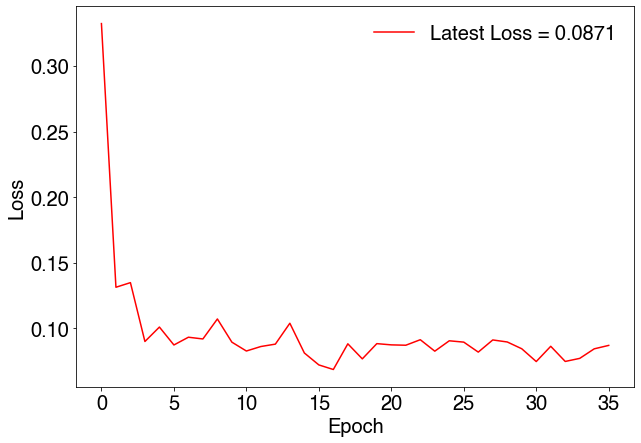

In [143]:
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled, y_scaled)

# def weights_init_uniform(m): # For initializing uniform weights
#     classname = m.__class__.__name__
#     # for every Linear layer in a model..
#     if classname.find('Linear') != -1:
#         # apply a uniform distribution to the weights and a bias=0
#         m.weight.data.uniform_(0.0, 1.0)
#         m.bias.data.fill_(0)

# Q_net.apply(weights_init_uniform) # Initialize uniform weights

optimizer = torch.optim.Adam(Q_net.parameters(), lr = 1e-3) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss

BATCH_SIZE = 500 # Batch size
EPOCH      = 50   # No. of epochs

# Splitting dataset into batches
loader = torch.utils.data.DataLoader(dataset     = torch_dataset, 
                         batch_size  = BATCH_SIZE, 
                         shuffle     = True, 
                         num_workers = 0)

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step

        prediction = Q_net(batch_x.double())          # input x and predict based on x

        loss       = loss_func(prediction, batch_y) # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients

        if step == 1:
            # plot and show learning process
            plt.cla()
            loss_list += [loss.data.numpy()]
            plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
            plt.xlabel('Epoch', fontsize = 20)
            plt.ylabel('Loss', fontsize = 20)
            plt.xticks(fontsize = 20)
            plt.yticks(fontsize = 20)
            plt.legend(fontsize = 20, frameon= 0)
            
            display.clear_output(wait = True) #these two lines plots the data in real time
            display.display(fig)
            print('Current Epoch =', epoch)
            print('Latest Loss =', loss.data.numpy())

In [149]:
predictions = (Q_net(X_scaled).detach().numpy() * y_std_Q) + y_mean_Q
predictions[:10], y[:10]

(array([[292.34082105],
        [279.33139109],
        [223.1666772 ],
        [238.31597967],
        [217.9722962 ],
        [204.13004232],
        [216.1796543 ],
        [235.27626536],
        [199.57427529],
        [162.94844118]]),
 array([[298.22305213],
        [268.40074691],
        [241.56067222],
        [217.404605  ],
        [195.6641445 ],
        [176.09773005],
        [158.48795704],
        [142.63916134],
        [128.37524521],
        [115.53772069]]))

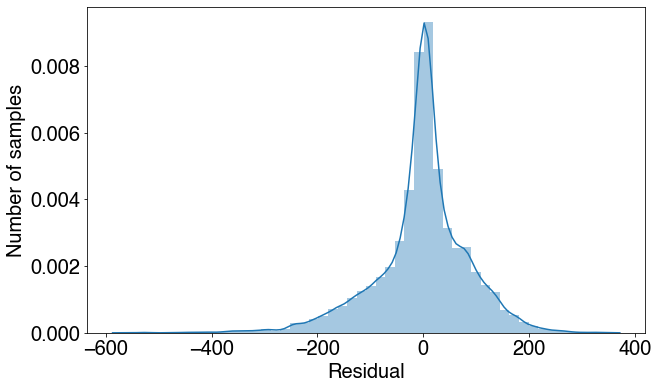

In [150]:
# Plot histogram of errors
residual = predictions - y
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(residual)
ax.set(xlabel= 'Residual', ylabel = 'Number of samples')
plt.show()

In [193]:
episode       = generate_episode_with_NN(NN = max_action,
                                             initial_state = [0., 0., 0., 290., 100., 0.],
                                             epsilon = epsilon)
episode

[[[0.0, 0.0, 0.0, 290.0, 100.0, 0.0],
  [247.24937059046448, 277.26838718034173],
  0],
 [[1.986162761145716,
   0.0013866598163449328,
   1.4798446021420148e-06,
   288.4807715458917,
   198.8997482361859,
   0.4],
  [249.4051029073829, 338.4813768822979],
  0],
 [[2.6413935498080443,
   0.009638387861221025,
   3.3605290248980437e-05,
   317.415471671355,
   298.6617893991392,
   0.8],
  [246.7034821450625, 279.71456431836134],
  0],
 [[2.959094522131544,
   0.017073117374828993,
   0.00010946296449083606,
   301.9187176452826,
   397.3431822571645,
   1.2000000000000002],
  [248.22507663479487, 486.6480847543193],
  0],
 [[3.0682121974255905,
   0.06292199091534789,
   0.0007808190594530105,
   362.1804892084394,
   496.63321291108247,
   1.6],
  [247.13268516482137, 497.535723161332],
  0],
 [[2.6360528074091696,
   0.34108012840092977,
   0.015100644917394945,
   418.3815174879856,
   595.486286977011,
   2.0],
  [244.14804093534138, 496.0044798747965],
  0],
 [[0.2488505039406988

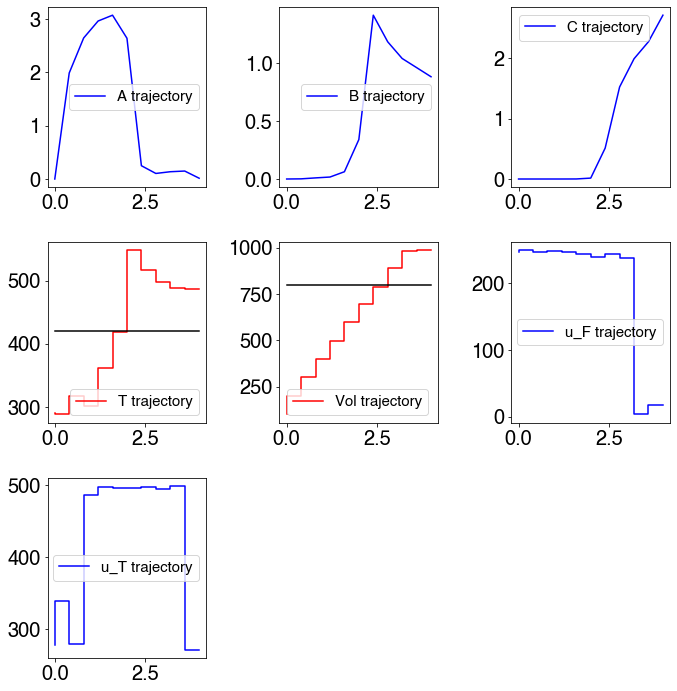

Score: 2672.070767198443


In [194]:
plot_episode(episode)

In [195]:
score_NN_policy(max_action, [0., 0., 0., 290., 100., 0.], num_iterations = 100)

2654.4321084085664

## Training the UNCONSTRAINED Q-network

In [163]:
# Initialize Q-network
Q_net = torch.nn.Sequential(
        torch.nn.Linear(8,   200, bias = True), # 6 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

In [164]:
# ========== 1) GENERATING INITIAL BATCH OF SAMPLES FOR REPLAY BUFFER ==========
epsilon       = 0.99
replay_buffer = collections.deque(maxlen = 3000) # Max capacity of 3000

for i in range(100): # Generate 100 episodes
    episode       = generate_episode_with_NN(NN = max_action,
                                             initial_state = [0., 0., 0., 290., 100., 0.],
                                             epsilon = epsilon)
    replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
print(len(replay_buffer))

# ================================= 2) TRAINING THE Q-NETWORK =================================
epsilon            = 0.99 # Initial epsilon
score_list         = [] # For plotting score of policy visited over time
iteration_list     = []
policy_mean_list   = [] # For plotting evolution of policy visited over time
policy_std_list    = [] # For plotting evolution of policy visited over time
training_loss_list = [] # For plotting loss of NN (after 20 epochs) over time
episode_bank       = [] # A list of list of lists - Tertiary list  -> Iterations
                        #                         - Secondary list -> Episodes
                        #                         - Primary list   -> Steps
                        #                         For plotting evolution of states visited over time            

for iteration in range(1000):
    # SCORE EXISTING POLICY
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)
    current_score = score_NN_policy(max_action, [0., 0., 0., 290., 100., 0.], num_iterations = 10)
    print('AVERAGE SCORE = '  , current_score)
    print('')
    
    # GENERATE EPISODES & ADD TO REPLAY BUFFER
    for j in range(100):
        episode       = generate_episode_with_NN(NN = max_action,
                                             initial_state = [0., 0., 0., 290., 100., 0.],
                                             epsilon = epsilon)
        replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
    
    # SAMPLE EPISODES FROM REPLAY BUFFER
    combined_inputs  = [] # List of lists to be converted into input tensor
    combined_targets = [] # List to be converted into target tensor
    samples          = random.sample(replay_buffer, 100) # Draw random samples from replay buffer
    
    for inputs, target in samples:
        combined_inputs  += [inputs]
        combined_targets += [[target]]
    combined_inputs  = torch.tensor(combined_inputs)  # Convert list to tensor
    combined_targets = torch.tensor(combined_targets) # Convert list to tensor
    
    # TRAIN THE NEURAL NETWORK
    optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    

    for epoch in range(20):
        prediction = Q_net(combined_inputs)                    # Input x and predict based on x
        loss       = loss_func(prediction, combined_targets) # Must be (1. nn output, 2. target)

        optimizer.zero_grad()   # Clear gradients for next train
        loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % loss.data.numpy())

    score_list         += [current_score] # Store score for each iteration
    training_loss_list += [loss.data.numpy()]                                # Store training loss after 20 epochs for each iteration
    iteration_list     += [iteration]                                        # Store iteration
    
#     # INVESTIGATING EVOLUTION OF POLICY OVER TRAINING ITERATIONS
#     if iteration in np.arange(0,5000,10): # Every 10 iterations
#         list_of_policies  = score_NN_policy(GA_optimize, [1.0, 150.0, 0, 0], num_iterations = 100, get_control = True)[1] # add policies
#         policy_mean       = np.mean(list_of_policies, axis = 0) # Calculate mean of policies
#         policy_std        = np.std(list_of_policies, axis = 0)  # Calculate std of policies
#         policy_mean_list += [policy_mean] # Save mean policy for plotting
#         policy_std_list  += [policy_std]  # Save std of policy for plotting
    
    # INVESTIGATING EVOLUTION OF STATES VISITED OVER TRAINING ITERATIONS
    if iteration in np.arange(0, 5000, 10): # Every 10 iterations
        pool_of_episodes = [] # A *list of lists* of episodes
        for i in range(10):   # Generate 10 sample episodes and store them
            pool_of_episodes += [generate_episode_with_NN(NN = max_action,
                                             initial_state = [0., 0., 0., 290., 100., 0.],
                                             epsilon = 0)]
        episode_bank         += [pool_of_episodes]
    
    epsilon *= 0.99 # Decay epsilon

1100
=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
AVERAGE SCORE =  873.5328343889325

=========== TRAINING ITERATION 1 ===========
Current epsilon =  0.9801
AVERAGE SCORE =  1371.1642002091783

=========== TRAINING ITERATION 2 ===========
Current epsilon =  0.9702989999999999
AVERAGE SCORE =  0.0036050485013829543

=========== TRAINING ITERATION 3 ===========
Current epsilon =  0.96059601
AVERAGE SCORE =  1582.2781309880102

=========== TRAINING ITERATION 4 ===========
Current epsilon =  0.9509900498999999
AVERAGE SCORE =  1516.7303806360958

=========== TRAINING ITERATION 5 ===========
Current epsilon =  0.9414801494009999
AVERAGE SCORE =  2031.272713749556

=========== TRAINING ITERATION 6 ===========
Current epsilon =  0.9320653479069899
AVERAGE SCORE =  2470.262825539783

=========== TRAINING ITERATION 7 ===========
Current epsilon =  0.92274469442792
AVERAGE SCORE =  2526.941612447587

=========== TRAINING ITERATION 8 ===========
Current epsilon =  0.913517

AVERAGE SCORE =  2119.404883363867

=========== TRAINING ITERATION 69 ===========
Current epsilon =  0.49483865960020695
AVERAGE SCORE =  2278.215372866816

=========== TRAINING ITERATION 70 ===========
Current epsilon =  0.4898902730042049
AVERAGE SCORE =  1583.2358797873683

=========== TRAINING ITERATION 71 ===========
Current epsilon =  0.48499137027416284
AVERAGE SCORE =  2483.3355846333907

=========== TRAINING ITERATION 72 ===========
Current epsilon =  0.4801414565714212
AVERAGE SCORE =  485.40474393086595

=========== TRAINING ITERATION 73 ===========
Current epsilon =  0.475340042005707
AVERAGE SCORE =  2292.5688085636048

=========== TRAINING ITERATION 74 ===========
Current epsilon =  0.47058664158564995
AVERAGE SCORE =  2353.0924041578182

=========== TRAINING ITERATION 75 ===========
Current epsilon =  0.4658807751697934
AVERAGE SCORE =  1483.7036484923065

=========== TRAINING ITERATION 76 ===========
Current epsilon =  0.4612219674180955
AVERAGE SCORE =  2467.5615449889

AVERAGE SCORE =  1862.3669776023326

=========== TRAINING ITERATION 137 ===========
Current epsilon =  0.24983705645845267
AVERAGE SCORE =  2373.867026664317

=========== TRAINING ITERATION 138 ===========
Current epsilon =  0.24733868589386815
AVERAGE SCORE =  1517.7780130043877

=========== TRAINING ITERATION 139 ===========
Current epsilon =  0.24486529903492946
AVERAGE SCORE =  1810.4467379974062

=========== TRAINING ITERATION 140 ===========
Current epsilon =  0.24241664604458016
AVERAGE SCORE =  2492.8635884173345

=========== TRAINING ITERATION 141 ===========
Current epsilon =  0.23999247958413436
AVERAGE SCORE =  2435.768667477309

=========== TRAINING ITERATION 142 ===========
Current epsilon =  0.23759255478829303
AVERAGE SCORE =  2492.512612103515

=========== TRAINING ITERATION 143 ===========
Current epsilon =  0.2352166292404101
AVERAGE SCORE =  2499.6943100712906

=========== TRAINING ITERATION 144 ===========
Current epsilon =  0.232864462948006
AVERAGE SCORE =  2491.

AVERAGE SCORE =  2581.748488789545

=========== TRAINING ITERATION 204 ===========
Current epsilon =  0.12741333767875881
AVERAGE SCORE =  2372.5169379613826

=========== TRAINING ITERATION 205 ===========
Current epsilon =  0.12613920430197123
AVERAGE SCORE =  2577.4525796746675

=========== TRAINING ITERATION 206 ===========
Current epsilon =  0.12487781225895152
AVERAGE SCORE =  2520.9615409345174

=========== TRAINING ITERATION 207 ===========
Current epsilon =  0.123629034136362
AVERAGE SCORE =  2496.0338258796537

=========== TRAINING ITERATION 208 ===========
Current epsilon =  0.12239274379499838
AVERAGE SCORE =  2467.4194435387517

=========== TRAINING ITERATION 209 ===========
Current epsilon =  0.1211688163570484
AVERAGE SCORE =  2525.4868030836756

=========== TRAINING ITERATION 210 ===========
Current epsilon =  0.11995712819347792
AVERAGE SCORE =  2549.2396024464333

=========== TRAINING ITERATION 211 ===========
Current epsilon =  0.11875755691154315
AVERAGE SCORE =  250

AVERAGE SCORE =  2644.341406115472

=========== TRAINING ITERATION 271 ===========
Current epsilon =  0.06497898609824969
AVERAGE SCORE =  2624.977827627353

=========== TRAINING ITERATION 272 ===========
Current epsilon =  0.0643291962372672
AVERAGE SCORE =  2570.652256512534

=========== TRAINING ITERATION 273 ===========
Current epsilon =  0.06368590427489453
AVERAGE SCORE =  2622.967815535981

=========== TRAINING ITERATION 274 ===========
Current epsilon =  0.06304904523214558
AVERAGE SCORE =  2468.7858774147644

=========== TRAINING ITERATION 275 ===========
Current epsilon =  0.06241855477982412
AVERAGE SCORE =  2292.3326849525633

=========== TRAINING ITERATION 276 ===========
Current epsilon =  0.06179436923202588
AVERAGE SCORE =  2654.6018874688425

=========== TRAINING ITERATION 277 ===========
Current epsilon =  0.06117642553970562
AVERAGE SCORE =  2616.496875535314

=========== TRAINING ITERATION 278 ===========
Current epsilon =  0.06056466128430856
AVERAGE SCORE =  2605.

AVERAGE SCORE =  2598.955154020346

=========== TRAINING ITERATION 338 ===========
Current epsilon =  0.03313835671585597
AVERAGE SCORE =  2636.9521944973467

=========== TRAINING ITERATION 339 ===========
Current epsilon =  0.03280697314869741
AVERAGE SCORE =  2579.072020322042

=========== TRAINING ITERATION 340 ===========
Current epsilon =  0.032478903417210436
AVERAGE SCORE =  2629.2078947869327

=========== TRAINING ITERATION 341 ===========
Current epsilon =  0.032154114383038335
AVERAGE SCORE =  2602.095027157749

=========== TRAINING ITERATION 342 ===========
Current epsilon =  0.03183257323920795
AVERAGE SCORE =  2606.7777819416538

=========== TRAINING ITERATION 343 ===========
Current epsilon =  0.03151424750681587
AVERAGE SCORE =  2620.2977317857376

=========== TRAINING ITERATION 344 ===========
Current epsilon =  0.03119910503174771
AVERAGE SCORE =  2632.4887863936756

=========== TRAINING ITERATION 345 ===========
Current epsilon =  0.030887113981430233
AVERAGE SCORE = 

AVERAGE SCORE =  2579.6949274811445

=========== TRAINING ITERATION 405 ===========
Current epsilon =  0.016900089579220106
AVERAGE SCORE =  2601.71656955615

=========== TRAINING ITERATION 406 ===========
Current epsilon =  0.016731088683427906
AVERAGE SCORE =  2627.205989812516

=========== TRAINING ITERATION 407 ===========
Current epsilon =  0.016563777796593626
AVERAGE SCORE =  2641.05087623485

=========== TRAINING ITERATION 408 ===========
Current epsilon =  0.016398140018627688
AVERAGE SCORE =  2635.9097426842336

=========== TRAINING ITERATION 409 ===========
Current epsilon =  0.01623415861844141
AVERAGE SCORE =  2643.6742481108245

=========== TRAINING ITERATION 410 ===========
Current epsilon =  0.016071817032256998
AVERAGE SCORE =  2618.5726652304666

=========== TRAINING ITERATION 411 ===========
Current epsilon =  0.01591109886193443
AVERAGE SCORE =  2621.6812496935627

=========== TRAINING ITERATION 412 ===========
Current epsilon =  0.015751987873315085
AVERAGE SCORE =

AVERAGE SCORE =  2628.7669141136234

=========== TRAINING ITERATION 472 ===========
Current epsilon =  0.008618804795743068
AVERAGE SCORE =  2647.22600822218

=========== TRAINING ITERATION 473 ===========
Current epsilon =  0.008532616747785637
AVERAGE SCORE =  2645.700453799925

=========== TRAINING ITERATION 474 ===========
Current epsilon =  0.00844729058030778
AVERAGE SCORE =  2643.685845119894

=========== TRAINING ITERATION 475 ===========
Current epsilon =  0.008362817674504702
AVERAGE SCORE =  2636.260446563631

=========== TRAINING ITERATION 476 ===========
Current epsilon =  0.008279189497759654
AVERAGE SCORE =  2658.8522273771623

=========== TRAINING ITERATION 477 ===========
Current epsilon =  0.008196397602782058
AVERAGE SCORE =  2631.3358349910714

=========== TRAINING ITERATION 478 ===========
Current epsilon =  0.008114433626754238
AVERAGE SCORE =  2659.783073849699

=========== TRAINING ITERATION 479 ===========
Current epsilon =  0.008033289290486696
AVERAGE SCORE =

AVERAGE SCORE =  2641.2885754286444

=========== TRAINING ITERATION 539 ===========
Current epsilon =  0.004395467595536362
AVERAGE SCORE =  2638.5204692614634

=========== TRAINING ITERATION 540 ===========
Current epsilon =  0.004351512919580998
AVERAGE SCORE =  2651.035617183489

=========== TRAINING ITERATION 541 ===========
Current epsilon =  0.004307997790385188
AVERAGE SCORE =  2654.9637106603623

=========== TRAINING ITERATION 542 ===========
Current epsilon =  0.004264917812481336
AVERAGE SCORE =  2659.3155023649565

=========== TRAINING ITERATION 543 ===========
Current epsilon =  0.0042222686343565225
AVERAGE SCORE =  2640.7461859754358

=========== TRAINING ITERATION 544 ===========
Current epsilon =  0.0041800459480129575
AVERAGE SCORE =  2642.682921274654

=========== TRAINING ITERATION 545 ===========
Current epsilon =  0.0041382454885328275
AVERAGE SCORE =  2655.3196139633774

=========== TRAINING ITERATION 546 ===========
Current epsilon =  0.004096863033647499
AVERAGE

=========== TRAINING ITERATION 605 ===========
Current epsilon =  0.0022642685068943362
AVERAGE SCORE =  2645.621976016161

=========== TRAINING ITERATION 606 ===========
Current epsilon =  0.002241625821825393
AVERAGE SCORE =  2658.482785174259

=========== TRAINING ITERATION 607 ===========
Current epsilon =  0.002219209563607139
AVERAGE SCORE =  2635.1749462071202

=========== TRAINING ITERATION 608 ===========
Current epsilon =  0.0021970174679710676
AVERAGE SCORE =  2649.0241769443337

=========== TRAINING ITERATION 609 ===========
Current epsilon =  0.0021750472932913567
AVERAGE SCORE =  2634.015050606804

=========== TRAINING ITERATION 610 ===========
Current epsilon =  0.0021532968203584434
AVERAGE SCORE =  2635.2374346822435

=========== TRAINING ITERATION 611 ===========
Current epsilon =  0.002131763852154859
AVERAGE SCORE =  2650.7993008323924

=========== TRAINING ITERATION 612 ===========
Current epsilon =  0.0021104462136333105
AVERAGE SCORE =  2630.9149563928295

======

=========== TRAINING ITERATION 671 ===========
Current epsilon =  0.0011664087517150481
AVERAGE SCORE =  2642.446942272414

=========== TRAINING ITERATION 672 ===========
Current epsilon =  0.0011547446641978977
AVERAGE SCORE =  2644.9718375933767

=========== TRAINING ITERATION 673 ===========
Current epsilon =  0.0011431972175559187
AVERAGE SCORE =  2653.27371100455

=========== TRAINING ITERATION 674 ===========
Current epsilon =  0.0011317652453803595
AVERAGE SCORE =  2656.200901759233

=========== TRAINING ITERATION 675 ===========
Current epsilon =  0.0011204475929265558
AVERAGE SCORE =  2662.818290248624

=========== TRAINING ITERATION 676 ===========
Current epsilon =  0.0011092431169972903
AVERAGE SCORE =  2646.9929162129574

=========== TRAINING ITERATION 677 ===========
Current epsilon =  0.0010981506858273175
AVERAGE SCORE =  2653.0005336141685

=========== TRAINING ITERATION 678 ===========
Current epsilon =  0.0010871691789690443
AVERAGE SCORE =  2648.17629620036

=======

=========== TRAINING ITERATION 737 ===========
Current epsilon =  0.0006008604420963866
AVERAGE SCORE =  2636.822317297364

=========== TRAINING ITERATION 738 ===========
Current epsilon =  0.0005948518376754227
AVERAGE SCORE =  2644.0093846161835

=========== TRAINING ITERATION 739 ===========
Current epsilon =  0.0005889033192986684
AVERAGE SCORE =  2652.1026787966416

=========== TRAINING ITERATION 740 ===========
Current epsilon =  0.0005830142861056818
AVERAGE SCORE =  2638.1508083212784

=========== TRAINING ITERATION 741 ===========
Current epsilon =  0.0005771841432446249
AVERAGE SCORE =  2642.575461298327

=========== TRAINING ITERATION 742 ===========
Current epsilon =  0.0005714123018121786
AVERAGE SCORE =  2657.6275626068245

=========== TRAINING ITERATION 743 ===========
Current epsilon =  0.0005656981787940568
AVERAGE SCORE =  2628.6332285620206

=========== TRAINING ITERATION 744 ===========
Current epsilon =  0.0005600411970061162
AVERAGE SCORE =  2667.0727871833215

==

AVERAGE SCORE =  2646.376784601288

=========== TRAINING ITERATION 803 ===========
Current epsilon =  0.00030952551611552456
AVERAGE SCORE =  2651.82999199308

=========== TRAINING ITERATION 804 ===========
Current epsilon =  0.00030643026095436934
AVERAGE SCORE =  2651.021819202195

=========== TRAINING ITERATION 805 ===========
Current epsilon =  0.00030336595834482564
AVERAGE SCORE =  2651.975061104472

=========== TRAINING ITERATION 806 ===========
Current epsilon =  0.0003003322987613774
AVERAGE SCORE =  2655.624431305819

=========== TRAINING ITERATION 807 ===========
Current epsilon =  0.0002973289757737636
AVERAGE SCORE =  2643.8561606192343

=========== TRAINING ITERATION 808 ===========
Current epsilon =  0.000294355686016026
AVERAGE SCORE =  2663.97092888138

=========== TRAINING ITERATION 809 ===========
Current epsilon =  0.00029141212915586575
AVERAGE SCORE =  2656.94732476684

=========== TRAINING ITERATION 810 ===========
Current epsilon =  0.00028849800786430707
AVERAG

AVERAGE SCORE =  2665.0009087771164

=========== TRAINING ITERATION 869 ===========
Current epsilon =  0.00015944808214086637
AVERAGE SCORE =  2658.4797574509876

=========== TRAINING ITERATION 870 ===========
Current epsilon =  0.0001578536013194577
AVERAGE SCORE =  2650.0573960553174

=========== TRAINING ITERATION 871 ===========
Current epsilon =  0.00015627506530626313
AVERAGE SCORE =  2646.351197204999

=========== TRAINING ITERATION 872 ===========
Current epsilon =  0.0001547123146532005
AVERAGE SCORE =  2653.848985965605

=========== TRAINING ITERATION 873 ===========
Current epsilon =  0.0001531651915066685
AVERAGE SCORE =  2662.028691995266

=========== TRAINING ITERATION 874 ===========
Current epsilon =  0.0001516335395916018
AVERAGE SCORE =  2658.5062182960055

=========== TRAINING ITERATION 875 ===========
Current epsilon =  0.00015011720419568576
AVERAGE SCORE =  2647.318028665526

=========== TRAINING ITERATION 876 ===========
Current epsilon =  0.0001486160321537289
A

AVERAGE SCORE =  2668.5110892614675

=========== TRAINING ITERATION 935 ===========
Current epsilon =  8.213762541279968e-05
AVERAGE SCORE =  2670.0071147643457

=========== TRAINING ITERATION 936 ===========
Current epsilon =  8.131624915867167e-05
AVERAGE SCORE =  2651.96651306039

=========== TRAINING ITERATION 937 ===========
Current epsilon =  8.050308666708495e-05
AVERAGE SCORE =  2667.8122545639653

=========== TRAINING ITERATION 938 ===========
Current epsilon =  7.96980558004141e-05
AVERAGE SCORE =  2651.740354524505

=========== TRAINING ITERATION 939 ===========
Current epsilon =  7.890107524240995e-05
AVERAGE SCORE =  2641.658730689937

=========== TRAINING ITERATION 940 ===========
Current epsilon =  7.811206448998585e-05
AVERAGE SCORE =  2657.4877538026817

=========== TRAINING ITERATION 941 ===========
Current epsilon =  7.733094384508598e-05
AVERAGE SCORE =  2655.8756710343737

=========== TRAINING ITERATION 942 ===========
Current epsilon =  7.655763440663513e-05
AVERA

In [118]:
generate_episode_with_NN(NN = max_action, initial_state = [0., 0., 0., 290., 100., 0.], epsilon = 0)

[[[0.0, 0.0, 0.0, 290.0, 100.0, 0.0],
  [248.5734114012877, 417.05251316365747],
  0],
 [[0.011870698340717956,
   0.006232116548723275,
   2.9549169746406108,
   402.8390275339694,
   199.42936456051504,
   0.4],
  [218.5420639793708, 434.74513445263983],
  0],
 [[0.007255990493570097,
   0.0038093944171292,
   3.885978713713581,
   414.0260433725541,
   286.8461901522637,
   0.8],
  [208.08170901221942, 365.439612026045],
  0],
 [[0.005354887003751783,
   0.002811315704999313,
   4.362261659892375,
   389.8217745253485,
   370.0788737571518,
   1.2000000000000002],
  [248.8180889612592, 272.3558054834739],
  0],
 [[0.005046135135117976,
   0.002649221063461589,
   4.70682028611073,
   353.2884616327866,
   469.6061093416554,
   1.6],
  [231.13208446570354, 270.2052992573869],
  0],
 [[0.003916418297458968,
   0.002056119585072783,
   4.920456659950548,
   337.2628851999095,
   562.0589431279371,
   2.0],
  [109.7464082139361, 492.1049648011883],
  0],
 [[0.0017248798533505971,
   0.0

In [165]:
# # Save neural network
# torch.save(Q_net, './NN_models/CS2_Q_net_unconstrained')

# # Load pre-trained neural network
# Q_net = torch.load('./NN_models/CS2_Q_net_unconstrained')
# Q_net.eval()

No handles with labels found to put in legend.


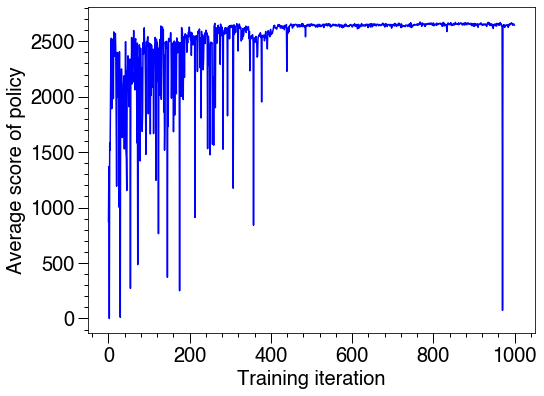

No handles with labels found to put in legend.


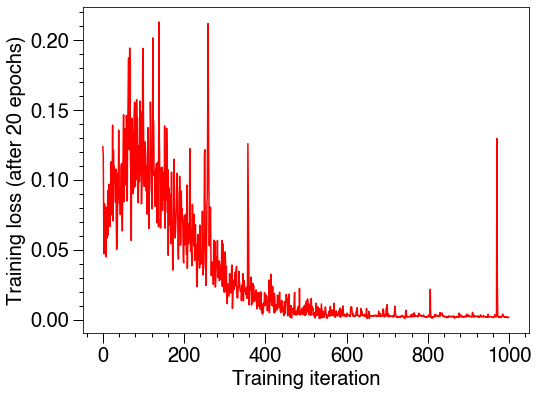

In [166]:
# Save data
# with open('./Data/CS2_score_max_action_unconstrained', 'wb') as f:
#     pickle.dump(score_list, f, pickle.HIGHEST_PROTOCOL)
# with open('./Data/CS2_loss_max_action_unconstrained', 'wb') as f:
#     pickle.dump(training_loss_list, f, pickle.HIGHEST_PROTOCOL)

# Load pre-run data
# with open('./Data/CS2_score_max_action_unconstrained', 'rb') as f:
#     score_list = pickle.load(f)
# with open('./Data/CS2_loss_max_action_unconstrained', 'rb') as f:
#     training_loss_list = pickle.load(f)

# Plot score vs. training iteration
fig, ax = plt.subplots(figsize=(8,6))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(iteration_list, score_list, color = 'b')
plt.legend(frameon =  0)
plt.ylabel('Average score of policy', fontsize = 20)
plt.xlabel('Training iteration', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# Plot training loss vs. training iteration
fig, ax = plt.subplots(figsize=(8,6))
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.tick_params(which='major', length=10, width=1, direction='out')
ax.tick_params(which='minor', length=4, width=1, direction='out')
plt.plot(iteration_list, training_loss_list, color = 'r')
plt.legend(frameon =  0)
plt.ylabel('Training loss (after 20 epochs)', fontsize = 20)
plt.xlabel('Training iteration', fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

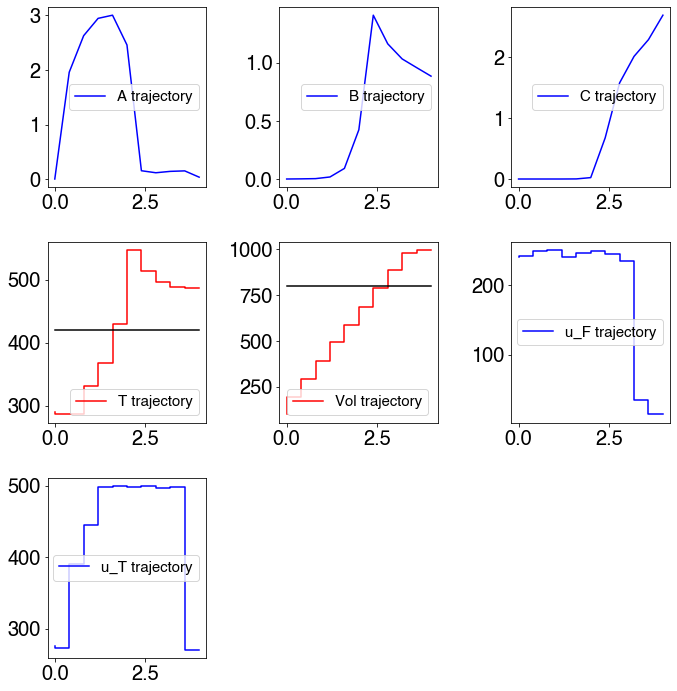

Score: 2673.5099254293245


In [197]:
episode       = generate_episode_with_NN(NN = max_action,
                                             initial_state = [0., 0., 0., 290., 100., 0.],
                                             epsilon = 0)
plot_episode(episode)

## Genetic algorithm

In [8]:
# Source: Ahmed Gad - https://github.com/ahmedfgad/GeneticAlgorithmPython/tree/master/Tutorial%20Project
def cal_pop_fitness(population, initial_state):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    state = []
    population = population.tolist() # convert 2D array to list of lists
    for i in range(len(population)):
        s = initial_state + population[i] # Append action to state 
        s = standardize_state_Q(s) # Standardize
        state += [s]
    state = torch.tensor(state).double()
    fitness = Q_net(state).detach().numpy()
    return fitness

def cal_pop_fitness_constrained(population, initial_state, g1_threshold, g2_threshold):
    # Calculating the fitness value of each solution in the current population.
    # The fitness function calulates the sum of products between each input and its corresponding weight.
    
    # CALCULATE Q-FITNESS
    state = []
    population = population.tolist() # convert 2D array to list of lists
    for i in range(len(population)):
        s = initial_state + population[i] # Append action to state 
        s = standardize_state_Q(s) # Standardize using Q-network mean & std
        state += [s]
    state = torch.tensor(state).double()
    fitness_Q = (Q_net(state).detach().numpy() * y_std_Q) + y_mean_Q # Unstandardized Q-network fitness
#     print('fitness_Q:', fitness_Q)
    # CALCULATE C-FITNESS 
    state = []
    
    initial_state_for_C = copy.deepcopy(initial_state) 
    initial_state_for_C[5] = 4. - initial_state_for_C[5] #### NEED TO TRANSFORM T TO T_F- T #####
#     print('population:', population)
    for i in range(len(population)):
        s = initial_state_for_C + population[i] # Append action to state 
#         print('non-standardized state:',s)
        s = standardize_state_C(s) # Standardize using C-network mean & std
#         print('standardized state:',s)
        state += [s]
    state = torch.tensor(state).double()
    state_copy = copy.deepcopy(state) # Just to be sure
    state_copy2 = copy.deepcopy(state) # Just to be sure
    
    fitness_g1 = -1*((g1_net(state).detach().numpy() * y_std_C[0]) + y_mean_C[0])  # Unstandardized C-network fitness - NEGATIVE SIGN because -ve g1_net values denote higher fitness!
    fitness_g2 = -1*((g2_net(state_copy).detach().numpy() * y_std_C[1]) + y_mean_C[1])

#     print('fitness_g1:', fitness_g1)
#     print('fitness_g2:', fitness_g2)

    # COMBINE Q-FITNESS AND C-FITNESS
    fitness_overall = []
    for i in range(len(population)):
        
        # include gl and g2 only for now
        f = max(0, fitness_Q[i].item()) + 1000000*min(0, fitness_g1[i].item() + g1_threshold) + 1000000*min(0, fitness_g2[i].item() + g2_threshold) 
        fitness_overall += [f]
    
    return fitness_overall

def select_mating_pool(pop, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = np.empty((num_parents, pop.shape[1]))
    for parent_num in range(num_parents):
        max_fitness_idx = np.where(fitness == np.max(fitness))
        max_fitness_idx = max_fitness_idx[0][0]
        parents[parent_num, :] = pop[max_fitness_idx, :]
        fitness[max_fitness_idx] = -99999999999     # Make the current parent the most unfit
    return parents

def crossover(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # The point at which crossover takes place between two parents. Usually, it is at the center.
    crossover_point = np.uint8(offspring_size[1]/2) # Returns 1 in this case (because 2 values)

    for k in range(offspring_size[0]):
        # Index of the first parent to mate.
        parent1_idx = k%parents.shape[0]
        # Index of the second parent to mate.
        parent2_idx = (k+1)%parents.shape[0]
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, 0:crossover_point] = parents[parent1_idx, 0:crossover_point]
        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, crossover_point:] = parents[parent2_idx, crossover_point:]
    return offspring

def mutation(offspring_crossover, mut_percen):

    for idx in range(offspring_crossover.shape[0]): # Iterate over individual offspring
        for feature in range(offspring_crossover.shape[1]): # Iterate over its features 
            r = np.random.uniform(0, 1)
            
            if r < mut_percen: # If mutation occurs
#                 print('Mutated')
                if feature == 0: # If u_F 
                    offspring_crossover[idx, feature] = np.random.uniform(0, 250) # Pick random u_F
                else:            # Else u_T
                    offspring_crossover[idx, feature] = np.random.uniform(270, 500) # Pick random u_T
    return offspring_crossover

# def generate_random_episode_constrained(initial_state, g1_threshold = 0): 
#     '''Generates an episode using RANDOM policy
#     threshold is the tolerance of the limit, where 
#     0            : Limit itself (as per defined in extract_constraint_values_from_episode() function)
#     +ve threshold: Looser limit   
#     -ve threshold: Stricter limit 
#     '''
#     episode = []
#     state = initial_state  # Initial state
#     for i in range(11):   # Take (10 + 1) steps
#         predicted_c = np.inf # Initialize constraint
#         while predicted_c > g1_threshold: # Keep choosing a different action this until constraint is LESS THAN zero
#             old_state = state # Old state for storing into episode
#             old_state_without_action = old_state
#             old_state = list(old_state)
#             old_state[5] = 4. - old_state[5] # Convert to t to (t - t_f)
#             u_F  = np.random.uniform(0, 250) # Pick random u_F
#             u_T = np.random.uniform(270, 500)    # Pick random u_T
#             action = [u_F, u_T]
#             old_state += action     # Append action to state

#             old_state_standardized = old_state.copy()
#             old_state_standardized = standardize_state_C(old_state_standardized)

#             old_state_standardized = torch.tensor(old_state_standardized)
#             predicted_c = ((g1_net(old_state_standardized).detach().numpy())*y_std_C) + y_mean_C # Update predicted constraint
# #             print('predicted_c:', predicted_c)
#         state, reward  = transition(state, action)     # Evolve to get new state 
#         episode       += [[list(old_state_without_action), action, reward]] # Update step
#     return episode
# # generate_random_episode_constrained(initial_state = [1.0,150.0,0.,0.], g1_threshold = 0)

def GA_optimize(state, mut_percen = 0.1):
    '''Argument: State [CA, CB, CC, T, Vol, t]
       Output: Control [u_F, u_T] that maximizes Q 
    '''
    num_features       = 2  # Number of features (u_L and u_Fn)
    sol_per_pop        = 10 # Number of individuals per population
    num_parents_mating = 5  # Numbers of parents selected from each generation
    num_generations    = 10 # Number of generations
    
    mut_percen = mut_percen # Initial probability of mutation

    #Creating the initial population.
    new_pop = []
    for i in range(500): # Initial pop
        u_F  = np.random.uniform(0, 250) # Pick random u_F
        u_T  = np.random.uniform(270, 500)    # Pick random u_T
        new_pop += [[u_F, u_T]]
    new_pop = np.array(new_pop)
#     print('new_pop',new_pop)

    decay_factor = (0.01/mut_percen)**(1/num_generations) # Define decay factor for mut_percen

    state = state
    avg_fitness_list = [] # Store average fitness scores
    max_fitness_list = [] # Store max fitness scores
    generation_list  = []  # Store generation index

    for generation in range(num_generations):
        
        # Measuring the fitness of each chromosome in the population.
        fitness = cal_pop_fitness(new_pop, state)

        avg_fit = np.mean(fitness) # Average fitness
        max_fit = np.max(fitness)  # Max fitness of the generation
    #     print('==== Generation %.0f ====' % generation)
    #     print('Average fitness:', avg_fit)
    #     print('Max fitness:', max_fit)
    #     print('')
        avg_fitness_list += [avg_fit]    # Save average fitness score for plotting
        max_fitness_list += [max_fit]    # Save average fitness score for plotting
        generation_list  += [generation] # Save generation index

        # Selecting the best parents in the population for mating
        parents = select_mating_pool(new_pop, fitness, num_parents_mating)
#         print('parents:',parents)

        # Generating next generation using crossover
        offspring_crossover = crossover(parents, offspring_size=(sol_per_pop-parents.shape[0], num_features))
#         print('offspring_crossover',offspring_crossover)

        offspring_mutation = mutation(offspring_crossover, mut_percen = mut_percen)
#         print('offspring_mutation',offspring_mutation)

        # Creating the new population based on the parents and offspring
        new_pop[0:parents.shape[0], :] = parents
        new_pop[parents.shape[0]:sol_per_pop, :] = offspring_mutation

        # Cull excess initial population
        new_pop = new_pop[0:sol_per_pop,:]

    #     mut_percen = 0.5*e**(-1*generation/(num_generations/3)) # Decay
        mut_percen *= decay_factor
    
    max_action = new_pop[0] # Select the fittest action from final population
    return max_action
# GA_optimize([1.0, 150.0, 0, 0], mut_percen = 0.25) # Test function

# def GA_optimize_constrained(state, g1_threshold, g2_threshold, g3_threshold, init_mut_percen = 0.01):
#     '''Argument: State [Cx, Cn, Cq, t]
#        Output: Control [u_L, u_Fn] that maximizes Q and avoids violation of constraints
#     '''
#     num_features       = 2  # Number of features (u_L and u_Fn)
#     sol_per_pop        = 10 # Number of individuals per population
#     num_parents_mating = 5  # Numbers of parents selected from each generation
#     num_generations    = 10 # Number of generations
    
#     max_fitness = -np.inf # Initialize fitness
    
#     while max_fitness < 0: # Keep running this loop until no violations (no -ve fitness) occurs
    
#         mut_percen = init_mut_percen # Initial probability of mutation

#         #Creating the initial population.
#         new_pop = []
#         for i in range(200): # Initial pop
#             u_L  = np.random.uniform(120, 400) # Pick random u_L
#             u_Fn = np.random.uniform(0, 40)    # Pick random u_Fn
#             new_pop += [[u_L, u_Fn]]
#         new_pop = np.array(new_pop)
#     #     print('new_pop',new_pop)

#         decay_factor = (0.01/mut_percen)**(1/num_generations) # Define decay factor for mut_percen

#         state = state
#         avg_fitness_list = [] # Store average fitness scores
#         max_fitness_list = [] # Store max fitness scores
#         generation_list = []  # Store generation index

#         for generation in range(num_generations):

#             # Measuring the fitness of each chromosome in the population.
#             fitness = cal_pop_fitness_constrained(new_pop, state, g1_threshold = g1_threshold, g2_threshold = g2_threshold, g3_threshold = g3_threshold)

#             avg_fit = np.mean(fitness) # Average fitness
#             max_fit = np.max(fitness)  # Max fitness of the generation
#         #     print('==== Generation %.0f ====' % generation)
#         #     print('Average fitness:', avg_fit)
#         #     print('Max fitness:', max_fit)
#         #     print('')
#             avg_fitness_list += [avg_fit]    # Save average fitness score for plotting
#             max_fitness_list += [max_fit]    # Save average fitness score for plotting
#             generation_list  += [generation] # Save generation index

#             # Selecting the best parents in the population for mating
#             parents = select_mating_pool(new_pop, fitness, num_parents_mating)
#     #         print('parents:',parents)

#             # Generating next generation using crossover
#             offspring_crossover = crossover(parents, offspring_size=(sol_per_pop-parents.shape[0], num_features))
#     #         print('offspring_crossover',offspring_crossover)

#             offspring_mutation = mutation(offspring_crossover, mut_percen = mut_percen)
#     #         print('offspring_mutation',offspring_mutation)

#             # Creating the new population based on the parents and offspring
#             new_pop[0:parents.shape[0], :] = parents
#             new_pop[parents.shape[0]:sol_per_pop, :] = offspring_mutation

#             # Cull excess initial population
#             new_pop = new_pop[0:sol_per_pop,:]

#         #     mut_percen = 0.5*e**(-1*generation/(num_generations/3)) # Decay
#     #         mut_percen *= decay_factor

#         max_action = new_pop[0] # Select the fittest action from final population
#         max_fitness = max_fitness_list[-1] # Update max_fitness
# #     plt.figure()
# #     plt.plot(generation_list, avg_fitness_list, label = 'Avg (%.3f)'%avg_fitness_list[-1])
# #     plt.plot(generation_list, max_fitness_list, label = 'Max (%.3f)'%max_fitness_list[-1])
# #     plt.legend()
# #     plt.show()
# #     print(max_fitness)
    
#     return max_action
# GA_optimize_constrained([1.0, 150.0, 0, 0], g1_threshold = g1_threshold, g2_threshold = g2_threshold, g3_threshold = g3_threshold ) # Test function

def GA_optimize_constrained(state, g1_threshold, g2_threshold, init_mut_percen = 0.01):
    '''Argument: State [CA, CB, CC, T, Vol, t]
       Output: Control [u_F, u_T] that maximizes Q and avoids violation of constraints
    '''
    max_fitness = -np.inf # Initialize fitness
    
    while max_fitness < 0: # Keep running this loop until no violations (no -ve fitness) occurs
    
        #Creating the initial population.
        new_pop = []
        for i in range(1000): # Initial pop
            u_F  = np.random.uniform(0, 250)  # Pick random u_F
            u_T  = np.random.uniform(270, 500)    # Pick random u_T
            new_pop += [[u_F, u_T]]
            
        new_pop = np.array(new_pop)

        fitness = cal_pop_fitness_constrained(new_pop, state, g1_threshold = g1_threshold, g2_threshold = g2_threshold)
        max_idx = np.argmax(fitness)
        max_action  = new_pop[max_idx]
        max_fitness = fitness[max_idx]
            
    return max_action
# GA_optimize_constrained([1.0, 150.0, 0, 0], g1_threshold = 1000, g2_threshold = 100, g3_threshold = 0) # Test function'

# Introducing constraints
The goal is to train a 2nd neural network to predict a constraint value given a state-action pair. The data used to train this NN will generated using a random policy in the cells below.

In [9]:
# Generate UNCONSTRAINED data for training the constraint neural network

start = time.time()  # For timing purposes
state_action = []    # To store state and action [Cx, Cn, Cq, t-t_f, u_L, u_Fn]
g1_constraint   = []    # To store g1 constraint 
g2_constraint   = []    # To store g2 constraint 
num_episodes = 10000 # Number of episodes to generate

for j in range(num_episodes):
#     initialize_MDP_CDC() # Initialize system
    generated_episode = generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0.])  # Generate one episode
    s_a, g1, g2       = extract_constraint_values_from_episode(generated_episode)            # Extract data from episode
    
    state_action    += s_a          # Append state and action 
    g1_constraint   += g1           # Append g1 constraint
    g2_constraint   += g2           # Append g2 constraint

end = time.time() # For timing purposes

state_action = np.array(state_action)
g1_constraint   = np.array(g1_constraint)
g2_constraint   = np.array(g2_constraint)
print('')
print('Time taken:', end - start)
print('==========INPUT [CA, CB, CC, T, Vol, t_f-t, u_F, u_T]==========')
print(state_action)
print('')
print('==========TARGET VALUES [g1]==========')
print(g1_constraint)
print('==========TARGET VALUES [g2]==========')
print(g2_constraint)


Time taken: 86.17979693412781
==========INPUT [CA, CB, CC, T, Vol, t_f-t, u_F, u_T]==========
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.00000000e+00
  5.35788724e+01 3.69278670e+02]
 [6.82428698e-01 1.17267627e-02 1.21355711e-04 ... 3.60000000e+00
  1.56355728e+02 3.97512337e+02]
 [1.68317983e+00 7.07355030e-02 1.68879622e-03 ... 3.20000000e+00
  1.83655048e+02 3.94402611e+02]
 ...
 [6.23064289e-02 9.75504711e-01 1.24699326e+00 ... 1.20000000e+00
  1.98280967e+01 2.76727788e+02]
 [1.33967846e-01 9.39535748e-01 1.28622010e+00 ... 8.00000000e-01
  6.21740789e+01 4.60743538e+02]
 [3.49041002e-01 8.80209780e-01 1.25275720e+00 ... 4.00000000e-01
  2.31768571e+02 3.08688932e+02]]

==========TARGET VALUES [g1]==========
[[ 57.5271437 ]
 [ 57.5271437 ]
 [ 57.5271437 ]
 ...
 [-25.68171673]
 [-25.68171673]
 [-66.30666256]]
==========TARGET VALUES [g2]==========
[[-220.63815685]
 [-220.63815685]
 [-220.63815685]
 ...
 [-328.27807906]
 [-328.27807906]
 [-328.27807906]]


No handles with labels found to put in legend.


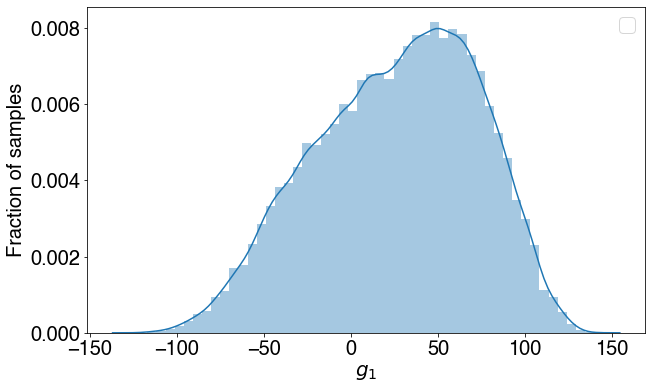

No handles with labels found to put in legend.


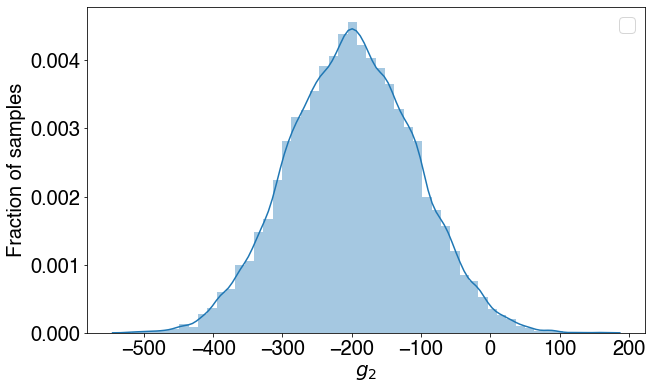

In [10]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(g1_constraint)
ax.set(xlabel= '$g_1$', ylabel = 'Fraction of samples')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(g2_constraint)
ax.set(xlabel= '$g_2$', ylabel = 'Fraction of samples')
plt.legend()
plt.show()

In [11]:
# Combine g1_constraint,g2_constraint and g3_constraint into a (n x 3) array for standardization purposes
g1g2_constraint = []
for i in range(len(g1_constraint)):
    g1g2_constraint += [[g1_constraint[i][0], g2_constraint[i][0]]]
g1g2_constraint = np.array(g1g2_constraint)
g1g2_constraint

array([[  57.5271437 , -220.63815685],
       [  57.5271437 , -220.63815685],
       [  57.5271437 , -220.63815685],
       ...,
       [ -25.68171673, -328.27807906],
       [ -25.68171673, -328.27807906],
       [ -66.30666256, -328.27807906]])

In [12]:
# Standardize data for C-network
X = state_action
y = g1g2_constraint

scaler_X = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y)

# Get mean and std
x_mean_C = scaler_X.mean_
x_std_C  = scaler_X.scale_
y_mean_C = scaler_y.mean_
y_std_C  = scaler_y.scale_

# Scale x
X_scaled = np.zeros(X.shape)
for feature in range(len(x_mean_C)): 
    X_scaled[:,feature] = (X[:,feature] - x_mean_C[feature])/x_std_C[feature]

# Scale g1
g1_scaled = np.zeros([y.shape[0],1])
g1_scaled[:] = (g1_constraint[:] - y_mean_C[0])/y_std_C[0] # Use 0th index of y_mean and y_std

# Scale g2
g2_scaled = np.zeros([y.shape[0],1])
g2_scaled[:] = (g2_constraint[:] - y_mean_C[1])/y_std_C[1] # Use 1st index of y_mean and y_std

# Convert into tensors
X_scaled = torch.tensor(X_scaled)
g1_scaled = torch.tensor(g1_scaled)
g2_scaled = torch.tensor(g2_scaled)
X_scaled, g1_scaled, g2_scaled

(tensor([[-1.4655, -1.1867, -0.6820,  ...,  1.5667, -0.9908, -0.2379],
         [-0.6484, -1.1576, -0.6817,  ...,  1.2185,  0.4302,  0.1865],
         [ 0.5498, -1.0113, -0.6770,  ...,  0.8704,  0.8077,  0.1397],
         ...,
         [-1.3909,  1.2321,  2.9892,  ..., -0.8704, -1.4575, -1.6289],
         [-1.3051,  1.1429,  3.1046,  ..., -1.2185, -0.8720,  1.1369],
         [-1.0476,  0.9958,  3.0061,  ..., -1.5667,  1.4730, -1.1485]],
        dtype=torch.float64),
 tensor([[ 0.6774],
         [ 0.6774],
         [ 0.6774],
         ...,
         [-1.1162],
         [-1.1162],
         [-1.9919]], dtype=torch.float64),
 tensor([[-0.2385],
         [-0.2385],
         [-0.2385],
         ...,
         [-1.4273],
         [-1.4273],
         [-1.4273]], dtype=torch.float64))

In [13]:
X_scaled.shape, g1_scaled.shape, g2_scaled.shape

(torch.Size([100000, 8]), torch.Size([100000, 1]), torch.Size([100000, 1]))

### Training g1-net

In [482]:
# Initialize g1_network
g1_net = torch.nn.Sequential(
        torch.nn.Linear(8, 500, bias = True), # 8 input nodes 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(500, 500, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(500, 200, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

KeyboardInterrupt: 

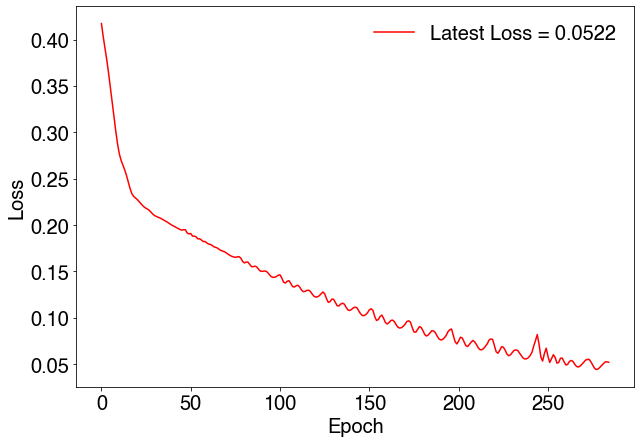

In [483]:
# for overfitting
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled[:1000], g1_scaled[:1000])

optimizer = torch.optim.Adam(g1_net.parameters(), lr = 5e-4, amsgrad= True) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss


EPOCH      = 1000   # No. of epochs

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    

    prediction = g1_net(X_scaled[:1000])          # input x and predict based on x

    loss       = loss_func(prediction, g1_scaled[:1000]) # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients


            # plot and show learning process
    plt.cla()
    loss_list += [loss.data.numpy()]
    plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20, frameon= 0)
            
    display.clear_output(wait = True) #these two lines plots the data in real time
    display.display(fig)
    print('Current Epoch =', epoch)
    print('Latest Loss =', loss.data.numpy())

g1-net: Moderate accuracy

In [484]:
print('g1_net predictions of g1:',  (g1_net(X_scaled[20:30]).detach().numpy()*y_std_C[0])+y_mean_C[0]   )
print('Actual labels:',  g1_constraint[20:30] )

g1_net predictions of g1: [[37.3264807 ]
 [47.59245439]
 [44.33305716]
 [53.73640918]
 [31.80017258]
 [42.89685888]
 [59.85562706]
 [59.79232561]
 [18.57381932]
 [ 3.47172372]]
Actual labels: [[59.57541477]
 [59.57541477]
 [59.57541477]
 [59.57541477]
 [59.57541477]
 [59.57541477]
 [59.57541477]
 [59.57541477]
 [21.31973307]
 [ 8.89283884]]


### Training g2-net

In [265]:
g2_net = torch.nn.Sequential(
        torch.nn.Linear(8, 200, bias = True), # 8 input nodes
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 100, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

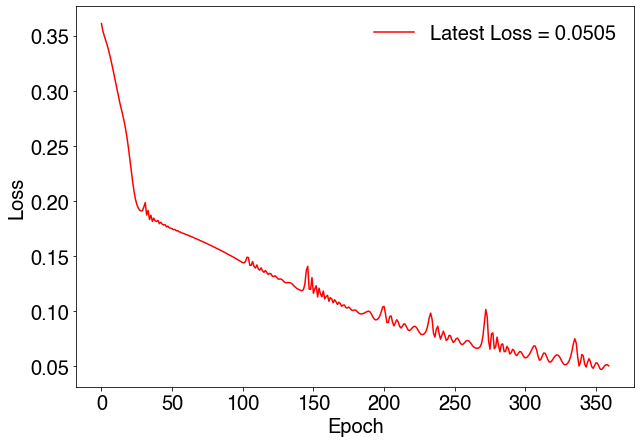

Current Epoch = 359
Latest Loss = 0.050496392619220024


KeyboardInterrupt: 

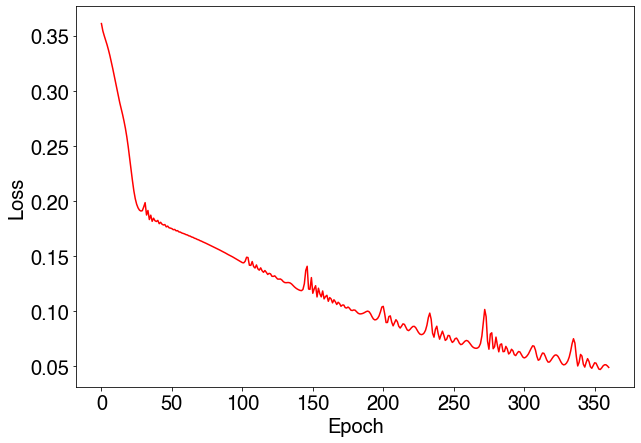

In [266]:
# for overfitting
# Define dataset
torch_dataset = torch.utils.data.TensorDataset(X_scaled[:1000], g2_scaled[:1000])

optimizer = torch.optim.Adam(g2_net.parameters(), lr = 1e-3, amsgrad= True) # Initialize Adam optimizer
loss_func = torch.nn.SmoothL1Loss()  # this is for regression mean squared loss


EPOCH      = 1000   # No. of epochs

# my_images = []  # For saving into gif
fig, ax = plt.subplots(figsize=(10,7))

epoch_list = [] # Save epoch for plotting
loss_list  = [] # Save loss for plotting

# Start training
for epoch in range(EPOCH):
    epoch_list += [epoch]
    

    prediction = g2_net(X_scaled[:1000])          # input x and predict based on x

    loss       = loss_func(prediction, g2_scaled[:1000]) # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients


            # plot and show learning process
    plt.cla()
    loss_list += [loss.data.numpy()]
    plt.plot(epoch_list, loss_list, label = 'Latest Loss = %.4f' % loss.data.numpy(), color = 'r')
    plt.xlabel('Epoch', fontsize = 20)
    plt.ylabel('Loss', fontsize = 20)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.legend(fontsize = 20, frameon= 0)
            
    display.clear_output(wait = True) #these two lines plots the data in real time
    display.display(fig)
    print('Current Epoch =', epoch)
    print('Latest Loss =', loss.data.numpy())

Good prediction by g2_net in general

In [277]:
print('g2_net predictions of g2:',  (g2_net(X_scaled[20:40]).detach().numpy()*y_std_C[1])+y_mean_C[1]   )
print('Actual labels:',  g2_constraint[20:40]   )

g2_net predictions of g2: [[-176.02334746]
 [-152.40815383]
 [-144.07233464]
 [-138.38350426]
 [-138.92801167]
 [-160.70648161]
 [-160.32826409]
 [-155.81195165]
 [-167.84489774]
 [-145.06104685]
 [-230.42972701]
 [-272.33016587]
 [-292.14150232]
 [-296.70970456]
 [-292.98846603]
 [-295.26773482]
 [-292.08224801]
 [-295.65133429]
 [-297.10554333]
 [-297.49180769]]
Actual labels: [[-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-146.25587037]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]
 [-293.68440858]]


## Plotting state space and visualize violation of constraints

### Random **unconstrained** policy

In [285]:
episode = generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0]) # Generate 1 episode
data   = extract_data_from_episode(episode, discount_factor = 0.9) 

[[0.8847132128440018,
  1.0671036969410341,
  0.6712336162793545,
  398.2696472124602,
  749.6400796646882,
  3.9999999999999996,
  88.00742872422434,
  481.17544493208527],
 503.18362158127206]

In [360]:
# Generate data using random policy
plotting_state_data = []
for i in range(1000):
#     initialize_MDP_CDC() # Initialize system
    episode = generate_random_episode(initial_state = [0., 0., 0., 290., 100., 0]) # Generate 1 episode
    data   = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[3] - 420 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[4] - 800 > 0] # Conpath 2
print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))

CC_all  = plotting_state_data[2]
T_all   = plotting_state_data[3]
Vol_all = plotting_state_data[4]

CC_g1  = plotting_state_data_g1_violated[2]
T_g1   = plotting_state_data_g1_violated[3]
Vol_g1 = plotting_state_data_g1_violated[4]

CC_g2  = plotting_state_data_g2_violated[2]
T_g2   = plotting_state_data_g2_violated[3]
Vol_g2 = plotting_state_data_g2_violated[4]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(CC_all, T_all, Vol_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(CC_g1, T_g1, Vol_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(CC_g2, T_g2, Vol_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('C', labelpad=30)
    plt.ylabel('T', labelpad=50)
    ax.set_zlabel('Vol', fontsize=20, labelpad=20)
    plt.legend()
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    plt.xlim(0,2.5)
    plt.ylim(0,600)
    ax.set_zlim(100, 1000)
    ax.view_init(ns,ew)
    plt.show()

No. of states visited: 11000
No. of states where g1 violated: 3274
No. of states where g2 violated: 11


interactive(children=(FloatSlider(value=0.0, description='ns', max=90.0, min=-90.0), FloatSlider(value=0.0, de…

### Training Q-network and C-network simultaneously

In [157]:
# Initialize Q-network
Q_net = torch.nn.Sequential(
        torch.nn.Linear(8,   200, bias = True), # 6 input nodes
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),    # apply ReLU activation function
        torch.nn.Linear(200,   1, bias = True), # 1 output node
    ).double()

# Initialize g1_network
g1_net = torch.nn.Sequential(
        torch.nn.Linear(8, 500, bias = True), # 4 input nodes 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(500, 500, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(500, 200, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(200, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

# Initialize g2_network
g2_net = torch.nn.Sequential(
        torch.nn.Linear(8, 200, bias = True), # 8 input nodes 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 200, bias = True), 
        torch.nn.LeakyReLU(),                
        torch.nn.Linear(200, 100, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(100, 50, bias = True), 
        torch.nn.LeakyReLU(),
        torch.nn.Linear(50, 1, bias = True), # 1 output node
    ).double()

In [158]:
# ========== 1) GENERATING INITIAL BATCH OF SAMPLES FOR REPLAY BUFFER ==========
epsilon       = 0.99   # Initial epsilon
g1_threshold  = 200    # Initial g1_threshold
g2_threshold  = 200    # Initial g2_threshold
replay_buffer = collections.deque(maxlen = 3000)  # Max capacity of 3k
g1_buffer     = collections.deque(maxlen = 10000) # Max capacity of 30k
g2_buffer     = collections.deque(maxlen = 10000) # Max capacity of 30k

for i in range(100): # Generate 100 initial episodes
#     initialize_MDP_CDC() # Initialize system
    episode       = generate_episode_with_NN(NN = GA_optimize_constrained,
                                             initial_state = [0., 0., 0., 290., 100., 0],
                                             epsilon = epsilon, 
                                             g1_threshold = g1_threshold,
                                             g2_threshold = g2_threshold)
    episode_copy  = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
    episode_copy2 = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
    replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
    g1_buffer     = update_g1_buffer(g1_buffer, episode_copy)  # Add to g1 buffer
    g2_buffer     = update_g2_buffer(g2_buffer, episode_copy2) # Add to g2 buffer

print('Initial size of replay buffer:', len(replay_buffer))
print('Initial size of g1 buffer:', len(g1_buffer))
print('Initial size of g2 buffer:', len(g2_buffer))

# ================================= 2) TRAINING THE Q-NETWORK =================================
g1_threshold_list  = [] # Store g1_threshold
g2_threshold_list  = [] # Store g2_threshold
epsilon_list       = [] # Store epsilon
score_list         = [] # For plotting score of policy visited over time
iteration_list     = [] # Store iteration
policy_mean_list   = [] # For plotting evolution of policy visited over time
policy_std_list    = [] # For plotting evolution of policy visited over time
training_loss_list = [] # For plotting loss of NN (after 20 epochs) over time
episode_bank       = [] # A list of list of lists - Tertiary list  -> Iterations
                        #                         - Secondary list -> Episodes
                        #                         - Primary list   -> Steps
                        #                         For plotting evolution of states visited over time            

for iteration in range(2000):
    
    # SCORE EXISTING POLICY
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)
    print('Current g1_threshold = ', g1_threshold)
    print('Current g2_threshold = ', g2_threshold)
#     MDP_CDC = Model_env(p, tf) # Initialize with fixed constants for scoring
    try:
        current_score = score_NN_policy(GA_optimize_constrained, 
                                        initial_state = [0., 0., 0., 290., 100., 0], # Use fixed initial state
                                        num_iterations = 1, 
                                        get_control = False, 
                                        g1_threshold = g1_threshold,
                                        g2_threshold = g2_threshold)
    except KeyboardInterrupt: 
        try:
            current_score = score_NN_policy(GA_optimize_constrained, 
                                        initial_state = [0., 0., 0., 290., 100., 0], # Use fixed initial state
                                        num_iterations = 1, 
                                        get_control = False, 
                                        g1_threshold = g1_threshold,
                                        g2_threshold = g2_threshold)
        except KeyboardInterrupt:
            anneal_NN()
            
    print('AVERAGE SCORE = ', current_score)
    print('')
    
    # GENERATE EPISODES & ADD TO REPLAY BUFFER
    for j in range(100):
#         if j in range(0,1000,10): # Reinitialize system every 10 episodes
#             initialize_MDP_CDC() # Initialize system
#             print('MDP_BioEnv reinitialized')
        try: # generate_episode_with_NN has timeout of 5 seconds
            episode      = generate_episode_with_NN(NN = GA_optimize_constrained,
                                                 initial_state = [0., 0., 0., 290., 100., 0],
                                                 epsilon = epsilon, 
                                                 g1_threshold = g1_threshold,
                                                 g2_threshold = g2_threshold)
        except KeyboardInterrupt: # 2nd chance if first try fails
            try: # generate_episode_with_NN has timeout of 5 seconds
                episode      = generate_episode_with_NN(NN = GA_optimize_constrained,
                                                 initial_state = [0., 0., 0., 290., 100., 0],
                                                 epsilon = epsilon, 
                                                 g1_threshold = g1_threshold,
                                                 g2_threshold = g2_threshold)
            except KeyboardInterrupt: # 2nd chance if first try fails
                try: # generate_episode_with_NN has timeout of 5 seconds
                    episode      = generate_episode_with_NN(NN = GA_optimize_constrained,
                                                 initial_state = [0., 0., 0., 290., 100., 0],
                                                 epsilon = epsilon, 
                                                 g1_threshold = g1_threshold,
                                                 g2_threshold = g2_threshold)
                except KeyboardInterrupt:
                    anneal_NN()
                    
        if episode != None:                
            episode_copy  = copy.deepcopy(episode) # Copied to ensure same episodes are fed into Q and C
            episode_copy2 = copy.deepcopy(episode)
            replay_buffer = update_replay_buffer(replay_buffer, episode, discount_factor = 0.9) # Add to replay buffer
            g1_buffer     = update_g1_buffer(g1_buffer, episode_copy) # Add to g1 buffer
            g2_buffer     = update_g2_buffer(g2_buffer, episode_copy2) # Add to g2 buffer
            if j in np.arange(0, 100, 10):
                print('%.0f th episode generated' % j)
            
    # === TRAIN Q_NETWORK ===
    combined_inputs_Q  = [] # List of lists to be converted into input tensor
    combined_targets_Q = [] # List to be converted into target tensor
    samples_Q          = random.sample(replay_buffer, 100) # Draw random samples from replay buffer
    
    for inputs, target in samples_Q:
        if len(inputs) == 8: # To fix the changing len problem
            combined_inputs_Q  += [inputs]
            combined_targets_Q += [[target]]
    combined_inputs_Q  = torch.tensor(combined_inputs_Q).double()  # Convert list to tensor
    combined_targets_Q = torch.tensor(combined_targets_Q).double() # Convert list to tensor

    Q_optimizer = torch.optim.Adam(Q_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
    for epoch in range(20):
        prediction = Q_net(combined_inputs_Q)                    # Input x and predict based on x
        Q_loss     = loss_func(prediction, combined_targets_Q) # Must be (1. nn output, 2. target)

        Q_optimizer.zero_grad()   # Clear gradients for next train
        Q_loss.backward()         # Backpropagation, compute gradients
        Q_optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % Q_loss.data.numpy())
    print('Q-network trained')
    # === TRAIN g1_NETWORK ===
    combined_inputs_g1  = [] # List of lists to be converted into input tensor
    combined_targets_g1 = [] # List to be converted into target tensor
    samples_g1          = random.sample(g1_buffer, 1000) # Draw random samples from replay buffer
    
    for inputs, target in samples_g1:
        if len(inputs) == 8: # To fix the changing len problem
            combined_inputs_g1  += [inputs]
            combined_targets_g1 += [[target]]

    combined_inputs_g1  = torch.tensor(combined_inputs_g1).double()  # Convert list to tensor
    combined_targets_g1 = torch.tensor(combined_targets_g1).double() # Convert list to tensor

    g1_optimizer = torch.optim.Adam(g1_net.parameters(), lr=5e-4) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
    for epoch in range(250):
        prediction = g1_net(combined_inputs_g1)                    # Input x and predict based on x
        g1_loss    = loss_func(prediction, combined_targets_g1) # Must be (1. nn output, 2. target)

        g1_optimizer.zero_grad()   # Clear gradients for next train
        g1_loss.backward()         # Backpropagation, compute gradients
        g1_optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % g1_loss.data.numpy())
    print('g1-network trained')
    # === TRAIN g2_NETWORK ===
    combined_inputs_g2  = [] # List of lists to be converted into input tensor
    combined_targets_g2 = [] # List to be converted into target tensor
    samples_g2          = random.sample(g2_buffer, 1000) # Draw random samples from replay buffer
    
    for inputs, target in samples_g2:
        if len(inputs) == 8: # To fix the changing len problem
            combined_inputs_g2  += [inputs]
            combined_targets_g2 += [[target]]

    combined_inputs_g2  = torch.tensor(combined_inputs_g2).double()  # Convert list to tensor
    combined_targets_g2 = torch.tensor(combined_targets_g2).double() # Convert list to tensor

    g2_optimizer = torch.optim.Adam(g2_net.parameters(), lr=1e-3) # Initialize Adam optimizer
    loss_func = torch.nn.SmoothL1Loss()                     # Define loss function
    
    for epoch in range(200):
        prediction = g2_net(combined_inputs_g2)                    # Input x and predict based on x
        g2_loss    = loss_func(prediction, combined_targets_g2) # Must be (1. nn output, 2. target)

        g2_optimizer.zero_grad()   # Clear gradients for next train
        g2_loss.backward()         # Backpropagation, compute gradients
        g2_optimizer.step()        # Apply gradients
#         print('Epoch = ', epoch, 'Loss = %.4f' % g2_loss.data.numpy())
    print('g2-network trained')

    # Save information
    g1_threshold_list  += [g1_threshold]
    g2_threshold_list  += [g2_threshold]
    epsilon_list       += [epsilon]
    score_list         += [current_score] # Store score for each iteration
    training_loss_list += [Q_loss.data.numpy()]                                # Store training loss after 20 epochs for each iteration
    iteration_list     += [iteration]                                        # Store iteration
    
    # INVESTIGATING EVOLUTION OF STATES VISITED OVER TRAINING ITERATIONS
    if iteration in np.arange(0, 5000, 10): # Every 10 iterations
        pool_of_episodes = [] # A *list of lists* of episodes
        for i in range(10):   # Generate 10 sample episodes and store them
#             initialize_MDP_CDC()
            try:
                pool_of_episodes += [generate_episode_with_NN(NN = GA_optimize_constrained,
                                                 initial_state = [0., 0., 0., 290., 100., 0],
                                                 epsilon = 0, 
                                                 g1_threshold = g1_threshold,
                                                 g2_threshold = g2_threshold)]
            except KeyboardInterrupt:
                try:
                    pool_of_episodes += [generate_episode_with_NN(NN = GA_optimize_constrained,
                                                 initial_state = [0., 0., 0., 290., 100., 0],
                                                 epsilon = 0, 
                                                 g1_threshold = g1_threshold,
                                                 g2_threshold = g2_threshold)]
                except KeyboardInterrupt:
                    try:
                        pool_of_episodes += [generate_episode_with_NN(NN = GA_optimize_constrained,
                                                 initial_state = [0., 0., 0., 290., 100., 0],
                                                 epsilon = 0, 
                                                 g1_threshold = g1_threshold,
                                                 g2_threshold = g2_threshold)]
                    except KeyboardInterrupt:
                        anneal_NN()
        episode_bank         += [pool_of_episodes]
        print('Episode pool added to episode bank')
    print('')
    epsilon      *= 0.99 # Decay epsilon
    g1_threshold *= 0.99 # Decay threshold
    g2_threshold *= 0.99 # Decay threshold

Initial size of replay buffer: 1100
Initial size of g1 buffer: 1000
Initial size of g2 buffer: 1000
=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
Current g1_threshold =  200
Current g2_threshold =  200
AVERAGE SCORE =  2639.256662258517

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 1 ===========
Current epsilon =  0.9801
Current g1_threshold =  198.0
Current g2_threshold =  198.0
AVERAGE SCORE =  508.77648765712183

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q

10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 17 ===========
Current epsilon =  0.8345137614500874
Current g1_threshold =  168.58863867678537
Current g2_threshold =  168.58863867678537
AVERAGE SCORE =  1176.4891959914128

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 18 ===========
Current epsilon =  0.8261686238355865
Current g1_threshold =  166.9027522900175
Current g2_threshold =  166.9027522900175
AVERAGE SCORE =  2342.7765964072705

0 th episode genera

50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 33 ===========
Current epsilon =  0.7105532272722921
Current g1_threshold =  143.546106519655
Current g2_threshold =  143.546106519655
AVERAGE SCORE =  2538.3103397900127

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 34 ===========
Current epsilon =  0.7034476949995692
Current g1_threshold =  142.11064545445845
Current g2_threshold =  142.11064545445845
AVERAGE SCORE =  2494.2677379644865

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generate

g1-network trained
g2-network trained

=========== TRAINING ITERATION 49 ===========
Current epsilon =  0.6050060671375365
Current g1_threshold =  122.22344790657304
Current g2_threshold =  122.22344790657304
AVERAGE SCORE =  1607.5353326611676

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 50 ===========
Current epsilon =  0.5989560064661611
Current g1_threshold =  121.00121342750731
Current g2_threshold =  121.00121342750731
AVERAGE SCORE =  2282.9454540916417

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network tr

AVERAGE SCORE =  0.12265871622956696

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 66 ===========
Current epsilon =  0.5099857462495653
Current g1_threshold =  103.02742348476072
Current g2_threshold =  103.02742348476072
AVERAGE SCORE =  2318.2334405313613

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 67 ===========
Current epsilon =  0.5048858887870696
Current g1_threshold =  101.99714924991311
Current g2_threshold =  101.99714924

40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 82 ===========
Current epsilon =  0.4342313267918117
Current g1_threshold =  87.72350036198219
Current g2_threshold =  87.72350036198219
AVERAGE SCORE =  1908.473469231629

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 83 ===========
Current epsilon =  0.4298890135238936
Current g1_threshold =  86.84626535836237
Current g2_threshold =  86.84626535836237
AVERAGE SCORE =  2164.5422312534456

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 85 ===========
Current epsilon =  0.4213342221547681
Current g1_threshold =  85.11802467773097
Current g2_threshold =  85.11802467773097
AVERAGE SCORE =  2150.1182032447146

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 86 ===========
Current epsilon =  0.41712087993322045
Current g1_threshold =  84.26684443095367
Current g2_threshold =  84.26684443095367
AVERAGE SCORE =  1132.562801163836

0 th episode generated
10 th episode generated
20 th episode generate

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 95 ===========
Current epsilon =  0.38104711810454983
Current g1_threshold =  76.97921577869695
Current g2_threshold =  76.97921577869695
AVERAGE SCORE =  0.4540520055135645

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 96 ===========
Current epsilon =  0.37723664692350434
Current g1_threshold =  76.20942362090999
Current g2_threshold =  76.20942362090999
AVERAGE SCORE =  2307.5183467148163

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 97 ===========
Current epsilon =  0.37346428045426927
Current g1_threshold =  75.4473293847009
Current g2_threshold =  75.4473293847009
AVERAGE SCORE =  2098.046899106798

0 th episode generated
10 th episode generated

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 101 ===========
Current epsilon =  0.358748297681892
Current g1_threshold =  72.47440357209942
Current g2_threshold =  72.47440357209942
AVERAGE SCORE =  2101.173175060086

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 102 ===========
Current epsilon =  0.35516081470507305
Current g1_threshold =  71.74965953637843
Current g2_threshold =  71.74965953637843
AVERAGE SCORE =  2034.5885547857947

0 th episode generated
10 th episode generated
20 th episode generated
30 th epis

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 106 ===========
Current epsilon =  0.34116606151404244
Current g1_threshold =  68.92243666950357
Current g2_threshold =  68.92243666950357
AVERAGE SCORE =  5.356737597532173

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 107 ===========
Current epsilon =  0.337754400898902
Current g1_threshold =  68.23321230280854
Current g2_threshold =  68.23321230280854
AVERAGE SCORE =  2003.3235538207975

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generat

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 111 ===========
Current epsilon =  0.3244455298634257
Current g1_threshold =  65.5445514875608
Current g2_threshold =  65.5445514875608


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  1986.036560771233

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 112 ===========
Current epsilon =  0.3212010745647914
Current g1_threshold =  64.88910597268519
Current g2_threshold =  64.88910597268519
AVERAGE SCORE =  1866.2825784730444

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 113 ===========
Current epsilon =  0.3179890638191435
Current g1_threshold =  64.24021491295834
Current g2_threshold =  64.24021491295834
AVERAGE SCORE =  1959.5594560201619

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 114 ===========
Current epsilon =  0.31480917318095203
Current g1_threshold =  63.59781276382875
Current g2_threshold =  63.59781276382875
AVERAGE SCORE =  1591.1848424465907

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 115 ===========
Current epsilon =  0.3116610814491425
Current g1_threshold =  62.96183463619046
Current g2_threshold =  62.96183463619046
AVERAGE SCORE =  1427.7809745270058

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode gener

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 121 ===========
Current epsilon =  0.29342272152521587
Current g1_threshold =  59.277317479841656
Current g2_threshold =  59.277317479841656
AVERAGE SCORE =  2067.864983759042

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 122 ===========
Current epsilon =  0.2904884943099637
Current g1_threshold =  58.68454430504324
Current g2_threshold =  58.68454430504324
AVERAGE SCORE =  1980.0976431583379

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 123 ===========
Current epsilon =  0.28758360936686406
Current g1_threshold =  58.097698861992804
Current g2_threshold =  58.097698861992804
AVERAGE SCORE =  1716.504662182267

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 124 ===========
Current epsilon =  0.2847077732731954
Current g1_threshold =  57.51672187337287
Current g2_threshold =  57.51672187337287
AVERAGE SCORE =  1635.559587896838

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 125 ===========
Current epsilon =  0.28186069554046345
Current g1_threshold =  56.94155465463914
Current g2_threshold =  56.94155465463914
AVERAGE SCORE =  1747.4575471884796

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 126 ===========
Current epsilon =  0.2790420885850588
Current g1_threshold =  56.372139108092746
Current g2_threshold =  56.372139108092746
AVERAGE SCORE =  1948.1087984600074

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 127 ===========
Current epsilon =  0.2762516676992082
Current g1_threshold =  55.80841771701182
Current g2_threshold =  55.80841771701182
AVERAGE SCORE =  1904.0449737606564

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 128 ===========
Current epsilon =  0.27348915102221616
Current g1_threshold =  55.250333539841705
Current g2_threshold =  55.250333539841705
AVERAGE SCORE =  1906.805532336312

0 th episode generated
10 th episode gene

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 130 ===========
Current epsilon =  0.26804671691687404
Current g1_threshold =  54.15085190239885
Current g2_threshold =  54.15085190239885
AVERAGE SCORE =  900.5748293351523

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 131 ===========
Current epsilon =  0.2653662497477053
Current g1_threshold =  53.609343383374856
Current g2_threshold =  53.609343383374856
AVERAGE SCORE =  1651.4773690729285

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th e

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 133 ===========
Current epsilon =  0.2600854613777259
Current g1_threshold =  52.54251745004569
Current g2_threshold =  52.54251745004569
AVERAGE SCORE =  1713.7904743919466

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 134 ===========
Current epsilon =  0.2574846067639487
Current g1_threshold =  52.01709227554524
Current g2_threshold =  52.01709227554524
AVERAGE SCORE =  887.6976868402062

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generat

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 136 ===========
Current epsilon =  0.2523606630893461
Current g1_threshold =  50.981952139261885
Current g2_threshold =  50.981952139261885
AVERAGE SCORE =  1287.481019011119

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 137 ===========
Current epsilon =  0.24983705645845267
Current g1_threshold =  50.47213261786926
Current g2_threshold =  50.47213261786926
AVERAGE SCORE =  1412.2857863518311

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode gene

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 139 ===========
Current epsilon =  0.24486529903492946
Current g1_threshold =  49.46773717877366
Current g2_threshold =  49.46773717877366
AVERAGE SCORE =  1575.5841514596316

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 140 ===========
Current epsilon =  0.24241664604458016
Current g1_threshold =  48.97305980698592
Current g2_threshold =  48.97305980698592
AVERAGE SCORE =  451.7834218825592

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
Episode pool added to episode bank

=========== TRAINING ITERATION 141 ===========
Current epsilon =  0.23999247958413436
Current g1_threshold =  48.48332920891606
Current g2_threshold =  48.48332920891606
AVERAGE SCORE =  1612.350595733916

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 142 ===========
Current epsilon =  0.23759255478829303
Current g1_threshold =  47.9984959168269
Current g2_threshold =  47.9984959168269
AVERAGE SCORE =  1578.927056564902

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 143 ===========
Current epsilon =  0.2352166292404101
Current g1_threshold =  47.51851095765863
Current g2_threshold =  47.51851095765863
AVERAGE SCORE =  1392.0188782239788

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 144 ===========
Current epsilon =  0.232864462948006
Current g1_threshold =  47.04332584808204
Current g2_threshold =  47.04332584808204
AVERAGE SCORE =  1599.1618583226643

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 145 ===========
Current epsilon =  0.23053581831852593
Current g1_threshold =  46.57289258960122
Current g2_threshold =  46.57289258960122
AVERAGE SCORE =  1523.8639581184555

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 146 ===========
Current epsilon =  0.22823046013534068
Current g1_threshold =  46.10716366370521
Current g2_threshold =  46.10716366370521
AVERAGE SCORE =  1481.2536981690089

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 147 ===========
Current epsilon =  0.22594815553398728
Current g1_threshold =  45.64609202706816
Current g2_threshold =  45.64609202706816
AVERAGE SCORE =  1462.7107675279328

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 148 ===========
Current epsilon =  0.22368867397864742
Current g1_threshold =  45.18963110679748
Current g2_threshold =  45.18963110679748
AVERAGE SCORE =  1579.728605476546

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 149 ===========
Current epsilon =  0.22145178723886094
Current g1_threshold =  44.7377347957295
Current g2_threshold =  44.7377347957295
AVERAGE SCORE =  1355.937963363209

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 150 ===========
Current epsilon =  0.21923726936647234
Current g1_threshold =  44.29035744777221
Current g2_threshold =  44.29035744777221


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  1136.2455690645804

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 151 ===========
Current epsilon =  0.2170448966728076
Current g1_threshold =  43.847453873294484
Current g2_threshold =  43.847453873294484
AVERAGE SCORE =  1437.3252360645165

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 152 ===========
Current epsilon =  0.21487444770607952
Current g1_threshold =  43.408979334561536
Current g2_threshold =  43.408979334561536
AVERAGE SCORE =  1358.5181824246424

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 153 ===========
Current epsilon =  0.21272570322901874
Current g1_threshold =  42.97488954121592
Current g2_threshold =  42.97488954121592
AVERAGE SCORE =  711.9461762595276

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 154 ===========
Current epsilon =  0.21059844619672854
Current g1_threshold =  42.54514064580376
Current g2_threshold =  42.54514064580376
AVERAGE SCORE =  1536.272782899613

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 155 ===========
Current epsilon =  0.20849246173476127
Current g1_threshold =  42.119689239345725
Current g2_threshold =  42.119689239345725
AVERAGE SCORE =  1387.4522946848738

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode gen

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 160 ===========
Current epsilon =  0.19827425658891445
Current g1_threshold =  40.055405371497876
Current g2_threshold =  40.055405371497876
AVERAGE SCORE =  1277.9128145527225

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 161 ===========
Current epsilon =  0.1962915140230253
Current g1_threshold =  39.6548513177829
Current g2_threshold =  39.6548513177829
AVERAGE SCORE =  1134.2475284967898

0 th episode generated
10 th ep

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 162 ===========
Current epsilon =  0.19432859888279505
Current g1_threshold =  39.25830280460507
Current g2_threshold =  39.25830280460507
AVERAGE SCORE =  1177.8721191037566

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 163 ===========
Current epsilon =  0.1923853128939671
Current g1_threshold =  38.86571977655902
Current g2_threshold =  38.86571977655902
AVERAGE SCORE =  1261.45399273477

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 164 ===========
Current epsilon =  0.19046145976502743
Current g1_threshold =  38.47706257879343
Current g2_threshold =  38.47706257879343


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  1261.45399273477

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 165 ===========
Current epsilon =  0.18855684516737714
Current g1_threshold =  38.09229195300549
Current g2_threshold =  38.09229195300549
AVERAGE SCORE =  502.2103402779329

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 166 ===========
Current epsilon =  0.18667127671570335
Current g1_threshold =  37.711369033475435
Current g2_threshold =  37.711369033475435
AVERAGE SCORE =  1293.4154999622988

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode gen

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 168 ===========
Current epsilon =  0.18295651830906087
Current g1_threshold =  36.960912789709276
Current g2_threshold =  36.960912789709276
AVERAGE SCORE =  1330.6949036850872

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 169 ===========
Current epsilon =  0.18112695312597027
Current g1_threshold =  36.591303661812184
Current g2_threshold =  36.591303661812184
AVERAGE SCORE =  1244.644762348695

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 170 ===========
Current epsilon =  0.17931568359471056
Current g1_threshold =  36.22539062519406
Current g2_threshold =  36.22539062519406
AVERAGE SCORE =  1033.2157834914397

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 171 ===========
Current epsilon =  0.17752252675876345
Current g1_threshold =  35.863136718942116
Current g2_threshold =  35.863136718942116
AVERAGE SCORE =  1150.174533766975

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 172 ===========
Current epsilon =  0.17574730149117582
Current g1_threshold =  35.50450535175269
Current g2_threshold =  35.50450535175269
AVERAGE SCORE =  1174.125158917379

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 173 ===========
Current epsilon =  0.17398982847626407
Current g1_threshold =  35.14946029823516
Current g2_threshold =  35.14946029823516
AVERAGE SCORE =  1016.1667135769188

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 174 ===========
Current epsilon =  0.17224993019150142
Current g1_threshold =  34.79796569525281
Current g2_threshold =  34.79796569525281
AVERAGE SCORE =  1044.5245814295681



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 175 ===========
Current epsilon =  0.1705274308895864
Current g1_threshold =  34.44998603830028
Current g2_threshold =  34.44998603830028
AVERAGE SCORE =  1077.6529119047693

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 176 ===========
Current epsilon =  0.16882215658069055
Current g1_threshold =  34.10548617791728
Current g2_threshold =  34.10548617791728
AVERAGE SCORE =  1053.701260122099

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 177 ===========
Current epsilon =  0.16713393501488363
Current g1_threshold =  33.76443131613811
Current g2_threshold =  33.76443131613811
AVERAGE SCORE =  1302.9855605405453

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 178 ===========
Current epsilon =  0.16546259566473479
Current g1_threshold =  33.426787002976724
Current g2_threshold =  33.426787002976724


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  1302.9855605405453

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 179 ===========
Current epsilon =  0.16380796970808745
Current g1_threshold =  33.092519132946954
Current g2_threshold =  33.092519132946954
AVERAGE SCORE =  839.6276023042275

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 180 ===========
Current epsilon =  0.16216989001100657
Current g1_threshold =  32.761593941617484
Current g2_threshold =  32.761593941617484


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  1228.7094759651318

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 181 ===========
Current epsilon =  0.1605481911108965
Current g1_threshold =  32.43397800220131
Current g2_threshold =  32.43397800220131
AVERAGE SCORE =  1057.3108799351799

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 182 ===========
Current epsilon =  0.15894270919978754
Current g1_threshold =  32.10963822217929
Current g2_threshold =  32.10963822217929


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  1176.9087768519735

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 183 ===========
Current epsilon =  0.15735328210778965
Current g1_threshold =  31.7885418399575
Current g2_threshold =  31.7885418399575
AVERAGE SCORE =  996.9893825799195

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 184 ===========
Current epsilon =  0.15577974928671176
Current g1_threshold =  31.470656421557923
Current g2_threshold =  31.470656421557923
AVERAGE SCORE =  1014.9802508471487

0 th episode generated
10 th episode generated
20 th episode gener

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  1071.7867841454508

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 186 ===========
Current epsilon =  0.1526797322759062
Current g1_threshold =  30.84439035876892
Current g2_threshold =  30.84439035876892
AVERAGE SCORE =  1002.9726066294375

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 187 ===========
Current epsilon =  0.15115293495314713
Current g1_threshold =  30.53594645518123
Current g2_threshold =  30.53594645518123
AVERAGE SCORE =  978.5612234419594

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 188 ===========
Current epsilon =  0.14964140560361566
Current g1_threshold =  30.230586990629416
Current g2_threshold =  30.230586990629416
AVERAGE SCORE =  467.8378695801902

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 189 ===========
Current epsilon =  0.1481449915475795
Current g1_threshold =  29.92828112072312
Current g2_threshold =  29.92828112072312
AVERAGE SCORE =  940.1462991055332

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 190 ===========
Current epsilon =  0.1466635416321037
Current g1_threshold =  29.62899830951589
Current g2_threshold =  29.62899830951589
AVERAGE SCORE =  948.9172864553377

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 191 ===========
Current epsilon =  0.14519690621578268
Current g1_threshold =  29.33270832642073
Current g2_threshold =  29.33270832642073
AVERAGE SCORE =  1081.1782730672383

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th epi

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 192 ===========
Current epsilon =  0.14374493715362485
Current g1_threshold =  29.039381243156523
Current g2_threshold =  29.039381243156523
AVERAGE SCORE =  1144.6352391764622

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 193 ===========
Current epsilon =  0.1423074877820886
Current g1_threshold =  28.748987430724956
Current g2_threshold =  28.748987430724956
AVERAGE SCORE =  747.9098893670199

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 194 ===========
Current epsilon =  0.1408844129042677
Current g1_threshold =  28.461497556417704
Current g2_threshold =  28.461497556417704
AVERAGE SCORE =  294.7464688319364

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 195 ===========
Current epsilon =  0.13947556877522502
Current g1_threshold =  28.176882580853526
Current g2_threshold =  28.176882580853526
AVERAGE SCORE =  943.4722555111617

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 196 ===========
Current epsilon =  0.13808081308747278
Current g1_threshold =  27.895113755044992
Current g2_threshold =  27.895113755044992
AVERAGE SCORE =  1160.854652727977

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 197 ===========
Current epsilon =  0.13670000495659804
Current g1_threshold =  27.616162617494542
Current g2_threshold =  27.616162617494542
AVERAGE SCORE =  1207.5153468596145

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 198 ===========
Current epsilon =  0.13533300490703207
Current g1_threshold =  27.340000991319595
Current g2_threshold =  27.340000991319595
AVERAGE SCORE =  1107.4826639579135



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 199 ===========
Current epsilon =  0.13397967485796175
Current g1_threshold =  27.0666009814064
Current g2_threshold =  27.0666009814064
AVERAGE SCORE =  1005.4466146691817

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 200 ===========
Current epsilon =  0.13263987810938213
Current g1_threshold =  26.795934971592335
Current g2_threshold =  26.795934971592335
AVERAGE SCORE =  944.0995839022356

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 201 ===========
Current epsilon =  0.1313134793282883
Current g1_threshold =  26.52797562187641
Current g2_threshold =  26.52797562187641
AVERAGE SCORE =  194.79442055181653

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 202 ===========
Current epsilon =  0.13000034453500542
Current g1_threshold =  26.262695865657648
Current g2_threshold =  26.262695865657648
AVERAGE SCORE =  830.8190063866191

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 203 ===========
Current epsilon =  0.12870034108965536
Current g1_threshold =  26.000068907001072
Current g2_threshold =  26.000068907001072
AVERAGE SCORE =  1191.5729303645383

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 204 ===========
Current epsilon =  0.12741333767875881
Current g1_threshold =  25.74006821793106
Current g2_threshold =  25.74006821793106
AVERAGE SCORE =  830.3897652311947

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 205 ===========
Current epsilon =  0.12613920430197123
Current g1_threshold =  25.48266753575175
Current g2_threshold =  25.48266753575175
AVERAGE SCORE =  1038.4831714961947

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 206 ===========
Current epsilon =  0.12487781225895152
Current g1_threshold =  25.227840860394235
Current g2_threshold =  25.227840860394235
AVERAGE SCORE =  997.2731647167977

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 207 ===========
Current epsilon =  0.123629034136362
Current g1_threshold =  24.975562451790292
Current g2_threshold =  24.975562451790292
AVERAGE SCORE =  839.5974546272924

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode gene

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 209 ===========
Current epsilon =  0.1211688163570484
Current g1_threshold =  24.478548758999665
Current g2_threshold =  24.478548758999665
AVERAGE SCORE =  1098.7261262041977

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 210 ===========
Current epsilon =  0.11995712819347792
Current g1_threshold =  24.233763271409668
Current g2_threshold =  24.233763271409668
AVERAGE SCORE =  1013.8812709342784

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 211 ===========
Current epsilon =  0.11875755691154315
Current g1_threshold =  23.99142563869557
Current g2_threshold =  23.99142563869557
AVERAGE SCORE =  965.3058260513872

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 212 ===========
Current epsilon =  0.11756998134242772
Current g1_threshold =  23.751511382308614
Current g2_threshold =  23.751511382308614
AVERAGE SCORE =  954.3027474748925

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 213 ===========
Current epsilon =  0.11639428152900344
Current g1_threshold =  23.513996268485528
Current g2_threshold =  23.513996268485528
AVERAGE SCORE =  976.6392770196843

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 214 ===========
Current epsilon =  0.11523033871371341
Current g1_threshold =  23.278856305800673
Current g2_threshold =  23.278856305800673
AVERAGE SCORE =  943.5421669131935

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 215 ===========
Current epsilon =  0.11407803532657627
Current g1_threshold =  23.046067742742665
Current g2_threshold =  23.046067742742665
AVERAGE SCORE =  1045.035733181039

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 216 ===========
Current epsilon =  0.11293725497331052
Current g1_threshold =  22.815607065315238
Current g2_threshold =  22.815607065315238
AVERAGE SCORE =  938.0215564390461

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 217 ===========
Current epsilon =  0.1118078824235774
Current g1_threshold =  22.587450994662085
Current g2_threshold =  22.587450994662085
AVERAGE SCORE =  519.9311967263336

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 218 ===========
Current epsilon =  0.11068980359934164
Current g1_threshold =  22.361576484715464
Current g2_threshold =  22.361576484715464
AVERAGE SCORE =  902.6009559373588

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 219 ===========
Current epsilon =  0.10958290556334822
Current g1_threshold =  22.13796071986831
Current g2_threshold =  22.13796071986831
AVERAGE SCORE =  843.7247125227266

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 220 ===========
Current epsilon =  0.10848707650771475
Current g1_threshold =  21.916581112669625
Current g2_threshold =  21.916581112669625
AVERAGE SCORE =  426.024932339202

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 221 ===========
Current epsilon =  0.1074022057426376
Current g1_threshold =  21.69741530154293
Current g2_threshold =  21.69741530154293
AVERAGE SCORE =  1006.9722187962658

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 222 ===========
Current epsilon =  0.10632818368521123
Current g1_threshold =  21.4804411485275
Current g2_threshold =  21.4804411485275
AVERAGE SCORE =  513.4654768701891

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episo

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 224 ===========
Current epsilon =  0.10421225282987552
Current g1_threshold =  21.052980369671804
Current g2_threshold =  21.052980369671804
AVERAGE SCORE =  529.1582985899427

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 225 ===========
Current epsilon =  0.10317013030157676
Current g1_threshold =  20.842450565975085
Current g2_threshold =  20.842450565975085
AVERAGE SCORE =  759.1588118473275

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 226 ===========
Current epsilon =  0.10213842899856099
Current g1_threshold =  20.634026060315335
Current g2_threshold =  20.634026060315335
AVERAGE SCORE =  819.2070058186107

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 227 ===========
Current epsilon =  0.10111704470857538
Current g1_threshold =  20.427685799712183
Current g2_threshold =  20.427685799712183
AVERAGE SCORE =  815.0958238993575

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 228 ===========
Current epsilon =  0.10010587426148963
Current g1_threshold =  20.22340894171506
Current g2_threshold =  20.22340894171506
AVERAGE SCORE =  859.7378161171646



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 229 ===========
Current epsilon =  0.09910481551887473
Current g1_threshold =  20.02117485229791
Current g2_threshold =  20.02117485229791
AVERAGE SCORE =  675.9678207453816

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 230 ===========
Current epsilon =  0.09811376736368599
Current g1_threshold =  19.820963103774933
Current g2_threshold =  19.820963103774933


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  675.9678207453816

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 231 ===========
Current epsilon =  0.09713262969004913
Current g1_threshold =  19.622753472737184
Current g2_threshold =  19.622753472737184
AVERAGE SCORE =  988.558904082625

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 232 ===========
Current epsilon =  0.09616130339314863
Current g1_threshold =  19.426525938009814
Current g2_threshold =  19.426525938009814
AVERAGE SCORE =  840.3187160063578

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 233 ===========
Current epsilon =  0.09519969035921715
Current g1_threshold =  19.232260678629714
Current g2_threshold =  19.232260678629714
AVERAGE SCORE =  936.8074821963672

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 234 ===========
Current epsilon =  0.09424769345562498
Current g1_threshold =  19.039938071843416
Current g2_threshold =  19.039938071843416
AVERAGE SCORE =  900.1531093216308

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode ge

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 235 ===========
Current epsilon =  0.09330521652106873
Current g1_threshold =  18.84953869112498
Current g2_threshold =  18.84953869112498
AVERAGE SCORE =  728.0954046643627

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 236 ===========
Current epsilon =  0.09237216435585804
Current g1_threshold =  18.66104330421373
Current g2_threshold =  18.66104330421373
AVERAGE SCORE =  904.9836141966399

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 237 ===========
Current epsilon =  0.09144844271229946
Current g1_threshold =  18.474432871171594
Current g2_threshold =  18.474432871171594
AVERAGE SCORE =  797.9807989791389

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 238 ===========
Current epsilon =  0.09053395828517646
Current g1_threshold =  18.289688542459878
Current g2_threshold =  18.289688542459878
AVERAGE SCORE =  697.365361879342

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 239 ===========
Current epsilon =  0.08962861870232469
Current g1_threshold =  18.106791657035277
Current g2_threshold =  18.106791657035277
AVERAGE SCORE =  746.8939588727616

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 240 ===========
Current epsilon =  0.08873233251530144
Current g1_threshold =  17.925723740464925
Current g2_threshold =  17.925723740464925
AVERAGE SCORE =  304.18013152236125



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 241 ===========
Current epsilon =  0.08784500919014843
Current g1_threshold =  17.746466503060276
Current g2_threshold =  17.746466503060276
AVERAGE SCORE =  937.731006783582

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 242 ===========
Current epsilon =  0.08696655909824694
Current g1_threshold =  17.569001838029674
Current g2_threshold =  17.569001838029674
AVERAGE SCORE =  691.0846744260239

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 243 ===========
Current epsilon =  0.08609689350726446
Current g1_threshold =  17.393311819649377
Current g2_threshold =  17.393311819649377
AVERAGE SCORE =  914.3847352526865

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 244 ===========
Current epsilon =  0.08523592457219181
Current g1_threshold =  17.219378701452882
Current g2_threshold =  17.219378701452882
AVERAGE SCORE =  886.275748402647

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 245 ===========
Current epsilon =  0.0843835653264699
Current g1_threshold =  17.047184914438354
Current g2_threshold =  17.047184914438354
AVERAGE SCORE =  780.985603673901

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 246 ===========
Current epsilon =  0.0835397296732052
Current g1_threshold =  16.87671306529397
Current g2_threshold =  16.87671306529397
AVERAGE SCORE =  900.5442723977524

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 247 ===========
Current epsilon =  0.08270433237647315
Current g1_threshold =  16.70794593464103
Current g2_threshold =  16.70794593464103


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  849.8528054568245



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 248 ===========
Current epsilon =  0.08187728905270841
Current g1_threshold =  16.54086647529462
Current g2_threshold =  16.54086647529462
AVERAGE SCORE =  942.4146704269054

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 249 ===========
Current epsilon =  0.08105851616218133
Current g1_threshold =  16.375457810541675
Current g2_threshold =  16.375457810541675
AVERAGE SCORE =  595.4310164917584



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 250 ===========
Current epsilon =  0.08024793100055952
Current g1_threshold =  16.211703232436257
Current g2_threshold =  16.211703232436257


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  904.0717541794697



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 251 ===========
Current epsilon =  0.07944545169055392
Current g1_threshold =  16.049586200111893
Current g2_threshold =  16.049586200111893
AVERAGE SCORE =  1114.6842252233232

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 252 ===========
Current epsilon =  0.07865099717364837
Current g1_threshold =  15.889090338110774
Current g2_threshold =  15.889090338110774


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  1114.6842252233232

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 253 ===========
Current epsilon =  0.07786448720191189
Current g1_threshold =  15.730199434729666
Current g2_threshold =  15.730199434729666
AVERAGE SCORE =  1001.2500409840789

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 254 ===========
Current epsilon =  0.07708584232989277
Current g1_threshold =  15.57289744038237
Current g2_threshold =  15.57289744038237
AVERAGE SCORE =  922.1212555908576



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 255 ===========
Current epsilon =  0.07631498390659384
Current g1_threshold =  15.417168465978547
Current g2_threshold =  15.417168465978547


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  922.1212555908576



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 256 ===========
Current epsilon =  0.07555183406752791
Current g1_threshold =  15.26299678131876
Current g2_threshold =  15.26299678131876
AVERAGE SCORE =  620.5056754216653

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 257 ===========
Current epsilon =  0.07479631572685264
Current g1_threshold =  15.110366813505573
Current g2_threshold =  15.110366813505573
AVERAGE SCORE =  835.33815990404

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 258 ===========
Current epsilon =  0.07404835256958411
Current g1_threshold =  14.959263145370517
Current g2_threshold =  14.959263145370517


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  835.33815990404

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 259 ===========
Current epsilon =  0.07330786904388827
Current g1_threshold =  14.809670513916812
Current g2_threshold =  14.809670513916812
AVERAGE SCORE =  830.9300844984889

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 260 ===========
Current epsilon =  0.07257479035344938
Current g1_threshold =  14.661573808777643
Current g2_threshold =  14.661573808777643
AVERAGE SCORE =  549.3426124255502

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 261 ===========
Current epsilon =  0.07184904244991488
Current g1_threshold =  14.514958070689866
Current g2_threshold =  14.514958070689866
AVERAGE SCORE =  853.2308973667708

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 262 ===========
Current epsilon =  0.07113055202541574
Current g1_threshold =  14.369808489982967
Current g2_threshold =  14.369808489982967
AVERAGE SCORE =  850.7184226512006

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 263 ===========
Current epsilon =  0.07041924650516158
Current g1_threshold =  14.226110405083137
Current g2_threshold =  14.226110405083137
AVERAGE SCORE =  828.2255050076055

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 264 ===========
Current epsilon =  0.06971505404010997
Current g1_threshold =  14.083849301032306
Current g2_threshold =  14.083849301032306
AVERAGE SCORE =  611.5136271436936



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 265 ===========
Current epsilon =  0.06901790349970886
Current g1_threshold =  13.943010808021983
Current g2_threshold =  13.943010808021983
AVERAGE SCORE =  825.5125190575158



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 266 ===========
Current epsilon =  0.06832772446471178
Current g1_threshold =  13.803580699941763
Current g2_threshold =  13.803580699941763
AVERAGE SCORE =  700.1755641356355

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 267 ===========
Current epsilon =  0.06764444722006466
Current g1_threshold =  13.665544892942346
Current g2_threshold =  13.665544892942346
AVERAGE SCORE =  887.6178911202104

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 268 ===========
Current epsilon =  0.066968002747864
Current g1_threshold =  13.528889444012924
Current g2_threshold =  13.528889444012924
AVERAGE SCORE =  760.5958545390866

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 269 ===========
Current epsilon =  0.06629832272038537
Current g1_threshold =  13.393600549572794
Current g2_threshold =  13.393600549572794
AVERAGE SCORE =  601.7712628038495

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 270 ===========
Current epsilon =  0.06563533949318151
Current g1_threshold =  13.259664544077065
Current g2_threshold =  13.259664544077065
AVERAGE SCORE =  570.0967644198585



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 271 ===========
Current epsilon =  0.06497898609824969
Current g1_threshold =  13.127067898636295
Current g2_threshold =  13.127067898636295


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  570.0967644198585

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 272 ===========
Current epsilon =  0.0643291962372672
Current g1_threshold =  12.995797219649932
Current g2_threshold =  12.995797219649932


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  570.0967644198585



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 273 ===========
Current epsilon =  0.06368590427489453
Current g1_threshold =  12.865839247453431
Current g2_threshold =  12.865839247453431


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  570.0967644198585

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 274 ===========
Current epsilon =  0.06304904523214558
Current g1_threshold =  12.737180854978897
Current g2_threshold =  12.737180854978897
AVERAGE SCORE =  782.5380762495108

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 275 ===========
Current epsilon =  0.06241855477982412
Current g1_threshold =  12.609809046429108
Current g2_threshold =  12.609809046429108
AVERAGE SCORE =  698.2079921094138

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 276 ===========
Current epsilon =  0.06179436923202588
Current g1_threshold =  12.483710955964817
Current g2_threshold =  12.483710955964817
AVERAGE SCORE =  784.9059898938606

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 277 ===========
Current epsilon =  0.06117642553970562
Current g1_threshold =  12.358873846405169
Current g2_threshold =  12.358873846405169
AVERAGE SCORE =  669.2237826957733

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 278 ===========
Current epsilon =  0.06056466128430856
Current g1_threshold =  12.235285107941117
Current g2_threshold =  12.235285107941117


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  669.2237826957733

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 279 ===========
Current epsilon =  0.05995901467146548
Current g1_threshold =  12.112932256861706
Current g2_threshold =  12.112932256861706


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  669.2237826957733

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 280 ===========
Current epsilon =  0.05935942452475082
Current g1_threshold =  11.991802934293089
Current g2_threshold =  11.991802934293089
AVERAGE SCORE =  744.8270053681729

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 281 ===========
Current epsilon =  0.058765830279503314
Current g1_threshold =  11.871884904950157
Current g2_threshold =  11.871884904950157


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  734.6741702953079

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 282 ===========
Current epsilon =  0.05817817197670828
Current g1_threshold =  11.753166055900655
Current g2_threshold =  11.753166055900655
AVERAGE SCORE =  613.6143895740904

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 283 ===========
Current epsilon =  0.057596390256941195
Current g1_threshold =  11.635634395341649
Current g2_threshold =  11.635634395341649


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  639.5053498453151

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 284 ===========
Current epsilon =  0.05702042635437178
Current g1_threshold =  11.519278051388232
Current g2_threshold =  11.519278051388232
AVERAGE SCORE =  450.3844968378128



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 285 ===========
Current epsilon =  0.05645022209082806
Current g1_threshold =  11.404085270874349
Current g2_threshold =  11.404085270874349
AVERAGE SCORE =  758.0109894804059



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 286 ===========
Current epsilon =  0.05588571986991978
Current g1_threshold =  11.290044418165605
Current g2_threshold =  11.290044418165605
AVERAGE SCORE =  154.86291455686023

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 287 ===========
Current epsilon =  0.055326862671220584
Current g1_threshold =  11.177143973983949
Current g2_threshold =  11.177143973983949
AVERAGE SCORE =  749.7723770621662

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 288 ===========
Current epsilon =  0.05477359404450838
Current g1_threshold =  11.065372534244108
Current g2_threshold =  11.065372534244108
AVERAGE SCORE =  754.8748396449163

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode g

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 290 ===========
Current epsilon =  0.05368359952302266
Current g1_threshold =  10.84517162081265
Current g2_threshold =  10.84517162081265
AVERAGE SCORE =  493.7110850721124

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 291 ===========
Current epsilon =  0.053146763527792434
Current g1_threshold =  10.736719904604524
Current g2_threshold =  10.736719904604524
AVERAGE SCORE =  832.9695057867342

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 292 ===========
Current epsilon =  0.052615295892514506
Current g1_threshold =  10.629352705558478
Current g2_threshold =  10.629352705558478
AVERAGE SCORE =  721.8255155774066



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 293 ===========
Current epsilon =  0.052089142933589364
Current g1_threshold =  10.523059178502894
Current g2_threshold =  10.523059178502894


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  721.8255155774066

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 294 ===========
Current epsilon =  0.05156825150425347
Current g1_threshold =  10.417828586717865
Current g2_threshold =  10.417828586717865
AVERAGE SCORE =  656.1769055704902

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 295 ===========
Current epsilon =  0.051052568989210935
Current g1_threshold =  10.313650300850687
Current g2_threshold =  10.313650300850687


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  847.2639978910443

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 296 ===========
Current epsilon =  0.05054204329931883
Current g1_threshold =  10.21051379784218
Current g2_threshold =  10.21051379784218
AVERAGE SCORE =  0.0014425696320932008



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 297 ===========
Current epsilon =  0.05003662286632564
Current g1_threshold =  10.108408659863759
Current g2_threshold =  10.108408659863759
AVERAGE SCORE =  751.0507962136759

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 298 ===========
Current epsilon =  0.04953625663766238
Current g1_threshold =  10.007324573265121
Current g2_threshold =  10.007324573265121
AVERAGE SCORE =  682.5783858388186

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 299 ===========
Current epsilon =  0.04904089407128576
Current g1_threshold =  9.90725132753247
Current g2_threshold =  9.90725132753247
AVERAGE SCORE =  680.3377614403049

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 300 ===========
Current epsilon =  0.0485504851305729
Current g1_threshold =  9.808178814257145
Current g2_threshold =  9.808178814257145
AVERAGE SCORE =  352.14704866167557

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 301 ===========
Current epsilon =  0.048064980279267165
Current g1_threshold =  9.710097026114573
Current g2_threshold =  9.710097026114573


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  605.2515529185506



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 302 ===========
Current epsilon =  0.04758433047647449
Current g1_threshold =  9.612996055853428
Current g2_threshold =  9.612996055853428
AVERAGE SCORE =  842.830033539117

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 303 ===========
Current epsilon =  0.04710848717170975
Current g1_threshold =  9.516866095294894
Current g2_threshold =  9.516866095294894
AVERAGE SCORE =  726.576733151993

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 304 ===========
Current epsilon =  0.04663740229999265
Current g1_threshold =  9.421697434341946
Current g2_threshold =  9.421697434341946
AVERAGE SCORE =  644.3801543913928

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 305 ===========
Current epsilon =  0.04617102827699272
Current g1_threshold =  9.327480459998526
Current g2_threshold =  9.327480459998526
AVERAGE SCORE =  695.3084924072336

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 306 ===========
Current epsilon =  0.045709317994222794
Current g1_threshold =  9.23420565539854
Current g2_threshold =  9.23420565539854


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  695.3084924072336

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 307 ===========
Current epsilon =  0.04525222481428057
Current g1_threshold =  9.141863598844555
Current g2_threshold =  9.141863598844555
AVERAGE SCORE =  647.5302443074125

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 308 ===========
Current epsilon =  0.04479970256613776
Current g1_threshold =  9.05044496285611
Current g2_threshold =  9.05044496285611
AVERAGE SCORE =  672.1511103149633

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 309 ===========
Current epsilon =  0.04435170554047638
Current g1_threshold =  8.959940513227549
Current g2_threshold =  8.959940513227549
AVERAGE SCORE =  593.333484634857

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 310 ===========
Current epsilon =  0.043908188485071616
Current g1_threshold =  8.870341108095273
Current g2_threshold =  8.870341108095273
AVERAGE SCORE =  649.8179643413779

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 311 ===========
Current epsilon =  0.0434691066002209
Current g1_threshold =  8.78163769701432
Current g2_threshold =  8.78163769701432
AVERAGE SCORE =  733.1556589111312

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 312 ===========
Current epsilon =  0.04303441553421869
Current g1_threshold =  8.693821320044176
Current g2_threshold =  8.693821320044176
AVERAGE SCORE =  628.8733807469482

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 313 ===========
Current epsilon =  0.0426040713788765
Current g1_threshold =  8.606883106843734
Current g2_threshold =  8.606883106843734
AVERAGE SCORE =  544.8466432192351

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 314 ===========
Current epsilon =  0.04217803066508773
Current g1_threshold =  8.520814275775296
Current g2_threshold =  8.520814275775296
AVERAGE SCORE =  637.5521865532547

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 315 ===========
Current epsilon =  0.04175625035843686
Current g1_threshold =  8.435606133017542
Current g2_threshold =  8.435606133017542
AVERAGE SCORE =  547.47042407085



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 316 ===========
Current epsilon =  0.041338687854852486
Current g1_threshold =  8.351250071687366
Current g2_threshold =  8.351250071687366
AVERAGE SCORE =  488.94816411602716

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 317 ===========
Current epsilon =  0.04092530097630396
Current g1_threshold =  8.267737570970493
Current g2_threshold =  8.267737570970493
AVERAGE SCORE =  552.0833343595231

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 318 ===========
Current epsilon =  0.040516047966540916
Current g1_threshold =  8.185060195260787
Current g2_threshold =  8.185060195260787
AVERAGE SCORE =  483.26674867912357

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 319 ===========
Current epsilon =  0.04011088748687551
Current g1_threshold =  8.10320959330818
Current g2_threshold =  8.10320959330818
AVERAGE SCORE =  586.4530807306035

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 320 ===========
Current epsilon =  0.03970977861200675
Current g1_threshold =  8.022177497375097
Current g2_threshold =  8.022177497375097
AVERAGE SCORE =  576.1411182797942

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 321 ===========
Current epsilon =  0.03931268082588668
Current g1_threshold =  7.941955722401346
Current g2_threshold =  7.941955722401346
AVERAGE SCORE =  496.75918186180905

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 322 ===========
Current epsilon =  0.03891955401762781
Current g1_threshold =  7.862536165177333
Current g2_threshold =  7.862536165177333
AVERAGE SCORE =  657.8085997721406

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 323 ===========
Current epsilon =  0.03853035847745153
Current g1_threshold =  7.7839108035255595
Current g2_threshold =  7.7839108035255595
AVERAGE SCORE =  634.2119392135094

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 324 ===========
Current epsilon =  0.03814505489267701
Current g1_threshold =  7.706071695490304
Current g2_threshold =  7.706071695490304
AVERAGE SCORE =  557.1685770330892

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 325 ===========
Current epsilon =  0.03776360434375024
Current g1_threshold =  7.629010978535401
Current g2_threshold =  7.629010978535401
AVERAGE SCORE =  521.7144084351602

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 326 ===========
Current epsilon =  0.03738596830031274
Current g1_threshold =  7.552720868750047
Current g2_threshold =  7.552720868750047
AVERAGE SCORE =  544.0255174540762

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 327 ===========
Current epsilon =  0.03701210861730961
Current g1_threshold =  7.477193660062547
Current g2_threshold =  7.477193660062547
AVERAGE SCORE =  634.5964467321447

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 328 ===========
Current epsilon =  0.03664198753113651
Current g1_threshold =  7.402421723461921
Current g2_threshold =  7.402421723461921
AVERAGE SCORE =  395.42727427447403

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 329 ===========
Current epsilon =  0.036275567655825146
Current g1_threshold =  7.328397506227302
Current g2_threshold =  7.328397506227302


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  586.9292140571736

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 330 ===========
Current epsilon =  0.03591281197926689
Current g1_threshold =  7.255113531165029
Current g2_threshold =  7.255113531165029
AVERAGE SCORE =  485.33334122783555

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 331 ===========
Current epsilon =  0.035553683859474224
Current g1_threshold =  7.182562395853378
Current g2_threshold =  7.182562395853378
AVERAGE SCORE =  300.67453575356075

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 332 ===========
Current epsilon =  0.03519814702087948
Current g1_threshold =  7.110736771894844
Current g2_threshold =  7.110736771894844
AVERAGE SCORE =  659.6624070100935

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 333 ===========
Current epsilon =  0.03484616555067068
Current g1_threshold =  7.039629404175896
Current g2_threshold =  7.039629404175896
AVERAGE SCORE =  667.3101831523476

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 334 ===========
Current epsilon =  0.034497703895163975
Current g1_threshold =  6.969233110134137
Current g2_threshold =  6.969233110134137
AVERAGE SCORE =  551.5212667911497

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 335 ===========
Current epsilon =  0.03415272685621234
Current g1_threshold =  6.899540779032796
Current g2_threshold =  6.899540779032796
AVERAGE SCORE =  673.4717014684556

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 336 ===========
Current epsilon =  0.03381119958765021
Current g1_threshold =  6.830545371242468
Current g2_threshold =  6.830545371242468
AVERAGE SCORE =  583.6692477940347



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 337 ===========
Current epsilon =  0.03347308759177371
Current g1_threshold =  6.762239917530043
Current g2_threshold =  6.762239917530043
AVERAGE SCORE =  594.764729301432

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 338 ===========
Current epsilon =  0.03313835671585597
Current g1_threshold =  6.694617518354742
Current g2_threshold =  6.694617518354742
AVERAGE SCORE =  598.7093077853481

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 339 ===========
Current epsilon =  0.03280697314869741
Current g1_threshold =  6.627671343171195
Current g2_threshold =  6.627671343171195
AVERAGE SCORE =  700.3271676463781

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode genera

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 341 ===========
Current epsilon =  0.032154114383038335
Current g1_threshold =  6.495780683442088
Current g2_threshold =  6.495780683442088
AVERAGE SCORE =  425.1535133877999

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 342 ===========
Current epsilon =  0.03183257323920795
Current g1_threshold =  6.4308228766076665
Current g2_threshold =  6.4308228766076665
AVERAGE SCORE =  586.5353895803852

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 343 ===========
Current epsilon =  0.03151424750681587
Current g1_threshold =  6.36651464784159
Current g2_threshold =  6.36651464784159


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  586.5353895803852

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 344 ===========
Current epsilon =  0.03119910503174771
Current g1_threshold =  6.302849501363173
Current g2_threshold =  6.302849501363173
AVERAGE SCORE =  501.35111431533335

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 345 ===========
Current epsilon =  0.030887113981430233
Current g1_threshold =  6.239821006349541
Current g2_threshold =  6.239821006349541
AVERAGE SCORE =  711.736375744694

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 346 ===========
Current epsilon =  0.03057824284161593
Current g1_threshold =  6.177422796286046
Current g2_threshold =  6.177422796286046
AVERAGE SCORE =  605.9226153857483

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 347 ===========
Current epsilon =  0.03027246041319977
Current g1_threshold =  6.115648568323185
Current g2_threshold =  6.115648568323185
AVERAGE SCORE =  530.890416597811

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 348 ===========
Current epsilon =  0.029969735809067772
Current g1_threshold =  6.054492082639953
Current g2_threshold =  6.054492082639953
AVERAGE SCORE =  503.23436399916864

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 349 ===========
Current epsilon =  0.029670038450977095
Current g1_threshold =  5.993947161813554
Current g2_threshold =  5.993947161813554
AVERAGE SCORE =  748.7882715416099

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 350 ===========
Current epsilon =  0.029373338066467324
Current g1_threshold =  5.934007690195418
Current g2_threshold =  5.934007690195418
AVERAGE SCORE =  711.3300836822102

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 351 ===========
Current epsilon =  0.02907960468580265
Current g1_threshold =  5.8746676132934645
Current g2_threshold =  5.8746676132934645
AVERAGE SCORE =  689.9678969985065

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 352 ===========
Current epsilon =  0.028788808638944622
Current g1_threshold =  5.81592093716053
Current g2_threshold =  5.81592093716053
AVERAGE SCORE =  614.0713889237007



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 353 ===========
Current epsilon =  0.028500920552555174
Current g1_threshold =  5.757761727788925
Current g2_threshold =  5.757761727788925
AVERAGE SCORE =  624.8485265488558

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 354 ===========
Current epsilon =  0.028215911347029624
Current g1_threshold =  5.700184110511035
Current g2_threshold =  5.700184110511035
AVERAGE SCORE =  524.4584611113718

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 355 ===========
Current epsilon =  0.027933752233559327
Current g1_threshold =  5.643182269405925
Current g2_threshold =  5.643182269405925
AVERAGE SCORE =  559.7494526483662



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 356 ===========
Current epsilon =  0.027654414711223735
Current g1_threshold =  5.586750446711865
Current g2_threshold =  5.586750446711865
AVERAGE SCORE =  435.5226787230761

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 357 ===========
Current epsilon =  0.027377870564111496
Current g1_threshold =  5.530882942244746
Current g2_threshold =  5.530882942244746
AVERAGE SCORE =  559.8495257246045

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 358 ===========
Current epsilon =  0.027104091858470382
Current g1_threshold =  5.475574112822299
Current g2_threshold =  5.475574112822299
AVERAGE SCORE =  606.4722785532421

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 359 ===========
Current epsilon =  0.026833050939885677
Current g1_threshold =  5.420818371694076
Current g2_threshold =  5.420818371694076
AVERAGE SCORE =  549.0119207127963

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 360 ===========
Current epsilon =  0.02656472043048682
Current g1_threshold =  5.366610187977135
Current g2_threshold =  5.366610187977135
AVERAGE SCORE =  553.1626258825579

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

Episode pool added to episode bank

=========== TRAINING ITERATION 361 ===========
Current epsilon =  0.02629907322618195
Current g1_threshold =  5.312944086097364
Current g2_threshold =  5.312944086097364


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  396.4428376962172

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 362 ===========
Current epsilon =  0.026036082493920133
Current g1_threshold =  5.25981464523639
Current g2_threshold =  5.25981464523639
AVERAGE SCORE =  580.74075377384



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 363 ===========
Current epsilon =  0.02577572166898093
Current g1_threshold =  5.207216498784026
Current g2_threshold =  5.207216498784026
AVERAGE SCORE =  522.8465267925636

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 364 ===========
Current epsilon =  0.025517964452291122
Current g1_threshold =  5.155144333796186
Current g2_threshold =  5.155144333796186
AVERAGE SCORE =  443.35449443862075

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 365 ===========
Current epsilon =  0.02526278480776821
Current g1_threshold =  5.103592890458224
Current g2_threshold =  5.103592890458224
AVERAGE SCORE =  618.7802313596465

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 366 ===========
Current epsilon =  0.025010156959690527
Current g1_threshold =  5.052556961553642
Current g2_threshold =  5.052556961553642
AVERAGE SCORE =  2.6484085546837157

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 367 ===========
Current epsilon =  0.02476005539009362
Current g1_threshold =  5.002031391938106
Current g2_threshold =  5.002031391938106
AVERAGE SCORE =  543.1262695248837

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 368 ===========
Current epsilon =  0.024512454836192684
Current g1_threshold =  4.9520110780187245
Current g2_threshold =  4.9520110780187245
AVERAGE SCORE =  539.6638088936237



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

NEURAL NETWORKS ANNEALED
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 369 ===========
Current epsilon =  0.024267330287830756
Current g1_threshold =  4.9024909672385375
Current g2_threshold =  4.9024909672385375
AVERAGE SCORE =  466.5300988449694

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 370 ===========
Current epsilon =  0.024024656984952448
Current g1_threshold =  4.853466057566152
Current g2_threshold =  4.853466057566152
AVERAGE SCORE =  687.5596465403061

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 371 ===========
Current epsilon =  0.023784410415102923
Current g1_threshold =  4.80493139699049
Current g2_threshold =  4.80493139699049
AVERAGE SCORE =  534.5467638404912

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 372 ===========
Current epsilon =  0.023546566310951894
Current g1_threshold =  4.756882083020585
Current g2_threshold =  4.756882083020585
AVERAGE SCORE =  552.8892686589601

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 373 ===========
Current epsilon =  0.023311100647842375
Current g1_threshold =  4.7093132621903795
Current g2_threshold =  4.7093132621903795
AVERAGE SCORE =  586.8800055834747

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 374 ===========
Current epsilon =  0.02307798964136395
Current g1_threshold =  4.6622201295684755
Current g2_threshold =  4.6622201295684755
AVERAGE SCORE =  662.6391061183695



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 375 ===========
Current epsilon =  0.022847209744950314
Current g1_threshold =  4.61559792827279
Current g2_threshold =  4.61559792827279
AVERAGE SCORE =  598.5651501959106

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 376 ===========
Current epsilon =  0.02261873764750081
Current g1_threshold =  4.569441948990063
Current g2_threshold =  4.569441948990063
AVERAGE SCORE =  612.6261536643682

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 377 ===========
Current epsilon =  0.022392550271025803
Current g1_threshold =  4.523747529500162
Current g2_threshold =  4.523747529500162
AVERAGE SCORE =  639.470794105928

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 378 ===========
Current epsilon =  0.022168624768315544
Current g1_threshold =  4.47851005420516
Current g2_threshold =  4.47851005420516
AVERAGE SCORE =  489.96392202136

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 379 ===========
Current epsilon =  0.02194693852063239
Current g1_threshold =  4.433724953663109
Current g2_threshold =  4.433724953663109
AVERAGE SCORE =  578.8620856624534

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 380 ===========
Current epsilon =  0.021727469135426065
Current g1_threshold =  4.389387704126478
Current g2_threshold =  4.389387704126478
AVERAGE SCORE =  235.91638682848372

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 381 ===========
Current epsilon =  0.021510194444071803
Current g1_threshold =  4.345493827085213
Current g2_threshold =  4.345493827085213
AVERAGE SCORE =  659.5099569601581

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 382 ===========
Current epsilon =  0.021295092499631085
Current g1_threshold =  4.302038888814361
Current g2_threshold =  4.302038888814361
AVERAGE SCORE =  637.7442618979486

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 383 ===========
Current epsilon =  0.021082141574634772
Current g1_threshold =  4.259018499926218
Current g2_threshold =  4.259018499926218
AVERAGE SCORE =  650.5421105544193

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 384 ===========
Current epsilon =  0.020871320158888425
Current g1_threshold =  4.216428314926956
Current g2_threshold =  4.216428314926956


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  650.5421105544193

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 385 ===========
Current epsilon =  0.020662606957299542
Current g1_threshold =  4.174264031777686
Current g2_threshold =  4.174264031777686
AVERAGE SCORE =  514.8804130579663

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 386 ===========
Current epsilon =  0.020455980887726547
Current g1_threshold =  4.1325213914599095
Current g2_threshold =  4.1325213914599095
AVERAGE SCORE =  612.6427077647155

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 387 ===========
Current epsilon =  0.02025142107884928
Current g1_threshold =  4.09119617754531
Current g2_threshold =  4.09119617754531
AVERAGE SCORE =  671.7207512257621



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 388 ===========
Current epsilon =  0.020048906868060788
Current g1_threshold =  4.050284215769857
Current g2_threshold =  4.050284215769857
AVERAGE SCORE =  370.6048830286856

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 389 ===========
Current epsilon =  0.01984841779938018
Current g1_threshold =  4.009781373612158
Current g2_threshold =  4.009781373612158


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  370.6048830286856



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 390 ===========
Current epsilon =  0.019649933621386378
Current g1_threshold =  3.969683559876037
Current g2_threshold =  3.969683559876037
AVERAGE SCORE =  563.9005962073546



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 391 ===========
Current epsilon =  0.019453434285172513
Current g1_threshold =  3.9299867242772764
Current g2_threshold =  3.9299867242772764
AVERAGE SCORE =  697.1054588708473

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 392 ===========
Current epsilon =  0.019258899942320787
Current g1_threshold =  3.8906868570345035
Current g2_threshold =  3.8906868570345035
AVERAGE SCORE =  501.9465868694296

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 393 ===========
Current epsilon =  0.01906631094289758
Current g1_threshold =  3.8517799884641586
Current g2_threshold =  3.8517799884641586
AVERAGE SCORE =  1.6292814608699333

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 394 ===========
Current epsilon =  0.018875647833468602
Current g1_threshold =  3.813262188579517
Current g2_threshold =  3.813262188579517
AVERAGE SCORE =  642.3888369507116

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 395 ===========
Current epsilon =  0.018686891355133916
Current g1_threshold =  3.7751295666937215
Current g2_threshold =  3.7751295666937215
AVERAGE SCORE =  596.7158450635277

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 396 ===========
Current epsilon =  0.018500022441582577
Current g1_threshold =  3.737378271026784
Current g2_threshold =  3.737378271026784
AVERAGE SCORE =  585.043653407116

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 397 ===========
Current epsilon =  0.01831502221716675
Current g1_threshold =  3.7000044883165164
Current g2_threshold =  3.7000044883165164
AVERAGE SCORE =  636.6549046293563

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 398 ===========
Current epsilon =  0.018131871994995084
Current g1_threshold =  3.6630044434333513
Current g2_threshold =  3.6630044434333513
AVERAGE SCORE =  597.197672433003



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 399 ===========
Current epsilon =  0.017950553275045134
Current g1_threshold =  3.6263743989990176
Current g2_threshold =  3.6263743989990176
AVERAGE SCORE =  639.3443550209001

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 400 ===========
Current epsilon =  0.017771047742294682
Current g1_threshold =  3.5901106550090276
Current g2_threshold =  3.5901106550090276
AVERAGE SCORE =  596.1652580095034

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 401 ===========
Current epsilon =  0.017593337264871736
Current g1_threshold =  3.554209548458937
Current g2_threshold =  3.554209548458937
AVERAGE SCORE =  547.1854300458397

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 402 ===========
Current epsilon =  0.01741740389222302
Current g1_threshold =  3.5186674529743476
Current g2_threshold =  3.5186674529743476


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  581.5877838593508

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 403 ===========
Current epsilon =  0.01724322985330079
Current g1_threshold =  3.483480778444604
Current g2_threshold =  3.483480778444604
AVERAGE SCORE =  607.1663170019118

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 404 ===========
Current epsilon =  0.017070797554767782
Current g1_threshold =  3.448645970660158
Current g2_threshold =  3.448645970660158
AVERAGE SCORE =  520.8850592862574

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 405 ===========
Current epsilon =  0.016900089579220106
Current g1_threshold =  3.4141595109535565
Current g2_threshold =  3.4141595109535565
AVERAGE SCORE =  534.464888038905

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 406 ===========
Current epsilon =  0.016731088683427906
Current g1_threshold =  3.380017915844021
Current g2_threshold =  3.380017915844021
AVERAGE SCORE =  545.6873041608935



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 407 ===========
Current epsilon =  0.016563777796593626
Current g1_threshold =  3.3462177366855808
Current g2_threshold =  3.3462177366855808
AVERAGE SCORE =  579.4410219314186

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 408 ===========
Current epsilon =  0.016398140018627688
Current g1_threshold =  3.312755559318725
Current g2_threshold =  3.312755559318725
AVERAGE SCORE =  608.8163341990883

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 409 ===========
Current epsilon =  0.01623415861844141
Current g1_threshold =  3.2796280037255374
Current g2_threshold =  3.2796280037255374
AVERAGE SCORE =  587.5018241778298

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 410 ===========
Current epsilon =  0.016071817032256998
Current g1_threshold =  3.246831723688282
Current g2_threshold =  3.246831723688282
AVERAGE SCORE =  621.3558832869228

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 411 ===========
Current epsilon =  0.01591109886193443
Current g1_threshold =  3.2143634064513993
Current g2_threshold =  3.2143634064513993
AVERAGE SCORE =  411.0660181359429



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 412 ===========
Current epsilon =  0.015751987873315085
Current g1_threshold =  3.1822197723868855
Current g2_threshold =  3.1822197723868855
AVERAGE SCORE =  603.6048790679035

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 413 ===========
Current epsilon =  0.015594467994581935
Current g1_threshold =  3.1503975746630166
Current g2_threshold =  3.1503975746630166
AVERAGE SCORE =  591.3437563194522

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 414 ===========
Current epsilon =  0.015438523314636115
Current g1_threshold =  3.1188935989163866
Current g2_threshold =  3.1188935989163866
AVERAGE SCORE =  663.4295480268172

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 415 ===========
Current epsilon =  0.015284138081489753
Current g1_threshold =  3.087704662927223
Current g2_threshold =  3.087704662927223
AVERAGE SCORE =  610.6137863216574

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 416 ===========
Current epsilon =  0.015131296700674856
Current g1_threshold =  3.0568276162979506
Current g2_threshold =  3.0568276162979506
AVERAGE SCORE =  510.23542971800066

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 417 ===========
Current epsilon =  0.014979983733668108
Current g1_threshold =  3.026259340134971
Current g2_threshold =  3.026259340134971
AVERAGE SCORE =  551.9839311004206

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 418 ===========
Current epsilon =  0.014830183896331426
Current g1_threshold =  2.995996746733621
Current g2_threshold =  2.995996746733621
AVERAGE SCORE =  542.220483782671

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 419 ===========
Current epsilon =  0.014681882057368112
Current g1_threshold =  2.9660367792662847
Current g2_threshold =  2.9660367792662847
AVERAGE SCORE =  508.0938036501638

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 420 ===========
Current epsilon =  0.01453506323679443
Current g1_threshold =  2.936376411473622
Current g2_threshold =  2.936376411473622
AVERAGE SCORE =  514.9443215846231

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 421 ===========
Current epsilon =  0.014389712604426485
Current g1_threshold =  2.9070126473588855
Current g2_threshold =  2.9070126473588855
AVERAGE SCORE =  590.6932966834893

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 422 ===========
Current epsilon =  0.01424581547838222
Current g1_threshold =  2.8779425208852967
Current g2_threshold =  2.8779425208852967
AVERAGE SCORE =  529.860085757312

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 423 ===========
Current epsilon =  0.014103357323598397
Current g1_threshold =  2.8491630956764435
Current g2_threshold =  2.8491630956764435
AVERAGE SCORE =  581.9696858830189

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 424 ===========
Current epsilon =  0.013962323750362413
Current g1_threshold =  2.820671464719679
Current g2_threshold =  2.820671464719679
AVERAGE SCORE =  427.57936098092233

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 425 ===========
Current epsilon =  0.013822700512858789
Current g1_threshold =  2.792464750072482
Current g2_threshold =  2.792464750072482
AVERAGE SCORE =  542.0286329427009



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 426 ===========
Current epsilon =  0.0136844735077302
Current g1_threshold =  2.7645401025717575
Current g2_threshold =  2.7645401025717575
AVERAGE SCORE =  555.7774259676193

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 427 ===========
Current epsilon =  0.013547628772652899
Current g1_threshold =  2.73689470154604
Current g2_threshold =  2.73689470154604
AVERAGE SCORE =  555.4608058980331



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 428 ===========
Current epsilon =  0.01341215248492637
Current g1_threshold =  2.7095257545305795
Current g2_threshold =  2.7095257545305795
AVERAGE SCORE =  533.5688830195272

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 429 ===========
Current epsilon =  0.013278030960077106
Current g1_threshold =  2.682430496985274
Current g2_threshold =  2.682430496985274
AVERAGE SCORE =  649.8270116357028

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 430 ===========
Current epsilon =  0.013145250650476335
Current g1_threshold =  2.655606192015421
Current g2_threshold =  2.655606192015421
AVERAGE SCORE =  478.6967389390554

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 431 ===========
Current epsilon =  0.01301379814397157
Current g1_threshold =  2.629050130095267
Current g2_threshold =  2.629050130095267
AVERAGE SCORE =  654.998350631301

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 432 ===========
Current epsilon =  0.012883660162531854
Current g1_threshold =  2.602759628794314
Current g2_threshold =  2.602759628794314
AVERAGE SCORE =  613.5247661337379



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 433 ===========
Current epsilon =  0.012754823560906535
Current g1_threshold =  2.576732032506371
Current g2_threshold =  2.576732032506371
AVERAGE SCORE =  630.1900562856721

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 434 ===========
Current epsilon =  0.01262727532529747
Current g1_threshold =  2.5509647121813073
Current g2_threshold =  2.5509647121813073
AVERAGE SCORE =  603.5391133460447

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 435 ===========
Current epsilon =  0.012501002572044496
Current g1_threshold =  2.5254550650594942
Current g2_threshold =  2.5254550650594942
AVERAGE SCORE =  677.2578739746435

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 436 ===========
Current epsilon =  0.01237599254632405
Current g1_threshold =  2.5002005144088995
Current g2_threshold =  2.5002005144088995
AVERAGE SCORE =  613.9250389130686

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 437 ===========
Current epsilon =  0.01225223262086081
Current g1_threshold =  2.4751985092648106
Current g2_threshold =  2.4751985092648106
AVERAGE SCORE =  665.2827181521695

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 438 ===========
Current epsilon =  0.012129710294652202
Current g1_threshold =  2.4504465241721625
Current g2_threshold =  2.4504465241721625
AVERAGE SCORE =  699.884443069074

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 439 ===========
Current epsilon =  0.01200841319170568
Current g1_threshold =  2.425942058930441
Current g2_threshold =  2.425942058930441


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  583.1307820494861

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 440 ===========
Current epsilon =  0.011888329059788623
Current g1_threshold =  2.4016826383411365
Current g2_threshold =  2.4016826383411365
AVERAGE SCORE =  671.1945426560716

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 441 ===========
Current epsilon =  0.011769445769190737
Current g1_threshold =  2.377665811957725
Current g2_threshold =  2.377665811957725
AVERAGE SCORE =  651.6614745727541

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 442 ===========
Current epsilon =  0.01165175131149883
Current g1_threshold =  2.3538891538381477
Current g2_threshold =  2.3538891538381477
AVERAGE SCORE =  0.7200946962742467

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 443 ===========
Current epsilon =  0.011535233798383842
Current g1_threshold =  2.330350262299766
Current g2_threshold =  2.330350262299766
AVERAGE SCORE =  538.7544219919714

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 444 ===========
Current epsilon =  0.011419881460400004
Current g1_threshold =  2.3070467596767683
Current g2_threshold =  2.3070467596767683
AVERAGE SCORE =  660.6113382696511

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 445 ===========
Current epsilon =  0.011305682645796004
Current g1_threshold =  2.2839762920800006
Current g2_threshold =  2.2839762920800006
AVERAGE SCORE =  617.7705337304745

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 446 ===========
Current epsilon =  0.011192625819338045
Current g1_threshold =  2.2611365291592005
Current g2_threshold =  2.2611365291592005
AVERAGE SCORE =  625.167553393272

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 447 ===========
Current epsilon =  0.011080699561144665
Current g1_threshold =  2.2385251638676085
Current g2_threshold =  2.2385251638676085
AVERAGE SCORE =  673.9227861019915

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 448 ===========
Current epsilon =  0.010969892565533218
Current g1_threshold =  2.2161399122289325
Current g2_threshold =  2.2161399122289325
AVERAGE SCORE =  667.6758523152957

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 449 ===========
Current epsilon =  0.010860193639877886
Current g1_threshold =  2.193978513106643
Current g2_threshold =  2.193978513106643
AVERAGE SCORE =  663.6109379072452

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 450 ===========
Current epsilon =  0.010751591703479106
Current g1_threshold =  2.1720387279755764
Current g2_threshold =  2.1720387279755764
AVERAGE SCORE =  653.8777134095377

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 451 ===========
Current epsilon =  0.010644075786444315
Current g1_threshold =  2.1503183406958204
Current g2_threshold =  2.1503183406958204


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  650.7004846663568

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 452 ===========
Current epsilon =  0.010537635028579873
Current g1_threshold =  2.1288151572888623
Current g2_threshold =  2.1288151572888623
AVERAGE SCORE =  646.7094097727199

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 453 ===========
Current epsilon =  0.010432258678294073
Current g1_threshold =  2.1075270057159736
Current g2_threshold =  2.1075270057159736
AVERAGE SCORE =  386.7294111714742



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 454 ===========
Current epsilon =  0.010327936091511133
Current g1_threshold =  2.0864517356588137
Current g2_threshold =  2.0864517356588137


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  386.7294111714742



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 455 ===========
Current epsilon =  0.010224656730596022
Current g1_threshold =  2.0655872183022255
Current g2_threshold =  2.0655872183022255
AVERAGE SCORE =  663.4562698967965



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 456 ===========
Current epsilon =  0.01012241016329006
Current g1_threshold =  2.044931346119203
Current g2_threshold =  2.044931346119203
AVERAGE SCORE =  641.8537864935406

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 457 ===========
Current epsilon =  0.01002118606165716
Current g1_threshold =  2.0244820326580113
Current g2_threshold =  2.0244820326580113
AVERAGE SCORE =  552.2232559495104

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 458 ===========
Current epsilon =  0.009920974201040588
Current g1_threshold =  2.0042372123314314
Current g2_threshold =  2.0042372123314314
AVERAGE SCORE =  650.4946417632644

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 459 ===========
Current epsilon =  0.009821764459030182
Current g1_threshold =  1.984194840208117
Current g2_threshold =  1.984194840208117
AVERAGE SCORE =  708.0471011884681

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 460 ===========
Current epsilon =  0.00972354681443988
Current g1_threshold =  1.964352891806036
Current g2_threshold =  1.964352891806036
AVERAGE SCORE =  612.2342420250809

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 461 ===========
Current epsilon =  0.00962631134629548
Current g1_threshold =  1.9447093628879757
Current g2_threshold =  1.9447093628879757


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  711.0078149674035

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 462 ===========
Current epsilon =  0.009530048232832525
Current g1_threshold =  1.925262269259096
Current g2_threshold =  1.925262269259096
AVERAGE SCORE =  695.0741157852372



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 463 ===========
Current epsilon =  0.009434747750504199
Current g1_threshold =  1.906009646566505
Current g2_threshold =  1.906009646566505
AVERAGE SCORE =  702.6688484193153

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 464 ===========
Current epsilon =  0.009340400272999157
Current g1_threshold =  1.88694955010084
Current g2_threshold =  1.88694955010084
AVERAGE SCORE =  604.2261622736075

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 465 ===========
Current epsilon =  0.009246996270269165
Current g1_threshold =  1.8680800545998315
Current g2_threshold =  1.8680800545998315
AVERAGE SCORE =  610.5486411427906

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 466 ===========
Current epsilon =  0.009154526307566474
Current g1_threshold =  1.849399254053833
Current g2_threshold =  1.849399254053833
AVERAGE SCORE =  656.7879250232556

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 467 ===========
Current epsilon =  0.009062981044490808
Current g1_threshold =  1.8309052615132948
Current g2_threshold =  1.8309052615132948
AVERAGE SCORE =  717.4472352461721



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 468 ===========
Current epsilon =  0.0089723512340459
Current g1_threshold =  1.8125962088981618
Current g2_threshold =  1.8125962088981618
AVERAGE SCORE =  353.6003991421944

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 469 ===========
Current epsilon =  0.00888262772170544
Current g1_threshold =  1.7944702468091802
Current g2_threshold =  1.7944702468091802
AVERAGE SCORE =  500.20126366643524

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 470 ===========
Current epsilon =  0.008793801444488386
Current g1_threshold =  1.7765255443410883
Current g2_threshold =  1.7765255443410883
AVERAGE SCORE =  504.95018815898476

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 471 ===========
Current epsilon =  0.008705863430043502
Current g1_threshold =  1.7587602888976774
Current g2_threshold =  1.7587602888976774
AVERAGE SCORE =  658.6081635352823

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 472 ===========
Current epsilon =  0.008618804795743068
Current g1_threshold =  1.7411726860087007
Current g2_threshold =  1.7411726860087007
AVERAGE SCORE =  692.2899107531106



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 473 ===========
Current epsilon =  0.008532616747785637
Current g1_threshold =  1.7237609591486136
Current g2_threshold =  1.7237609591486136
AVERAGE SCORE =  690.6393980620605

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 474 ===========
Current epsilon =  0.00844729058030778
Current g1_threshold =  1.7065233495571275
Current g2_threshold =  1.7065233495571275


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  688.7362284020111



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 475 ===========
Current epsilon =  0.008362817674504702
Current g1_threshold =  1.6894581160615563
Current g2_threshold =  1.6894581160615563
AVERAGE SCORE =  732.5400152350074

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 476 ===========
Current epsilon =  0.008279189497759654
Current g1_threshold =  1.6725635349009407
Current g2_threshold =  1.6725635349009407
AVERAGE SCORE =  692.6424511139389

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 477 ===========
Current epsilon =  0.008196397602782058
Current g1_threshold =  1.6558378995519312
Current g2_threshold =  1.6558378995519312
AVERAGE SCORE =  696.8119769435909

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 478 ===========
Current epsilon =  0.008114433626754238
Current g1_threshold =  1.639279520556412
Current g2_threshold =  1.639279520556412
AVERAGE SCORE =  493.85135053374415

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 479 ===========
Current epsilon =  0.008033289290486696
Current g1_threshold =  1.6228867253508479
Current g2_threshold =  1.6228867253508479
AVERAGE SCORE =  733.5528255564918

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 480 ===========
Current epsilon =  0.00795295639758183
Current g1_threshold =  1.6066578580973394
Current g2_threshold =  1.6066578580973394
AVERAGE SCORE =  708.8645059069478

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 481 ===========
Current epsilon =  0.00787342683360601
Current g1_threshold =  1.590591279516366
Current g2_threshold =  1.590591279516366
AVERAGE SCORE =  602.3217257941923

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 482 ===========
Current epsilon =  0.0077946925652699495
Current g1_threshold =  1.5746853667212022
Current g2_threshold =  1.5746853667212022
AVERAGE SCORE =  711.5575057640434

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 483 ===========
Current epsilon =  0.00771674563961725
Current g1_threshold =  1.5589385130539901
Current g2_threshold =  1.5589385130539901
AVERAGE SCORE =  678.829189522361

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 484 ===========
Current epsilon =  0.007639578183221077
Current g1_threshold =  1.5433491279234501
Current g2_threshold =  1.5433491279234501
AVERAGE SCORE =  594.2011195179448

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 485 ===========
Current epsilon =  0.0075631824013888665
Current g1_threshold =  1.5279156366442157
Current g2_threshold =  1.5279156366442157
AVERAGE SCORE =  588.2434610282324

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 486 ===========
Current epsilon =  0.007487550577374978
Current g1_threshold =  1.5126364802777734
Current g2_threshold =  1.5126364802777734
AVERAGE SCORE =  575.3788057691693

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 487 ===========
Current epsilon =  0.007412675071601228
Current g1_threshold =  1.4975101154749957
Current g2_threshold =  1.4975101154749957
AVERAGE SCORE =  690.445433405067

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 488 ===========
Current epsilon =  0.007338548320885215
Current g1_threshold =  1.4825350143202458
Current g2_threshold =  1.4825350143202458
AVERAGE SCORE =  661.0882152427499

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 489 ===========
Current epsilon =  0.0072651628376763635
Current g1_threshold =  1.4677096641770433
Current g2_threshold =  1.4677096641770433
AVERAGE SCORE =  721.7026774860444

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 490 ===========
Current epsilon =  0.0071925112092996
Current g1_threshold =  1.4530325675352729
Current g2_threshold =  1.4530325675352729
AVERAGE SCORE =  708.7541591210214

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 491 ===========
Current epsilon =  0.007120586097206604
Current g1_threshold =  1.43850224185992
Current g2_threshold =  1.43850224185992
AVERAGE SCORE =  624.8038770874927

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 492 ===========
Current epsilon =  0.007049380236234538
Current g1_threshold =  1.4241172194413207
Current g2_threshold =  1.4241172194413207
AVERAGE SCORE =  721.3578285259358

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 493 ===========
Current epsilon =  0.006978886433872193
Current g1_threshold =  1.4098760472469076
Current g2_threshold =  1.4098760472469076
AVERAGE SCORE =  685.7055908614374

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 494 ===========
Current epsilon =  0.006909097569533471
Current g1_threshold =  1.3957772867744385
Current g2_threshold =  1.3957772867744385
AVERAGE SCORE =  599.3089540795714

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 495 ===========
Current epsilon =  0.006840006593838137
Current g1_threshold =  1.381819513906694
Current g2_threshold =  1.381819513906694
AVERAGE SCORE =  556.9111265273536

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 496 ===========
Current epsilon =  0.0067716065278997555
Current g1_threshold =  1.368001318767627
Current g2_threshold =  1.368001318767627
AVERAGE SCORE =  686.8168131981657

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 497 ===========
Current epsilon =  0.006703890462620758
Current g1_threshold =  1.3543213055799508
Current g2_threshold =  1.3543213055799508
AVERAGE SCORE =  696.394537190086

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 498 ===========
Current epsilon =  0.006636851557994551
Current g1_threshold =  1.3407780925241513
Current g2_threshold =  1.3407780925241513


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  696.394537190086

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 499 ===========
Current epsilon =  0.006570483042414605
Current g1_threshold =  1.3273703115989097
Current g2_threshold =  1.3273703115989097
AVERAGE SCORE =  694.005306988588

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 500 ===========
Current epsilon =  0.006504778211990459
Current g1_threshold =  1.3140966084829206
Current g2_threshold =  1.3140966084829206
AVERAGE SCORE =  682.18259144404

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 501 ===========
Current epsilon =  0.006439730429870554
Current g1_threshold =  1.3009556423980915
Current g2_threshold =  1.3009556423980915
AVERAGE SCORE =  719.0675288772611

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 502 ===========
Current epsilon =  0.0063753331255718484
Current g1_threshold =  1.2879460859741105
Current g2_threshold =  1.2879460859741105
AVERAGE SCORE =  662.1530999626917

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 503 ===========
Current epsilon =  0.00631157979431613
Current g1_threshold =  1.2750666251143694
Current g2_threshold =  1.2750666251143694
AVERAGE SCORE =  637.7780922804341

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 504 ===========
Current epsilon =  0.006248463996372969
Current g1_threshold =  1.2623159588632258
Current g2_threshold =  1.2623159588632258
AVERAGE SCORE =  644.8204084939765

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 505 ===========
Current epsilon =  0.006185979356409239
Current g1_threshold =  1.2496927992745934
Current g2_threshold =  1.2496927992745934
AVERAGE SCORE =  10.825331001137151



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 506 ===========
Current epsilon =  0.006124119562845147
Current g1_threshold =  1.2371958712818474
Current g2_threshold =  1.2371958712818474


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  705.3892261671948

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 507 ===========
Current epsilon =  0.006062878367216695
Current g1_threshold =  1.224823912569029
Current g2_threshold =  1.224823912569029
AVERAGE SCORE =  644.7621557398442

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 508 ===========
Current epsilon =  0.006002249583544528
Current g1_threshold =  1.2125756734433386
Current g2_threshold =  1.2125756734433386
AVERAGE SCORE =  695.1008914240879

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 509 ===========
Current epsilon =  0.005942227087709083
Current g1_threshold =  1.200449916708905
Current g2_threshold =  1.200449916708905


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  747.1840039124806

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 510 ===========
Current epsilon =  0.005882804816831992
Current g1_threshold =  1.188445417541816
Current g2_threshold =  1.188445417541816
AVERAGE SCORE =  758.6600193697817

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 511 ===========
Current epsilon =  0.005823976768663672
Current g1_threshold =  1.1765609633663978
Current g2_threshold =  1.1765609633663978
AVERAGE SCORE =  743.2399721661963

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 512 ===========
Current epsilon =  0.005765737000977035
Current g1_threshold =  1.1647953537327338
Current g2_threshold =  1.1647953537327338
AVERAGE SCORE =  657.7756128037018

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 513 ===========
Current epsilon =  0.005708079630967265
Current g1_threshold =  1.1531474001954065
Current g2_threshold =  1.1531474001954065
AVERAGE SCORE =  509.0133951541861

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 514 ===========
Current epsilon =  0.005650998834657592
Current g1_threshold =  1.1416159261934524
Current g2_threshold =  1.1416159261934524
AVERAGE SCORE =  704.7563416653572

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 515 ===========
Current epsilon =  0.005594488846311016
Current g1_threshold =  1.1301997669315178
Current g2_threshold =  1.1301997669315178
AVERAGE SCORE =  388.8000795918172

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 516 ===========
Current epsilon =  0.005538543957847906
Current g1_threshold =  1.1188977692622026
Current g2_threshold =  1.1188977692622026
AVERAGE SCORE =  590.2992728652412

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 517 ===========
Current epsilon =  0.005483158518269427
Current g1_threshold =  1.1077087915695807
Current g2_threshold =  1.1077087915695807
AVERAGE SCORE =  433.2288321094311

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 518 ===========
Current epsilon =  0.005428326933086733
Current g1_threshold =  1.0966317036538848
Current g2_threshold =  1.0966317036538848
AVERAGE SCORE =  561.396062495686

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 519 ===========
Current epsilon =  0.005374043663755866
Current g1_threshold =  1.085665386617346
Current g2_threshold =  1.085665386617346
AVERAGE SCORE =  640.2292065213356

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 520 ===========
Current epsilon =  0.005320303227118307
Current g1_threshold =  1.0748087327511726
Current g2_threshold =  1.0748087327511726


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  600.5677322920372

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 521 ===========
Current epsilon =  0.005267100194847124
Current g1_threshold =  1.064060645423661
Current g2_threshold =  1.064060645423661
AVERAGE SCORE =  637.8236260059915

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 522 ===========
Current epsilon =  0.005214429192898652
Current g1_threshold =  1.0534200389694244
Current g2_threshold =  1.0534200389694244
AVERAGE SCORE =  580.547967972042

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 523 ===========
Current epsilon =  0.005162284900969666
Current g1_threshold =  1.0428858385797302
Current g2_threshold =  1.0428858385797302
AVERAGE SCORE =  537.3296445919198

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 524 ===========
Current epsilon =  0.005110662051959969
Current g1_threshold =  1.032456980193933
Current g2_threshold =  1.032456980193933
AVERAGE SCORE =  603.8281221299172

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 525 ===========
Current epsilon =  0.005059555431440369
Current g1_threshold =  1.0221324103919935
Current g2_threshold =  1.0221324103919935
AVERAGE SCORE =  346.5805390928897

0 th episode ge

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 527 ===========
Current epsilon =  0.004958870278354705
Current g1_threshold =  1.001791975425193
Current g2_threshold =  1.001791975425193
AVERAGE SCORE =  622.6941212530959

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 528 ===========
Current epsilon =  0.004909281575571158
Current g1_threshold =  0.991774055670941
Current g2_threshold =  0.991774055670941
AVERAGE SCORE =  615.0056568209242

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 529 ===========
Current epsilon =  0.004860188759815446
Current g1_threshold =  0.9818563151142315
Current g2_threshold =  0.9818563151142315
AVERAGE SCORE =  583.3671774472172

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 530 ===========
Current epsilon =  0.004811586872217292
Current g1_threshold =  0.9720377519630892
Current g2_threshold =  0.9720377519630892
AVERAGE SCORE =  468.77584090513415

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 531 ===========
Current epsilon =  0.004763471003495119
Current g1_threshold =  0.9623173744434582
Current g2_threshold =  0.9623173744434582
AVERAGE SCORE =  15.174176445891153

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 532 ===========
Current epsilon =  0.004715836293460168
Current g1_threshold =  0.9526942006990237
Current g2_threshold =  0.9526942006990237
AVERAGE SCORE =  680.7389293185861

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 533 ===========
Current epsilon =  0.004668677930525566
Current g1_threshold =  0.9431672586920334
Current g2_threshold =  0.9431672586920334
AVERAGE SCORE =  654.5724400904874

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 534 ===========
Current epsilon =  0.00462199115122031
Current g1_threshold =  0.9337355861051131
Current g2_threshold =  0.9337355861051131
AVERAGE SCORE =  696.8549074806218

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 535 ===========
Current epsilon =  0.004575771239708107
Current g1_threshold =  0.924398230244062
Current g2_threshold =  0.924398230244062
AVERAGE SCORE =  565.9107873993904



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 536 ===========
Current epsilon =  0.004530013527311026
Current g1_threshold =  0.9151542479416214
Current g2_threshold =  0.9151542479416214
AVERAGE SCORE =  575.556462675128

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 537 ===========
Current epsilon =  0.004484713392037916
Current g1_threshold =  0.9060027054622052
Current g2_threshold =  0.9060027054622052
AVERAGE SCORE =  650.485534357932

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 538 ===========
Current epsilon =  0.004439866258117537
Current g1_threshold =  0.8969426784075831
Current g2_threshold =  0.8969426784075831
AVERAGE SCORE =  697.1954347203109

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 539 ===========
Current epsilon =  0.004395467595536362
Current g1_threshold =  0.8879732516235073
Current g2_threshold =  0.8879732516235073
AVERAGE SCORE =  585.4233469721877

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 540 ===========
Current epsilon =  0.004351512919580998
Current g1_threshold =  0.8790935191072722
Current g2_threshold =  0.8790935191072722
AVERAGE SCORE =  614.557510115902

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 541 ===========
Current epsilon =  0.004307997790385188
Current g1_threshold =  0.8703025839161994
Current g2_threshold =  0.8703025839161994
AVERAGE SCORE =  396.7266755617237

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 542 ===========
Current epsilon =  0.004264917812481336
Current g1_threshold =  0.8615995580770374
Current g2_threshold =  0.8615995580770374
AVERAGE SCORE =  682.9549052110018

0 th episode generated
10 th episode generated
20 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 543 ===========
Current epsilon =  0.0042222686343565225
Current g1_threshold =  0.852983562496267
Current g2_threshold =  0.852983562496267
AVERAGE SCORE =  477.3407334091267

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 544 ===========
Current epsilon =  0.0041800459480129575
Current g1_threshold =  0.8444537268713043
Current g2_threshold =  0.8444537268713043
AVERAGE SCORE =  708.077677486009

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 545 ===========
Current epsilon =  0.0041382454885328275
Current g1_threshold =  0.8360091896025912
Current g2_threshold =  0.8360091896025912
AVERAGE SCORE =  711.9783061090593

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 546 ===========
Current epsilon =  0.004096863033647499
Current g1_threshold =  0.8276490977065653
Current g2_threshold =  0.8276490977065653
AVERAGE SCORE =  604.4909894419851

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 547 ===========
Current epsilon =  0.0040558944033110235
Current g1_threshold =  0.8193726067294996
Current g2_threshold =  0.8193726067294996
AVERAGE SCORE =  715.1675297951502

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 548 ===========
Current epsilon =  0.0040153354592779135
Current g1_threshold =  0.8111788806622047
Current g2_threshold =  0.8111788806622047
AVERAGE SCORE =  679.7179267352028

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 549 ===========
Current epsilon =  0.0039751821046851345
Current g1_threshold =  0.8030670918555827
Current g2_threshold =  0.8030670918555827
AVERAGE SCORE =  731.0301092814118

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 550 ===========
Current epsilon =  0.003935430283638283
Current g1_threshold =  0.7950364209370269
Current g2_threshold =  0.7950364209370269
AVERAGE SCORE =  631.5964945202239

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 551 ===========
Current epsilon =  0.0038960759808019003
Current g1_threshold =  0.7870860567276566
Current g2_threshold =  0.7870860567276566
AVERAGE SCORE =  680.0452020108427

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 552 ===========
Current epsilon =  0.003857115220993881
Current g1_threshold =  0.77921519616038
Current g2_threshold =  0.77921519616038
AVERAGE SCORE =  702.9550899297525

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 553 ===========
Current epsilon =  0.003818544068783942
Current g1_threshold =  0.7714230441987763
Current g2_threshold =  0.7714230441987763
AVERAGE SCORE =  728.7699863585386

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode gene

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 554 ===========
Current epsilon =  0.0037803586280961026
Current g1_threshold =  0.7637088137567885
Current g2_threshold =  0.7637088137567885
AVERAGE SCORE =  686.5409852298972

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 555 ===========
Current epsilon =  0.0037425550418151415
Current g1_threshold =  0.7560717256192205
Current g2_threshold =  0.7560717256192205
AVERAGE SCORE =  599.4731897652794

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 556 ===========
Current epsilon =  0.00370512949139699
Current g1_threshold =  0.7485110083630283
Current g2_threshold =  0.7485110083630283
AVERAGE SCORE =  681.5387206668764

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 557 ===========
Current epsilon =  0.0036680781964830204
Current g1_threshold =  0.741025898279398
Current g2_threshold =  0.741025898279398
AVERAGE SCORE =  681.6715920880595

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 558 ===========
Current epsilon =  0.00363139741451819
Current g1_threshold =  0.733615639296604
Current g2_threshold =  0.733615639296604
AVERAGE SCORE =  661.640602766935

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 559 ===========
Current epsilon =  0.003595083440373008
Current g1_threshold =  0.726279482903638
Current g2_threshold =  0.726279482903638
AVERAGE SCORE =  709.2612169958431

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 560 ===========
Current epsilon =  0.003559132605969278
Current g1_threshold =  0.7190166880746016
Current g2_threshold =  0.7190166880746016
AVERAGE SCORE =  711.5912861793088

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 561 ===========
Current epsilon =  0.003523541279909585
Current g1_threshold =  0.7118265211938556
Current g2_threshold =  0.7118265211938556
AVERAGE SCORE =  670.7283078677848

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 562 ===========
Current epsilon =  0.003488305867110489
Current g1_threshold =  0.704708255981917
Current g2_threshold =  0.704708255981917
AVERAGE SCORE =  686.3354076830451

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 563 ===========
Current epsilon =  0.0034534228084393843
Current g1_threshold =  0.6976611734220978
Current g2_threshold =  0.6976611734220978
AVERAGE SCORE =  700.0611178463431

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 564 ===========
Current epsilon =  0.0034188885803549903
Current g1_threshold =  0.6906845616878767
Current g2_threshold =  0.6906845616878767
AVERAGE SCORE =  692.8524010869608

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 565 ===========
Current epsilon =  0.0033846996945514404
Current g1_threshold =  0.6837777160709979
Current g2_threshold =  0.6837777160709979
AVERAGE SCORE =  717.5683704040445

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 566 ===========
Current epsilon =  0.003350852697605926
Current g1_threshold =  0.6769399389102879
Current g2_threshold =  0.6769399389102879
AVERAGE SCORE =  696.4909826523301

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 567 ===========
Current epsilon =  0.0033173441706298664
Current g1_threshold =  0.670170539521185
Current g2_threshold =  0.670170539521185
AVERAGE SCORE =  711.1332689528607

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 568 ===========
Current epsilon =  0.0032841707289235677
Current g1_threshold =  0.6634688341259731
Current g2_threshold =  0.6634688341259731
AVERAGE SCORE =  694.4565421316538

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 569 ===========
Current epsilon =  0.0032513290216343318
Current g1_threshold =  0.6568341457847134
Current g2_threshold =  0.6568341457847134
AVERAGE SCORE =  710.935018258548

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 570 ===========
Current epsilon =  0.0032188157314179885
Current g1_threshold =  0.6502658043268663
Current g2_threshold =  0.6502658043268663
AVERAGE SCORE =  703.5150767289385

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 571 ===========
Current epsilon =  0.003186627574103809
Current g1_threshold =  0.6437631462835977
Current g2_threshold =  0.6437631462835977
AVERAGE SCORE =  647.5271840196473

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 572 ===========
Current epsilon =  0.0031547612983627705
Current g1_threshold =  0.6373255148207617
Current g2_threshold =  0.6373255148207617
AVERAGE SCORE =  704.907344640362

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 573 ===========
Current epsilon =  0.003123213685379143
Current g1_threshold =  0.6309522596725541
Current g2_threshold =  0.6309522596725541
AVERAGE SCORE =  732.6775221718651

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 574 ===========
Current epsilon =  0.0030919815485253516
Current g1_threshold =  0.6246427370758285
Current g2_threshold =  0.6246427370758285
AVERAGE SCORE =  631.0678231323283

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 575 ===========
Current epsilon =  0.003061061733040098
Current g1_threshold =  0.6183963097050702
Current g2_threshold =  0.6183963097050702
AVERAGE SCORE =  733.7895793388902

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 576 ===========
Current epsilon =  0.003030451115709697
Current g1_threshold =  0.6122123466080195
Current g2_threshold =  0.6122123466080195
AVERAGE SCORE =  684.7567059730972

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 577 ===========
Current epsilon =  0.0030001466045526
Current g1_threshold =  0.6060902231419393
Current g2_threshold =  0.6060902231419393
AVERAGE SCORE =  678.1524311225942

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 578 ===========
Current epsilon =  0.002970145138507074
Current g1_threshold =  0.6000293209105199
Current g2_threshold =  0.6000293209105199
AVERAGE SCORE =  713.7072753454668

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 579 ===========
Current epsilon =  0.002940443687122003
Current g1_threshold =  0.5940290277014146
Current g2_threshold =  0.5940290277014146
AVERAGE SCORE =  745.3285132869141

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 580 ===========
Current epsilon =  0.002911039250250783
Current g1_threshold =  0.5880887374244005
Current g2_threshold =  0.5880887374244005
AVERAGE SCORE =  739.29939044266

0 th episode ge

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 581 ===========
Current epsilon =  0.0028819288577482754
Current g1_threshold =  0.5822078500501565
Current g2_threshold =  0.5822078500501565
AVERAGE SCORE =  723.6792390156114

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 582 ===========
Current epsilon =  0.0028531095691707925
Current g1_threshold =  0.576385771549655
Current g2_threshold =  0.576385771549655
AVERAGE SCORE =  613.4231660499732

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 583 ===========
Current epsilon =  0.0028245784734790844
Current g1_threshold =  0.5706219138341584
Current g2_threshold =  0.5706219138341584
AVERAGE SCORE =  686.9116137560916

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 584 ===========
Current epsilon =  0.0027963326887442937
Current g1_threshold =  0.5649156946958168
Current g2_threshold =  0.5649156946958168
AVERAGE SCORE =  527.1070753124765

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 585 ===========
Current epsilon =  0.0027683693618568506
Current g1_threshold =  0.5592665377488586
Current g2_threshold =  0.5592665377488586
AVERAGE SCORE =  539.9627149912675

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 586 ===========
Current epsilon =  0.002740685668238282
Current g1_threshold =  0.55367387237137
Current g2_threshold =  0.55367387237137
AVERAGE SCORE =  696.7570720618575

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 587 ===========
Current epsilon =  0.0027132788115558993
Current g1_threshold =  0.5481371336476563
Current g2_threshold =  0.5481371336476563
AVERAGE SCORE =  495.0203248449495



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 588 ===========
Current epsilon =  0.0026861460234403403
Current g1_threshold =  0.5426557623111797
Current g2_threshold =  0.5426557623111797
AVERAGE SCORE =  696.9616548273882

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 589 ===========
Current epsilon =  0.002659284563205937
Current g1_threshold =  0.5372292046880679
Current g2_threshold =  0.5372292046880679
AVERAGE SCORE =  543.7508776445478

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 590 ===========
Current epsilon =  0.0026326917175738774
Current g1_threshold =  0.5318569126411872
Current g2_threshold =  0.5318569126411872
AVERAGE SCORE =  693.7841025600302

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 591 ===========
Current epsilon =  0.0026063648003981387
Current g1_threshold =  0.5265383435147752
Current g2_threshold =  0.5265383435147752
AVERAGE SCORE =  631.5811906509614

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 592 ===========
Current epsilon =  0.0025803011523941573
Current g1_threshold =  0.5212729600796275
Current g2_threshold =  0.5212729600796275
AVERAGE SCORE =  550.8047203058031

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 593 ===========
Current epsilon =  0.0025544981408702158
Current g1_threshold =  0.5160602304788312
Current g2_threshold =  0.5160602304788312
AVERAGE SCORE =  668.01793601245

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 594 ===========
Current epsilon =  0.0025289531594615135
Current g1_threshold =  0.5108996281740429
Current g2_threshold =  0.5108996281740429
AVERAGE SCORE =  692.6904117565173

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 595 ===========
Current epsilon =  0.0025036636278668984
Current g1_threshold =  0.5057906318923024
Current g2_threshold =  0.5057906318923024
AVERAGE SCORE =  713.5483733366065

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 596 ===========
Current epsilon =  0.0024786269915882293
Current g1_threshold =  0.5007327255733794
Current g2_threshold =  0.5007327255733794
AVERAGE SCORE =  704.3099611407793

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 597 ===========
Current epsilon =  0.002453840721672347
Current g1_threshold =  0.49572539831764567
Current g2_threshold =  0.49572539831764567
AVERAGE SCORE =  714.2250667079967

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 598 ===========
Current epsilon =  0.0024293023144556234
Current g1_threshold =  0.4907681443344692
Current g2_threshold =  0.4907681443344692
AVERAGE SCORE =  697.1849242504949

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 599 ===========
Current epsilon =  0.002405009291311067
Current g1_threshold =  0.4858604628911245
Current g2_threshold =  0.4858604628911245
AVERAGE SCORE =  625.0883691254043

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 600 ===========
Current epsilon =  0.0023809591983979563
Current g1_threshold =  0.48100185826221326
Current g2_threshold =  0.48100185826221326
AVERAGE SCORE =  668.3809930771457

0 th episo

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 601 ===========
Current epsilon =  0.0023571496064139765
Current g1_threshold =  0.4761918396795911
Current g2_threshold =  0.4761918396795911
AVERAGE SCORE =  637.3874759235689

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 602 ===========
Current epsilon =  0.0023335781103498367
Current g1_threshold =  0.4714299212827952
Current g2_threshold =  0.4714299212827952
AVERAGE SCORE =  645.4889778699566

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 603 ===========
Current epsilon =  0.002310242329246338
Current g1_threshold =  0.46671562206996725
Current g2_threshold =  0.46671562206996725
AVERAGE SCORE =  710.8244558922125

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 604 ===========
Current epsilon =  0.002287139905953875
Current g1_threshold =  0.46204846584926756
Current g2_threshold =  0.46204846584926756
AVERAGE SCORE =  705.2764286409379

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 605 ===========
Current epsilon =  0.0022642685068943362
Current g1_threshold =  0.4574279811907749
Current g2_threshold =  0.4574279811907749
AVERAGE SCORE =  696.0517373230143

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episo

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 608 ===========
Current epsilon =  0.0021970174679710676
Current g1_threshold =  0.44384191272142764
Current g2_threshold =  0.44384191272142764
AVERAGE SCORE =  649.6319338698993

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 609 ===========
Current epsilon =  0.0021750472932913567
Current g1_threshold =  0.4394034935942134
Current g2_threshold =  0.4394034935942134
AVERAGE SCORE =  708.39502306655

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 610 ===========
Current epsilon =  0.0021532968203584434
Current g1_threshold =  0.43500945865827123
Current g2_threshold =  0.43500945865827123


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  700.2632629249981

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 611 ===========
Current epsilon =  0.002131763852154859
Current g1_threshold =  0.43065936407168853
Current g2_threshold =  0.43065936407168853
AVERAGE SCORE =  708.7595211603624

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 612 ===========
Current epsilon =  0.0021104462136333105
Current g1_threshold =  0.42635277043097164
Current g2_threshold =  0.42635277043097164
AVERAGE SCORE =  711.3496620470244

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 613 ===========
Current epsilon =  0.0020893417514969773
Current g1_threshold =  0.42208924272666193
Current g2_threshold =  0.42208924272666193
AVERAGE SCORE =  676.3430843316427

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 614 ===========
Current epsilon =  0.0020684483339820075
Current g1_threshold =  0.4178683502993953
Current g2_threshold =  0.4178683502993953
AVERAGE SCORE =  703.6068285700401

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 615 ===========
Current epsilon =  0.0020477638506421875
Current g1_threshold =  0.41368966679640135
Current g2_threshold =  0.41368966679640135
AVERAGE SCORE =  618.2398973930344

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 616 ===========
Current epsilon =  0.0020272862121357657
Current g1_threshold =  0.4095527701284373
Current g2_threshold =  0.4095527701284373
AVERAGE SCORE =  680.7471762632864

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 617 ===========
Current epsilon =  0.002007013350014408
Current g1_threshold =  0.405457242427153
Current g2_threshold =  0.405457242427153
AVERAGE SCORE =  470.98431259642786

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 618 ===========
Current epsilon =  0.0019869432165142637
Current g1_threshold =  0.40140267000288143
Current g2_threshold =  0.40140267000288143
AVERAGE SCORE =  706.2733292486931

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 619 ===========
Current epsilon =  0.001967073784349121
Current g1_threshold =  0.3973886433028526
Current g2_threshold =  0.3973886433028526
AVERAGE SCORE =  721.5442911593931

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 620 ===========
Current epsilon =  0.0019474030465056298
Current g1_threshold =  0.3934147568698241
Current g2_threshold =  0.3934147568698241
AVERAGE SCORE =  716.6584552053102

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 621 ===========
Current epsilon =  0.0019279290160405735
Current g1_threshold =  0.3894806093011258
Current g2_threshold =  0.3894806093011258
AVERAGE SCORE =  733.8166189815211

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 622 ===========
Current epsilon =  0.0019086497258801677
Current g1_threshold =  0.3855858032081146
Current g2_threshold =  0.3855858032081146
AVERAGE SCORE =  704.9678280304039

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 623 ===========
Current epsilon =  0.0018895632286213661
Current g1_threshold =  0.3817299451760334
Current g2_threshold =  0.3817299451760334
AVERAGE SCORE =  710.0069158247076

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 624 ===========
Current epsilon =  0.0018706675963351524
Current g1_threshold =  0.3779126457242731
Current g2_threshold =  0.3779126457242731
AVERAGE SCORE =  700.2378617786043

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 625 ===========
Current epsilon =  0.0018519609203718008
Current g1_threshold =  0.37413351926703037
Current g2_threshold =  0.37413351926703037
AVERAGE SCORE =  705.3876531656998

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 626 ===========
Current epsilon =  0.0018334413111680827
Current g1_threshold =  0.3703921840743601
Current g2_threshold =  0.3703921840743601
AVERAGE SCORE =  705.9053291984251

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 627 ===========
Current epsilon =  0.001815106898056402
Current g1_threshold =  0.3666882622336165
Current g2_threshold =  0.3666882622336165
AVERAGE SCORE =  696.7720421255187

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 628 ===========
Current epsilon =  0.001796955829075838
Current g1_threshold =  0.36302137961128034
Current g2_threshold =  0.36302137961128034
AVERAGE SCORE =  720.180576545003

0 th episode

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 629 ===========
Current epsilon =  0.0017789862707850797
Current g1_threshold =  0.35939116581516756
Current g2_threshold =  0.35939116581516756
AVERAGE SCORE =  687.282679085286

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 630 ===========
Current epsilon =  0.001761196408077229
Current g1_threshold =  0.35579725415701585
Current g2_threshold =  0.35579725415701585
AVERAGE SCORE =  713.4089350163466

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th epis

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 633 ===========
Current epsilon =  0.001708887113560927
Current g1_threshold =  0.3452297199112983
Current g2_threshold =  0.3452297199112983
AVERAGE SCORE =  651.3786040641564

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 634 ===========
Current epsilon =  0.0016917982424253177
Current g1_threshold =  0.3417774227121853
Current g2_threshold =  0.3417774227121853
AVERAGE SCORE =  709.7224419558946

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 635 ===========
Current epsilon =  0.0016748802600010644
Current g1_threshold =  0.33835964848506345
Current g2_threshold =  0.33835964848506345
AVERAGE SCORE =  719.4505308285579

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 636 ===========
Current epsilon =  0.0016581314574010539
Current g1_threshold =  0.3349760520002128
Current g2_threshold =  0.3349760520002128
AVERAGE SCORE =  350.1574412476327

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 637 ===========
Current epsilon =  0.0016415501428270432
Current g1_threshold =  0.33162629148021067
Current g2_threshold =  0.33162629148021067
AVERAGE SCORE =  676.3316433018829

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 638 ===========
Current epsilon =  0.0016251346413987727
Current g1_threshold =  0.32831002856540853
Current g2_threshold =  0.32831002856540853
AVERAGE SCORE =  695.2761571179092

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th ep

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 642 ===========
Current epsilon =  0.001561097852240442
Current g1_threshold =  0.3153733034829174
Current g2_threshold =  0.3153733034829174
AVERAGE SCORE =  741.2761592752801

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 643 ===========
Current epsilon =  0.0015454868737180376
Current g1_threshold =  0.31221957044808824
Current g2_threshold =  0.31221957044808824
AVERAGE SCORE =  710.9656965329107

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 644 ===========
Current epsilon =  0.0015300320049808573
Current g1_threshold =  0.3090973747436073
Current g2_threshold =  0.3090973747436073
AVERAGE SCORE =  703.3319435849492

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 645 ===========
Current epsilon =  0.0015147316849310488
Current g1_threshold =  0.30600640099617127
Current g2_threshold =  0.30600640099617127
AVERAGE SCORE =  686.7888554654795

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 646 ===========
Current epsilon =  0.0014995843680817383
Current g1_threshold =  0.30294633698620954
Current g2_threshold =  0.30294633698620954
AVERAGE SCORE =  707.6578323533695

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 647 ===========
Current epsilon =  0.001484588524400921
Current g1_threshold =  0.29991687361634745
Current g2_threshold =  0.29991687361634745
AVERAGE SCORE =  222.7606507803056

0 th episode generated
10 th epi

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 648 ===========
Current epsilon =  0.0014697426391569117
Current g1_threshold =  0.296917704880184
Current g2_threshold =  0.296917704880184
AVERAGE SCORE =  569.693061558688

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 649 ===========
Current epsilon =  0.0014550452127653425
Current g1_threshold =  0.29394852783138214
Current g2_threshold =  0.29394852783138214
AVERAGE SCORE =  676.9881830997581

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 650 ===========
Current epsilon =  0.0014404947606376892
Current g1_threshold =  0.2910090425530683
Current g2_threshold =  0.2910090425530683
AVERAGE SCORE =  712.755494910841

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 651 ===========
Current epsilon =  0.0014260898130313124
Current g1_threshold =  0.2880989521275376
Current g2_threshold =  0.2880989521275376
AVERAGE SCORE =  710.6377486524724

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 652 ===========
Current epsilon =  0.0014118289149009993
Current g1_threshold =  0.28521796260626225
Current g2_threshold =  0.28521796260626225
AVERAGE SCORE =  686.2104894955687

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 653 ===========
Current epsilon =  0.0013977106257519892
Current g1_threshold =  0.28236578298019965
Current g2_threshold =  0.28236578298019965
AVERAGE SCORE =  591.0989610872649

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 654 ===========
Current epsilon =  0.0013837335194944694
Current g1_threshold =  0.27954212515039767
Current g2_threshold =  0.27954212515039767
AVERAGE SCORE =  635.7360895328368

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 655 ===========
Current epsilon =  0.0013698961842995246
Current g1_threshold =  0.27674670389889366
Current g2_threshold =  0.27674670389889366
AVERAGE SCORE =  683.6838335259624

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 656 ===========
Current epsilon =  0.0013561972224565293
Current g1_threshold =  0.2739792368599047
Current g2_threshold =  0.2739792368599047
AVERAGE SCORE =  698.6275842638374

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 657 ===========
Current epsilon =  0.001342635250231964
Current g1_threshold =  0.27123944449130566
Current g2_threshold =  0.27123944449130566
AVERAGE SCORE =  676.5403211552302

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 658 ===========
Current epsilon =  0.0013292088977296444
Current g1_threshold =  0.2685270500463926
Current g2_threshold =  0.2685270500463926
AVERAGE SCORE =  502.6165053258471

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 659 ===========
Current epsilon =  0.001315916808752348
Current g1_threshold =  0.2658417795459287
Current g2_threshold =  0.2658417795459287
AVERAGE SCORE =  693.2407514694471

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 661 ===========
Current epsilon =  0.0012897300642581763
Current g1_threshold =  0.2605515281329647
Current g2_threshold =  0.2605515281329647
AVERAGE SCORE =  623.2931001810639

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 662 ===========
Current epsilon =  0.0012768327636155945
Current g1_threshold =  0.2579460128516351
Current g2_threshold =  0.2579460128516351
AVERAGE SCORE =  580.6714349713156

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 663 ===========
Current epsilon =  0.0012640644359794386
Current g1_threshold =  0.25536655272311876
Current g2_threshold =  0.25536655272311876
AVERAGE SCORE =  682.3574807626272

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 664 ===========
Current epsilon =  0.0012514237916196442
Current g1_threshold =  0.25281288719588757
Current g2_threshold =  0.25281288719588757
AVERAGE SCORE =  646.0870914101256

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 665 ===========
Current epsilon =  0.0012389095537034477
Current g1_threshold =  0.2502847583239287
Current g2_threshold =  0.2502847583239287
AVERAGE SCORE =  687.7291053189279

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 666 ===========
Current epsilon =  0.0012265204581664133
Current g1_threshold =  0.24778191074068942
Current g2_threshold =  0.24778191074068942
AVERAGE SCORE =  693.2353563688393

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 667 ===========
Current epsilon =  0.0012142552535847491
Current g1_threshold =  0.2453040916332825
Current g2_threshold =  0.2453040916332825
AVERAGE SCORE =  680.141674504405

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 668 ===========
Current epsilon =  0.0012021127010489016
Current g1_threshold =  0.24285105071694968
Current g2_threshold =  0.24285105071694968
AVERAGE SCORE =  711.2385925856743

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 669 ===========
Current epsilon =  0.0011900915740384126
Current g1_threshold =  0.24042254020978018
Current g2_threshold =  0.24042254020978018
AVERAGE SCORE =  693.8899875713192

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 670 ===========
Current epsilon =  0.0011781906582980285
Current g1_threshold =  0.23801831480768237
Current g2_threshold =  0.23801831480768237
AVERAGE SCORE =  707.6132912420475

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 671 ===========
Current epsilon =  0.0011664087517150481
Current g1_threshold =  0.23563813165960554
Current g2_threshold =  0.23563813165960554
AVERAGE SCORE =  724.0571995682106

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generat

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 673 ===========
Current epsilon =  0.0011431972175559187
Current g1_threshold =  0.2309489328395794
Current g2_threshold =  0.2309489328395794
AVERAGE SCORE =  726.1921246608088

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 674 ===========
Current epsilon =  0.0011317652453803595
Current g1_threshold =  0.2286394435111836
Current g2_threshold =  0.2286394435111836
AVERAGE SCORE =  685.298826639025

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 675 ===========
Current epsilon =  0.0011204475929265558
Current g1_threshold =  0.22635304907607176
Current g2_threshold =  0.22635304907607176
AVERAGE SCORE =  667.2354214922113

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 676 ===========
Current epsilon =  0.0011092431169972903
Current g1_threshold =  0.22408951858531104
Current g2_threshold =  0.22408951858531104
AVERAGE SCORE =  733.6304110367173

0 th episode generated
10 th ep

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 679 ===========
Current epsilon =  0.0010762974871793539
Current g1_threshold =  0.2174338357938087
Current g2_threshold =  0.2174338357938087
AVERAGE SCORE =  723.3143064374624

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 680 ===========
Current epsilon =  0.0010655345123075602
Current g1_threshold =  0.2152594974358706
Current g2_threshold =  0.2152594974358706
AVERAGE SCORE =  662.770400381273

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 681 ===========
Current epsilon =  0.0010548791671844847
Current g1_threshold =  0.2131069024615119
Current g2_threshold =  0.2131069024615119
AVERAGE SCORE =  717.6301759062045

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 682 ===========
Current epsilon =  0.0010443303755126399
Current g1_threshold =  0.21097583343689677
Current g2_threshold =  0.21097583343689677
AVERAGE SCORE =  553.8823336353265

0 th episode generated

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 683 ===========
Current epsilon =  0.0010338870717575134
Current g1_threshold =  0.2088660751025278
Current g2_threshold =  0.2088660751025278
AVERAGE SCORE =  383.21381231874994

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 684 ===========
Current epsilon =  0.0010235482010399382
Current g1_threshold =  0.20677741435150251
Current g2_threshold =  0.20677741435150251
AVERAGE SCORE =  698.9222256159115

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 685 ===========
Current epsilon =  0.0010133127190295388
Current g1_threshold =  0.2047096402079875
Current g2_threshold =  0.2047096402079875


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  698.9222256159115

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 686 ===========
Current epsilon =  0.0010031795918392433
Current g1_threshold =  0.20266254380590762
Current g2_threshold =  0.20266254380590762
AVERAGE SCORE =  525.4821834859582

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 687 ===========
Current epsilon =  0.000993147795920851
Current g1_threshold =  0.20063591836784855
Curr

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 688 ===========
Current epsilon =  0.0009832163179616423
Current g1_threshold =  0.19862955918417008
Current g2_threshold =  0.19862955918417008
AVERAGE SCORE =  659.3929045747959

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 689 ===========
Current epsilon =  0.0009733841547820259
Current g1_threshold =  0.19664326359232837
Current g2_threshold =  0.19664326359232837
AVERAGE SCORE =  725.8751059911338

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 690 ===========
Current epsilon =  0.0009636503132342056
Current g1_threshold =  0.1946768309564051
Current g2_threshold =  0.1946768309564051
AVERAGE SCORE =  715.2674447170606

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 691 ===========
Current epsilon =  0.0009540138101018636
Current g1_threshold =  0.19273006264684103
Current g2_threshold =  0.19273006264684103
AVERAGE SCORE =  718.1954093070361

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 692 ===========
Current epsilon =  0.000944473672000845
Current g1_threshold =  0.1908027620203726
Current g2_threshold =  0.1908027620203726
AVERAGE SCORE =  693.3969019582203

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 693 ===========
Current epsilon =  0.0009350289352808365
Current g1_threshold =  0.18889473440016888
Current g2_threshold =  0.18889473440016888
AVERAGE SCORE =  568.932247578651

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 694 ===========
Current epsilon =  0.0009256786459280281
Current g1_threshold =  0.1870057870561672
Current g2_threshold =  0.1870057870561672
AVERAGE SCORE =  662.6639255371936

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episo

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 695 ===========
Current epsilon =  0.0009164218594687477
Current g1_threshold =  0.1851357291856055
Current g2_threshold =  0.1851357291856055
AVERAGE SCORE =  656.3512160244358

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 696 ===========
Current epsilon =  0.0009072576408740603
Current g1_threshold =  0.18328437189374944
Current g2_threshold =  0.18328437189374944
AVERAGE SCORE =  558.2886342317986

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 697 ===========
Current epsilon =  0.0008981850644653197
Current g1_threshold =  0.18145152817481194
Current g2_threshold =  0.18145152817481194
AVERAGE SCORE =  706.9471086533817

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 698 ===========
Current epsilon =  0.0008892032138206666
Current g1_threshold =  0.17963701289306383
Current g2_threshold =  0.17963701289306383
AVERAGE SCORE =  712.5471740111379

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 699 ===========
Current epsilon =  0.0008803111816824599
Current g1_threshold =  0.1778406427641332
Current g2_threshold =  0.1778406427641332


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  688.8011219890572



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

NEURAL NETWORKS ANNEALED
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 700 ===========
Current epsilon =  0.0008715080698656353
Current g1_threshold =  0.17606223633649187
Current g2_threshold =  0.17606223633649187
AVERAGE SCORE =  695.1056645971187

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 701 ===========
Current epsilon =  0.0008627929891669789
Current g1_threshold =  0.17430161397312696
Current g2_threshold =  0.17430161397312696
AVERAGE

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 702 ===========
Current epsilon =  0.0008541650592753091
Current g1_threshold =  0.1725585978333957
Current g2_threshold =  0.1725585978333957
AVERAGE SCORE =  706.1389671065671

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 703 ===========
Current epsilon =  0.000845623408682556
Current g1_threshold =  0.17083301185506172
Current g2_threshold =  0.17083301185506172
AVERAGE SCORE =  639.560101206637

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 704 ===========
Current epsilon =  0.0008371671745957304
Current g1_threshold =  0.1691246817365111
Current g2_threshold =  0.1691246817365111
AVERAGE SCORE =  689.7295528753857

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 705 ===========
Current epsilon =  0.0008287955028497731
Current g1_threshold =  0.167433434919146
Current g2_threshold =  0.167433434919146
AVERAGE SCORE =  698.6227783799303

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 706 ===========
Current epsilon =  0.0008205075478212754
Current g1_threshold =  0.16575910056995455
Current g2_threshold =  0.16575910056995455
AVERAGE SCORE =  737.0409506992479

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 707 ===========
Current epsilon =  0.0008123024723430627
Current g1_threshold =  0.164101509564255
Current g2_threshold =  0.164101509564255
AVERAGE SCORE =  668.6010383465501

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episod

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 710 ===========
Current epsilon =  0.0007881762766120013
Current g1_threshold =  0.15922753062868705
Current g2_threshold =  0.15922753062868705
AVERAGE SCORE =  703.2914995714011

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 711 ===========
Current epsilon =  0.0007802945138458813
Current g1_threshold =  0.1576352553224002
Current g2_threshold =  0.1576352553224002
AVERAGE SCORE =  685.44290708544

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
8

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 715 ===========
Current epsilon =  0.0007495477966252433
Current g1_threshold =  0.15142379729802888
Current g2_threshold =  0.15142379729802888
AVERAGE SCORE =  690.5768475969326

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 716 ===========
Current epsilon =  0.0007420523186589909
Current g1_threshold =  0.1499095593250486
Current g2_threshold =  0.1499095593250486
AVERAGE SCORE =  522.4107951381573

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 717 ===========
Current epsilon =  0.000734631795472401
Current g1_threshold =  0.14841046373179811
Current g2_threshold =  0.14841046373179811
AVERAGE SCORE =  694.8670129631851

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 718 ===========
Current epsilon =  0.0007272854775176769
Current g1_threshold =  0.14692635909448012
Current g2_threshold =  0.14692635909448012
AVERAGE SCORE =  456.6444075945757

0 th episode generated
10 th episode generated
20 th episode generated
30 th epi

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 720 ===========
Current epsilon =  0.0007128124965150752
Current g1_threshold =  0.1440025245485
Current g2_threshold =  0.1440025245485
AVERAGE SCORE =  691.3926993303634

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 721 ===========
Current epsilon =  0.0007056843715499244
Current g1_threshold =  0.14256249930301498
Current g2_threshold =  0.14256249930301498
AVERAGE SCORE =  696.6051692934582

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 722 ===========
Current epsilon =  0.0006986275278344252
Current g1_threshold =  0.14113687430998484
Current g2_threshold =  0.14113687430998484
AVERAGE SCORE =  676.3418045072767

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 723 ===========
Current epsilon =  0.000691641252556081
Current g1_threshold =  0.13972550556688498
Current g2_threshold =  0.13972550556688498
AVERAGE SCORE =  610.0858969267196

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th epi

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 725 ===========
Current epsilon =  0.0006778775916302149
Current g1_threshold =  0.13694496800610398
Current g2_threshold =  0.13694496800610398
AVERAGE SCORE =  689.7118058996541

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 726 ===========
Current epsilon =  0.0006710988157139127
Current g1_threshold =  0.13557551832604295
Current g2_threshold =  0.13557551832604295
AVERAGE SCORE =  365.25219232951065

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 727 ===========
Current epsilon =  0.0006643878275567735
Current g1_threshold =  0.13421976314278253
Current g2_threshold =  0.13421976314278253
AVERAGE SCORE =  666.6799648709185

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 728 ===========
Current epsilon =  0.0006577439492812059
Current g1_threshold =  0.1328775655113547
Current g2_threshold =  0.1328775655113547
AVERAGE SCORE =  698.4018477060489

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th epis

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 730 ===========
Current epsilon =  0.0006446548446905099
Current g1_threshold =  0.13023330195767874
Current g2_threshold =  0.13023330195767874
AVERAGE SCORE =  693.7184775768173

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 731 ===========
Current epsilon =  0.0006382082962436048
Current g1_threshold =  0.12893096893810194
Current g2_threshold =  0.12893096893810194
AVERAGE SCORE =  704.8091363935772

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 732 ===========
Current epsilon =  0.0006318262132811687
Current g1_threshold =  0.12764165924872092
Current g2_threshold =  0.12764165924872092
AVERAGE SCORE =  686.8237874394364

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 733 ===========
Current epsilon =  0.000625507951148357
Current g1_threshold =  0.12636524265623372
Current g2_threshold =  0.12636524265623372
AVERAGE SCORE =  712.739844091996

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 734 ===========
Current epsilon =  0.0006192528716368734
Current g1_threshold =  0.12510159022967138
Current g2_threshold =  0.12510159022967138
AVERAGE SCORE =  494.24797649723837

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 735 ===========
Current epsilon =  0.0006130603429205046
Current g1_threshold =  0.12385057432737466
Current g2_threshold =  0.12385057432737466
AVERAGE SCORE =  695.6168545398446

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 736 ===========
Current epsilon =  0.0006069297394912996
Current g1_threshold =  0.12261206858410091
Current g2_threshold =  0.12261206858410091
AVERAGE SCORE =  686.2547286779612

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 737 ===========
Current epsilon =  0.0006008604420963866
Current g1_threshold =  0.1213859478982599
Current g2_threshold =  0.1213859478982599
AVERAGE SCORE =  692.6467161446702

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 738 ===========
Current epsilon =  0.0005948518376754227
Current g1_threshold =  0.1201720884192773
Current g2_threshold =  0.1201720884192773
AVERAGE SCORE =  723.7090861961985

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 739 ===========
Current epsilon =  0.0005889033192986684
Current g1_threshold =  0.11897036753508453
Current g2_threshold =  0.11897036753508453
AVERAGE SCORE =  637.1992641592702

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 740 ===========
Current epsilon =  0.0005830142861056818
Current g1_threshold =  0.11778066385973368
Current g2_threshold =  0.11778066385973368
AVERAGE SCORE =  628.7119767272505

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 741 ===========
Current epsilon =  0.0005771841432446249
Current g1_threshold =  0.11660285722113635
Current g2_threshold =  0.11660285722113635
AVERAGE SCORE =  710.281553599068

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 742 ===========
Current epsilon =  0.0005714123018121786
Current g1_threshold =  0.11543682864892499
Current g2_threshold =  0.11543682864892499
AVERAGE SCORE =  675.9427299109902

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 743 ===========
Current epsilon =  0.0005656981787940568
Current g1_threshold =  0.11428246036243574
Current g2_threshold =  0.11428246036243574
AVERAGE SCORE =  717.120943267826

0 th epi

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 746 ===========
Current epsilon =  0.0005488963771856945
Current g1_threshold =  0.11088815700721102
Current g2_threshold =  0.11088815700721102
AVERAGE SCORE =  677.7389074884394

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 747 ===========
Current epsilon =  0.0005434074134138375
Current g1_threshold =  0.10977927543713892
Current g2_threshold =  0.10977927543713892
AVERAGE SCORE =  721.3126813427453

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 748 ===========
Current epsilon =  0.0005379733392796991
Current g1_threshold =  0.10868148268276753
Current g2_threshold =  0.10868148268276753
AVERAGE SCORE =  589.1033782249557

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 749 ===========
Current epsilon =  0.0005325936058869021
Current g1_threshold =  0.10759466785593985
Current g2_threshold =  0.10759466785593985
AVERAGE SCORE =  706.9774805848718

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 750 ===========
Current epsilon =  0.0005272676698280331
Current g1_threshold =  0.10651872117738045
Current g2_threshold =  0.10651872117738045
AVERAGE SCORE =  697.3359048095435

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 751 ===========
Current epsilon =  0.0005219949931297527
Current g1_threshold =  0.10545353396560665
Current g2_threshold =  0.10545353396560665
AVERAGE SCORE =  675.553201465367

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 752 ===========
Current epsilon =  0.0005167750431984551
Current g1_threshold =  0.10439899862595059
Current g2_threshold =  0.10439899862595059
AVERAGE SCORE =  678.5718466790248

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 753 ===========
Current epsilon =  0.0005116072927664705
Current g1_threshold =  0.10335500863969108
Current g2_threshold =  0.10335500863969108
AVERAGE SCORE =  660.7075997211945

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 754 ===========
Current epsilon =  0.0005064912198388059
Current g1_threshold =  0.10232145855329416
Current g2_threshold =  0.10232145855329416
AVERAGE SCORE =  734.7933087509379

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 755 ===========
Current epsilon =  0.0005014263076404178
Current g1_threshold =  0.10129824396776123
Current g2_threshold =  0.10129824396776123
AVERAGE SCORE =  684.7252362666502

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 756 ===========
Current epsilon =  0.0004964120445640136
Current g1_threshold =  0.10028526152808362
Current g2_threshold =  0.10028526152808362


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  731.1454447401826

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 757 ===========
Current epsilon =  0.0004914479241183735
Current g1_threshold =  0.09928240891280278
Current g2_threshold =  0.09928240891280278
AVERAGE SCORE =  406.4490221853231

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 758 ===========
Current epsilon =  0.00048653344487718976
Current g1_threshold =  0.09828958482367475
Current g2_threshold =  0.09828958482367475
AVERAGE SCORE =  712.8632735736929

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th e

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 761 ===========
Current epsilon =  0.00047208291503089234
Current g1_threshold =  0.09537028586482679
Current g2_threshold =  0.09537028586482679
AVERAGE SCORE =  698.7835547157088

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 762 ===========
Current epsilon =  0.0004673620858805834
Current g1_threshold =  0.09441658300617853
Current g2_threshold =  0.09441658300617853
AVERAGE SCORE =  697.1186227181521

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 763 ===========
Current epsilon =  0.00046268846502177754
Current g1_threshold =  0.09347241717611675
Current g2_threshold =  0.09347241717611675
AVERAGE SCORE =  466.20866438011984

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 764 ===========
Current epsilon =  0.00045806158037155973
Current g1_threshold =  0.09253769300435558
Current g2_threshold =  0.09253769300435558
AVERAGE SCORE =  720.2237631277811

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 765 ===========
Current epsilon =  0.00045348096456784414
Current g1_threshold =  0.09161231607431201
Current g2_threshold =  0.09161231607431201
AVERAGE SCORE =  694.9576627710609

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 766 ===========
Current epsilon =  0.0004489461549221657
Current g1_threshold =  0.0906961929135689
Current g2_threshold =  0.0906961929135689
AVERAGE SCORE =  687.3713082161871

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 767 ===========
Current epsilon =  0.000444456693372944
Current g1_threshold =  0.08978923098443321
Current g2_threshold =  0.08978923098443321
AVERAGE SCORE =  564.054573224015

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 768 ===========
Current epsilon =  0.00044001212643921455
Current g1_threshold =  0.08889133867458889
Current g2_threshold =  0.08889133867458889
AVERAGE SCORE =  711.5616207691512

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 769 ===========
Current epsilon =  0.0004356120051748224
Current g1_threshold =  0.088002425287843
Current g2_threshold =  0.088002425287843
AVERAGE SCORE =  721.5246085492142

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 770 ===========
Current epsilon =  0.0004312558851230742
Current g1_threshold =  0.08712240103496456
Current g2_threshold =  0.08712240103496456
AVERAGE SCORE =  697.3882000166913

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 771 ===========
Current epsilon =  0.00042694332627184347
Current g1_threshold =  0.08625117702461492
Current g2_threshold =  0.08625117702461492
AVERAGE SCORE =  728.991348457978



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 772 ===========
Current epsilon =  0.000422673893009125
Current g1_threshold =  0.08538866525436876
Current g2_threshold =  0.08538866525436876
AVERAGE SCORE =  733.9843715730932

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 773 ===========
Current epsilon =  0.0004184471540790338
Current g1_threshold =  0.08453477860182508
Current g2_threshold =  0.08453477860182508
AVERAGE SCORE =  708.2868411321112

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 774 ===========
Current epsilon =  0.0004142626825382434
Current g1_threshold =  0.08368943081580683
Current g2_threshold =  0.08368943081580683
AVERAGE SCORE =  697.0974982820377

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 775 ===========
Current epsilon =  0.00041012005571286096
Current g1_threshold =  0.08285253650764876
Current g2_threshold =  0.08285253650764876
AVERAGE SCORE =  574.1846506303858

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 776 ===========
Current epsilon =  0.0004060188551557323
Current g1_threshold =  0.08202401114257227
Current g2_threshold =  0.08202401114257227
AVERAGE SCORE =  643.0483817396648

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th e

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 779 ===========
Current epsilon =  0.0003939596891387519
Current g1_threshold =  0.07958781598762672
Current g2_threshold =  0.07958781598762672
AVERAGE SCORE =  648.9763514394687

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 780 ===========
Current epsilon =  0.0003900200922473644
Current g1_threshold =  0.07879193782775046
Current g2_threshold =  0.07879193782775046
AVERAGE SCORE =  518.3621889067394

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 781 ===========
Current epsilon =  0.0003861198913248908
Current g1_threshold =  0.07800401844947295
Current g2_threshold =  0.07800401844947295
AVERAGE SCORE =  511.7315686863564

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generat

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 783 ===========
Current epsilon =  0.00037843610548752546
Current g1_threshold =  0.07645173848232843
Current g2_threshold =  0.07645173848232843
AVERAGE SCORE =  692.5512380196413



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 784 ===========
Current epsilon =  0.0003746517444326502
Current g1_threshold =  0.07568722109750514
Current g2_threshold =  0.07568722109750514


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  707.4096963446729



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 785 ===========
Current epsilon =  0.00037090522698832374
Current g1_threshold =  0.0749303488865301
Current g2_threshold =  0.0749303488865301
AVERAGE SCORE =  641.7456319376441

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 786 ===========
Current epsilon =  0.0003671961747184405
Current g1_threshold =  0.07418104539766479
Current g2_threshold =  0.07418104539766479
AVERAGE SCORE =  690.5644722038716

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 787 ===========
Current epsilon =  0.0003635242129712561
Current g1_threshold =  0.07343923494368815
Current g2_threshold =  0.07343923494368815
AVERAGE SCORE =  719.6841619406007

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 788 ===========
Current epsilon =  0.0003598889708415435
Current g1_threshold =  0.07270484259425126
Current g2_threshold =  0.07270484259425126
AVERAGE SCORE =  604.5467858119413

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th ep

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 791 ===========
Current epsilon =  0.0003491999085185788
Current g1_threshold =  0.07054543606435941
Current g2_threshold =  0.07054543606435941
AVERAGE SCORE =  585.3753834737275

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 792 ===========
Current epsilon =  0.000345707909433393
Current g1_threshold =  0.06983998170371582
Current g2_threshold =  0.06983998170371582
AVERAGE SCORE =  696.8150338667613



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 793 ===========
Current epsilon =  0.00034225083033905906
Current g1_threshold =  0.06914158188667865
Current g2_threshold =  0.06914158188667865
AVERAGE SCORE =  716.7341336850683

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 794 ===========
Current epsilon =  0.0003388283220356685
Current g1_threshold =  0.06845016606781187
Current g2_threshold =  0.06845016606781187
AVERAGE SCORE =  610.6144909133683



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 795 ===========
Current epsilon =  0.0003354400388153118
Current g1_threshold =  0.06776566440713376
Current g2_threshold =  0.06776566440713376
AVERAGE SCORE =  541.7872870218994

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 796 ===========
Current epsilon =  0.00033208563842715866
Current g1_threshold =  0.06708800776306242
Current g2_threshold =  0.06708800776306242
AVERAGE SCORE =  675.9357526810567

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 797 ===========
Current epsilon =  0.0003287647820428871
Current g1_threshold =  0.0664171276854318
Current g2_threshold =  0.0664171276854318
AVERAGE SCORE =  671.0902776098409

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th epi

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 799 ===========
Current epsilon =  0.00032222236288023367
Current g1_threshold =  0.0650954268444917
Current g2_threshold =  0.0650954268444917
AVERAGE SCORE =  631.6284541576543

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 800 ===========
Current epsilon =  0.00031900013925143135
Current g1_threshold =  0.06444447257604678
Current g2_threshold =  0.06444447257604678
AVERAGE SCORE =  652.7420229039692

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 801 ===========
Current epsilon =  0.000315810137858917
Current g1_threshold =  0.06380002785028631
Current g2_threshold =  0.06380002785028631
AVERAGE SCORE =  723.8003670761306

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 802 ===========
Current epsilon =  0.00031265203648032783
Current g1_threshold =  0.06316202757178345
Current g2_threshold =  0.06316202757178345
AVERAGE SCORE =  729.3825528401984

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 803 ===========
Current epsilon =  0.00030952551611552456
Current g1_threshold =  0.06253040729606561
Current g2_threshold =  0.06253040729606561
AVERAGE SCORE =  723.5430491416116

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 804 ===========
Current epsilon =  0.00030643026095436934
Current g1_threshold =  0.061905103223104954
Current g2_threshold =  0.061905103223104954
AVERAGE SCORE =  686.5435599493069

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 805 ===========
Current epsilon =  0.00030336595834482564
Current g1_threshold =  0.06128605219087391
Current g2_threshold =  0.06128605219087391
AVERAGE SCORE =  755.1094840545419

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 806 ===========
Current epsilon =  0.0003003322987613774
Current g1_threshold =  0.06067319166896517
Current g2_threshold =  0.06067319166896517
AVERAGE SCORE =  702.074756667909

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 807 ===========
Current epsilon =  0.0002973289757737636
Current g1_threshold =  0.060066459752275515
Current g2_threshold =  0.060066459752275515
AVERAGE SCORE =  667.3357482739265

0 th e

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 808 ===========
Current epsilon =  0.000294355686016026
Current g1_threshold =  0.05946579515475276
Current g2_threshold =  0.05946579515475276
AVERAGE SCORE =  541.7908041706443

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 809 ===========
Current epsilon =  0.00029141212915586575
Current g1_threshold =  0.058871137203205234
Current g2_threshold =  0.058871137203205234
AVERAGE SCORE =  706.1116130510254



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 810 ===========
Current epsilon =  0.00028849800786430707
Current g1_threshold =  0.058282425831173185
Current g2_threshold =  0.058282425831173185
AVERAGE SCORE =  701.3303530821851

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 811 ===========
Current epsilon =  0.000285613027785664
Current g1_threshold =  0.05769960157286145
Current g2_threshold =  0.05769960157286145
AVERAGE SCORE =  708.594974817376

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 812 ===========
Current epsilon =  0.0002827568975078074
Current g1_threshold =  0.05712260555713283
Current g2_threshold =  0.05712260555713283
AVERAGE SCORE =  660.4944460874121

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 816 ===========
Current epsilon =  0.00027161514754597875
Current g1_threshold =  0.05487174697898563
Current g2_threshold =  0.05487174697898563
AVERAGE SCORE =  713.8316322674422

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 817 ===========
Current epsilon =  0.000268898996070519
Current g1_threshold =  0.05432302950919577
Current g2_threshold =  0.05432302950919577
AVERAGE SCORE =  701.8028708663614

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 818 ===========
Current epsilon =  0.0002662100061098138
Current g1_threshold =  0.053779799214103814
Current g2_threshold =  0.053779799214103814
AVERAGE SCORE =  706.9953658753109

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 819 ===========
Current epsilon =  0.00026354790604871564
Current g1_threshold =  0.05324200122196278
Current g2_threshold =  0.05324200122196278
AVERAGE SCORE =  692.0747474012477

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 820 ===========
Current epsilon =  0.0002609124269882285
Current g1_threshold =  0.05270958120974315
Current g2_threshold =  0.05270958120974315
AVERAGE SCORE =  710.8542054370067

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 821 ===========
Current epsilon =  0.0002583033027183462
Current g1_threshold =  0.05218248539764572
Current g2_threshold =  0.05218248539764572
AVERAGE SCORE =  486.93509968539723

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 822 ===========
Current epsilon =  0.0002557202696911627
Current g1_threshold =  0.051660660543669266
Current g2_threshold =  0.051660660543669266
AVERAGE SCORE =  462.10939297019524

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 823 ===========
Current epsilon =  0.00025316306699425106
Current g1_threshold =  0.05114405393823258
Current g2_threshold =  0.05114405393823258
AVERAGE SCORE =  742.7057937639343

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 824 ===========
Current epsilon =  0.00025063143632430857
Current g1_threshold =  0.05063261339885025
Current g2_threshold =  0.05063261339885025
AVERAGE SCORE =  730.0566835046459

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 825 ===========
Current epsilon =  0.00024812512196106546
Current g1_threshold =  0.05012628726486175
Current g2_threshold =  0.05012628726486175
AVERAGE SCORE =  715.0875598891902

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 826 ===========
Current epsilon =  0.00024564387074145483
Current g1_threshold =  0.049625024392213134
Current g2_threshold =  0.049625024392213134
AVERAGE SCORE =  706.1091175385168

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 827 ===========
Current epsilon =  0.00024318743203404029
Current g1_threshold =  0.049128774148291005
Current g2_threshold =  0.049128774148291005
AVERAGE SCORE =  711.7860162739463

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 828 ===========
Current epsilon =  0.00024075555771369987
Current g1_threshold =  0.048637486406808095
Current g2_threshold =  0.048637486406808095


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  703.8523986664013



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 829 ===========
Current epsilon =  0.00023834800213656286
Current g1_threshold =  0.048151111542740016
Current g2_threshold =  0.048151111542740016
AVERAGE SCORE =  701.6323929067238

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 830 ===========
Current epsilon =  0.00023596452211519723
Current g1_threshold =  0.047669600427312615
Current g2_threshold =  0.047669600427312615
AVERAGE SCORE =  527.8931237242821



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 831 ===========
Current epsilon =  0.00023360487689404527
Current g1_threshold =  0.047192904423039486
Current g2_threshold =  0.047192904423039486
AVERAGE SCORE =  721.6377397680303

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 832 ===========
Current epsilon =  0.0002312688281251048
Current g1_threshold =  0.04672097537880909
Current g2_threshold =  0.04672097537880909
AVERAGE SCORE =  685.170839935013

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 833 ===========
Current epsilon =  0.00022895613984385375
Current g1_threshold =  0.046253765625021
Current g2_threshold =  0.046253765625021


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  534.0890251995743



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 834 ===========
Current epsilon =  0.0002266665784454152
Current g1_threshold =  0.04579122796877079
Current g2_threshold =  0.04579122796877079
AVERAGE SCORE =  688.0621779580811

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 835 ===========
Current epsilon =  0.00022439991266096104
Current g1_threshold =  0.04533331568908308
Current g2_threshold =  0.04533331568908308
AVERAGE SCORE =  436.8278740600009

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 836 ===========
Current epsilon =  0.0002221559135343514
Current g1_threshold =  0.04487998253219225
Current g2_threshold =  0.04487998253219225
AVERAGE SCORE =  655.8695405778993

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 837 ===========
Current epsilon =  0.0002199343543990079
Current g1_threshold =  0.044431182706870326
Current g2_threshold =  0.044431182706870326
AVERAGE SCORE =  669.4081501687422

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 838 ===========
Current epsilon =  0.0002177350108550178
Current g1_threshold =  0.043986870879801625
Current g2_threshold =  0.043986870879801625
AVERAGE SCORE =  661.0121573757567

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 839 ===========
Current epsilon =  0.00021555766074646761
Current g1_threshold =  0.04354700217100361
Current g2_threshold =  0.04354700217100361
AVERAGE SCORE =  692.6889490621174

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 840 ===========
Current epsilon =  0.00021340208413900294
Current g1_threshold =  0.04311153214929357
Current g2_threshold =  0.04311153214929357
AVERAGE SCORE =  686.7009013652873

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 841 ===========
Current epsilon =  0.00021126806329761292
Current g1_threshold =  0.04268041682780063
Current g2_threshold =  0.04268041682780063
AVERAGE SCORE =  654.4249339871903

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 842 ===========
Current epsilon =  0.00020915538266463678
Current g1_threshold =  0.04225361265952263
Current g2_threshold =  0.04225361265952263
AVERAGE SCORE =  695.7721182505354

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 843 ===========
Current epsilon =  0.0002070638288379904
Current g1_threshold =  0.0418310765329274
Current g2_threshold =  0.0418310765329274
AVERAGE SCORE =  677.2874865240074

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 844 ===========
Current epsilon =  0.0002049931905496105
Current g1_threshold =  0.04141276576759812
Current g2_threshold =  0.04141276576759812
AVERAGE SCORE =  678.7764383415117

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 845 ===========
Current epsilon =  0.0002029432586441144
Current g1_threshold =  0.04099863810992214
Current g2_threshold =  0.04099863810992214
AVERAGE SCORE =  685.8344463160853

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 846 ===========
Current epsilon =  0.00020091382605767324
Current g1_threshold =  0.040588651728822915
Current g2_threshold =  0.040588651728822915
AVERAGE SCORE =  692.1627251997007

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 847 ===========
Current epsilon =  0.0001989046877970965
Current g1_threshold =  0.04018276521153469
Current g2_threshold =  0.04018276521153469
AVERAGE SCORE =  705.8999381358606

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 848 ===========
Current epsilon =  0.00019691564091912553
Current g1_threshold =  0.03978093755941934
Current g2_threshold =  0.03978093755941934
AVERAGE SCORE =  688.927875927969

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 849 ===========
Current epsilon =  0.00019494648450993428
Current g1_threshold =  0.039383128183825146
Current g2_threshold =  0.039383128183825146
AVERAGE SCORE =  655.747683684578

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 850 ===========
Current epsilon =  0.00019299701966483493
Current g1_threshold =  0.038989296901986895
Current g2_threshold =  0.038989296901986895
AVERAGE SCORE =  689.9952875274929

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 851 ===========
Current epsilon =  0.00019106704946818658
Current g1_threshold =  0.03859940393296703
Current g2_threshold =  0.03859940393296703
AVERAGE SCORE =  692.6819451266357

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 852 ===========
Current epsilon =  0.0001891563789735047
Current g1_threshold =  0.038213409893637355
Current g2_threshold =  0.038213409893637355
AVERAGE SCORE =  679.1539564136604

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 853 ===========
Current epsilon =  0.00018726481518376966
Current g1_threshold =  0.03783127579470098
Current g2_threshold =  0.03783127579470098
AVERAGE SCORE =  694.5500475143839

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 854 ===========
Current epsilon =  0.00018539216703193198
Current g1_threshold =  0.037452963036753974
Current g2_threshold =  0.037452963036753974
AVERAGE SCORE =  518.9116648369488

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 855 ===========
Current epsilon =  0.00018353824536161266
Current g1_threshold =  0.03707843340638643
Current g2_threshold =  0.03707843340638643
AVERAGE SCORE =  686.069335499347

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 856 ===========
Current epsilon =  0.00018170286290799652
Current g1_threshold =  0.036707649072322567
Current g2_threshold =  0.036707649072322567
AVERAGE SCORE =  685.7058734572488

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 857 ===========
Current epsilon =  0.00017988583427891656
Current g1_threshold =  0.03634057258159934
Current g2_threshold =  0.03634057258159934
AVERAGE SCORE =  640.2364378572049

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 858 ===========
Current epsilon =  0.0001780869759361274
Current g1_threshold =  0.035977166855783345
Current g2_threshold =  0.035977166855783345
AVERAGE SCORE =  670.8383080379356

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 859 ===========
Current epsilon =  0.00017630610617676613
Current g1_threshold =  0.03561739518722551
Current g2_threshold =  0.03561739518722551
AVERAGE SCORE =  675.9693051368045

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 860 ===========
Current epsilon =  0.00017454304511499847
Current g1_threshold =  0.03526122123535325
Current g2_threshold =  0.03526122123535325
AVERAGE SCORE =  681.6350984518735

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 861 ===========
Current epsilon =  0.0001727976146638485
Current g1_threshold =  0.03490860902299972
Current g2_threshold =  0.03490860902299972
AVERAGE SCORE =  691.263259102231

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 862 ===========
Current epsilon =  0.00017106963851721
Current g1_threshold =  0.034559522932769725
Current g2_threshold =  0.034559522932769725
AVERAGE SCORE =  698.2109463374371

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 863 ===========
Current epsilon =  0.0001693589421320379
Current g1_threshold =  0.034213927703442025
Current g2_threshold =  0.034213927703442025
AVERAGE SCORE =  622.6762310619551

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 864 ===========
Current epsilon =  0.00016766535271071751
Current g1_threshold =  0.033871788426407604
Current g2_threshold =  0.033871788426407604
AVERAGE SCORE =  635.5273916255999

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 865 ===========
Current epsilon =  0.00016598869918361034
Current g1_threshold =  0.03353307054214353
Current g2_threshold =  0.03353307054214353


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  655.5729584171922

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 866 ===========
Current epsilon =  0.00016432881219177425
Current g1_threshold =  0.03319773983672209
Current g2_threshold =  0.03319773983672209
AVERAGE SCORE =  638.3040989100589

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 867 ===========
Current epsilon =  0.0001626855240698565
Current g1_threshold =  0.03286576243835487
Current g2_threshold =  0.03286576243835487
AVERAGE SCORE =  635.6404635679392

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 868 ===========
Current epsilon =  0.00016105866882915794
Current g1_threshold =  0.032537104813971325
Current g2_threshold =  0.032537104813971325
AVERAGE SCORE =  686.3816033207456

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 869 ===========
Current epsilon =  0.00015944808214086637
Current g1_threshold =  0.03221173376583161
Current g2_threshold =  0.03221173376583161
AVERAGE SCORE =  685.8092587045504

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 870 ===========
Current epsilon =  0.0001578536013194577
Current g1_threshold =  0.0318896164281733
Current g2_threshold =  0.0318896164281733
AVERAGE SCORE =  697.8254323533218

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 871 ===========
Current epsilon =  0.00015627506530626313
Current g1_threshold =  0.031570720263891565
Current g2_threshold =  0.031570720263891565
AVERAGE SCORE =  664.585990792618

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 872 ===========
Current epsilon =  0.0001547123146532005
Current g1_threshold =  0.03125501306125265
Current g2_threshold =  0.03125501306125265
AVERAGE SCORE =  672.785979222

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 875 ===========
Current epsilon =  0.00015011720419568576
Current g1_threshold =  0.030326707918320383
Current g2_threshold =  0.030326707918320383
AVERAGE SCORE =  685.5900590356212

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 876 ===========
Current epsilon =  0.0001486160321537289
Current g1_threshold =  0.03002344083913718
Current g2_threshold =  0.03002344083913718
AVERAGE SCORE =  587.7684116387659

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 878 ===========
Current epsilon =  0.00014565857311386968
Current g1_threshold =  0.02942597436643835
Current g2_threshold =  0.02942597436643835
AVERAGE SCORE =  639.0512442174745

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 879 ===========
Current epsilon =  0.000144201987382731
Current g1_threshold =  0.029131714622773964
Current g2_threshold =  0.029131714622773964
AVERAGE SCORE =  697.3374007873382

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 880 ===========
Current epsilon =  0.00014275996750890367
Current g1_threshold =  0.028840397476546223
Current g2_threshold =  0.028840397476546223
AVERAGE SCORE =  701.5003374198113

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 881 ===========
Current epsilon =  0.00014133236783381463
Current g1_threshold =  0.02855199350178076
Current g2_threshold =  0.02855199350178076
AVER

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 882 ===========
Current epsilon =  0.0001399190441554765
Current g1_threshold =  0.028266473566762953
Current g2_threshold =  0.028266473566762953
AVERAGE SCORE =  698.1939323767425

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 883 ===========
Current epsilon =  0.00013851985371392172
Current g1_threshold =  0.027983808831095323
Current g2_threshold =  0.027983808831095323
AVERAGE SCORE =  609.4627588581842

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 884 ===========
Current epsilon =  0.0001371346551767825
Current g1_threshold =  0.02770397074278437
Current g2_threshold =  0.02770397074278437
AVERAGE SCORE =  682.787639957441

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 885 ===========
Current epsilon =  0.00013576330862501469
Current g1_threshold =  0.027426931035356525
Current g2_threshold =  0.027426931035356525
AVERAGE SCORE =  590.6809808281622

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 886 ===========
Current epsilon =  0.00013440567553876453
Current g1_threshold =  0.02715266172500296
Current g2_threshold =  0.02715266172500296
AVERAGE SCORE =  658.2212528013822

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 887 ===========
Current epsilon =  0.00013306161878337688
Current g1_threshold =  0.02688113510775293
Current g2_threshold =  0.02688113510775293
AVERAGE SCORE =  596.3092386218012



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 888 ===========
Current epsilon =  0.00013173100259554311
Current g1_threshold =  0.0266123237566754
Current g2_threshold =  0.0266123237566754
AVERAGE SCORE =  656.8550063964782

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 889 ===========
Current epsilon =  0.00013041369256958768
Current g1_threshold =  0.026346200519108645
Current g2_threshold =  0.026346200519108645
AVERAGE SCORE =  654.0704981525947

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 890 ===========
Current epsilon =  0.00012910955564389182
Current g1_threshold =  0.02608273851391756
Current g2_threshold =  0.02608273851391756
AVERAGE SCORE =  609.074788282266

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 891 ===========
Current epsilon =  0.0001278184600874529
Current g1_threshold =  0.025821911128778383
Current g2_threshold =  0.025821911128778383
AVERAGE SCORE =  561.6485032135153

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 892 ===========
Current epsilon =  0.00012654027548657836
Current g1_threshold =  0.025563692017490598
Current g2_threshold =  0.025563692017490598
AVERAGE SCORE =  659.9216800366785

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 893 ===========
Current epsilon =  0.0001252748727317126
Current g1_threshold =  0.025308055097315693
Current g2_threshold =  0.025308055097315693
AVERAGE SCORE =  682.6318100606602

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 894 ===========
Current epsilon =  0.00012402212400439546
Current g1_threshold =  0.025054974546342534
Current g2_threshold =  0.025054974546342534
AVERAGE SCORE =  695.7405029770551

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 895 ===========
Current epsilon =  0.0001227819027643515
Current g1_threshold =  0.024804424800879108
Current g2_threshold =  0.024804424800879108
AVERAGE SCORE =  692.6647254797288

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 896 ===========
Current epsilon =  0.00012155408373670799
Current g1_threshold =  0.024556380552870318
Current g2_threshold =  0.024556380552870318
AVERAGE SCORE =  653.1344309125407

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 897 ===========
Current epsilon =  0.0001203385428993409
Current g1_threshold =  0.024310816747341615
Current g2_threshold =  0.024310816747341615
AVERAGE SCORE =  716.9987844860229

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 898 ===========
Current epsilon =  0.0001191351574703475
Current g1_threshold =  0.0240677085798682
Current g2_threshold =  0.0240677085798682
AVERAGE SCORE =  654.8203963119425

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 899 ===========
Current epsilon =  0.00011794380589564402
Current g1_threshold =  0.023827031494069516
Current g2_threshold =  0.023827031494069516
AVERAGE SCORE =  657.1023511517064

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 900 ===========
Current epsilon =  0.00011676436783668758
Current g1_threshold =  0.023588761179128823
Current g2_threshold =  0.023588761179128823
AVERAGE SCORE =  665.7724727532946

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 901 ===========
Current epsilon =  0.0001155967241583207
Current g1_threshold =  0.023352873567337534
Current g2_threshold =  0.023352873567337534


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  649.5670536217374

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 902 ===========
Current epsilon =  0.0001144407569167375
Current g1_threshold =  0.023119344831664158
Current g2_threshold =  0.023119344831664158
AVERAGE SCORE =  685.0729549122532

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 903 ===========
Current epsilon =  0.00011329634934757011
Current g1_threshold =  0.022888151383347516
Current g2_threshold =  0.022888151383347516
AVERAGE SCORE =  740.683730778049

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 904 ===========
Current epsilon =  0.0001121633858540944
Current g1_threshold =  0.02265926986951404
Current g2_threshold =  0.02265926986951404
AVERAGE SCORE =  684.8893226072455

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th 

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 907 ===========
Current epsilon =  0.00010883202113084194
Current g1_threshold =  0.0219862668951196
Current g2_threshold =  0.0219862668951196
AVERAGE SCORE =  698.0252392844045

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 908 ===========
Current epsilon =  0.00010774370091953352
Current g1_threshold =  0.021766404226168403
Current g2_threshold =  0.021766404226168403
AVERAGE SCORE =  708.7566459404723



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 909 ===========
Current epsilon =  0.00010666626391033817
Current g1_threshold =  0.02154874018390672
Current g2_threshold =  0.02154874018390672
AVERAGE SCORE =  734.5374477680028

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 910 ===========
Current epsilon =  0.00010559960127123479
Current g1_threshold =  0.021333252782067654
Current g2_threshold =  0.021333252782067654
AVERAGE SCORE =  638.5704719189262

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 911 ===========
Current epsilon =  0.00010454360525852244
Current g1_threshold =  0.021119920254246978
Current g2_threshold =  0.021119920254246978
AVERAGE SCORE =  471.2359235921559

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 912 ===========
Current epsilon =  0.00010349816920593722
Current g1_threshold =  0.020908721051704507
Current g2_threshold =  0.020908721051704507
AVERAGE SCORE =  552.9125965609392

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 913 ===========
Current epsilon =  0.00010246318751387785
Current g1_threshold =  0.020699633841187462
Current g2_threshold =  0.020699633841187462
AVERAGE SCORE =  716.8640201799882

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 914 ===========
Current epsilon =  0.00010143855563873907
Current g1_threshold =  0.020492637502775586
Current g2_threshold =  0.020492637502775586
AVERAGE SCORE =  755.5855106984957

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 915 ===========
Current epsilon =  0.00010042417008235167
Current g1_threshold =  0.02028771112774783
Current g2_threshold =  0.02028771112774783
AVERAGE SCORE =  733.8873451220247



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 916 ===========
Current epsilon =  9.941992838152815e-05
Current g1_threshold =  0.020084834016470352
Current g2_threshold =  0.020084834016470352
AVERAGE SCORE =  735.5397949814442

0 th episode generated
10 th episode generated
20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 917 ===========
Current epsilon =  9.842572909771288e-05
Current g1_threshold =  0.019883985676305647
Current g2_threshold =  0.019883985676305647
AVERAGE SCORE =  585.1270570055702

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 918 ===========
Current epsilon =  9.744147180673575e-05
Current g1_threshold =  0.01968514581954259
Current g2_threshold =  0.01968514581954259
AVERAGE SCORE =  729.493331287071



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 919 ===========
Current epsilon =  9.646705708866838e-05
Current g1_threshold =  0.019488294361347164
Current g2_threshold =  0.019488294361347164
AVERAGE SCORE =  709.0408303885758

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 920 ===========
Current epsilon =  9.55023865177817e-05
Current g1_threshold =  0.01929341141773369
Current g2_threshold =  0.01929341141773369
AVERAGE SCORE =  627.5167457076928

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 921 ===========
Current epsilon =  9.454736265260388e-05
Current g1_threshold =  0.019100477303556355
Current g2_threshold =  0.019100477303556355
AVERAGE SCORE =  721.7856789640608

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode genera

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 926 ===========
Current epsilon =  8.991360112691314e-05
Current g1_threshold =  0.018164363864022873
Current g2_threshold =  0.018164363864022873
AVERAGE SCORE =  719.4595167201767

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 927 ===========
Current epsilon =  8.901446511564401e-05
Current g1_threshold =  0.017982720225382644
Current g2_threshold =  0.017982720225382644
AVERAGE SCORE =  709.2464357461547

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 t

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 929 ===========
Current epsilon =  8.72430772598427e-05
Current g1_threshold =  0.01762486409289753
Current g2_threshold =  0.01762486409289753
AVERAGE SCORE =  731.0756998922157

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 930 ===========
Current epsilon =  8.637064648724426e-05
Current g1_threshold =  0.017448615451968554
Current g2_threshold =  0.017448615451968554
AVERAGE SCORE =  724.8142097968074

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th e

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 933 ===========
Current epsilon =  8.380535191592662e-05
Current g1_threshold =  0.016930374124429635
Current g2_threshold =  0.016930374124429635
AVERAGE SCORE =  697.7543412385863

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 934 ===========
Current epsilon =  8.296729839676734e-05
Current g1_threshold =  0.016761070383185337
Current g2_threshold =  0.016761070383185337


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  697.7543412385863

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 935 ===========
Current epsilon =  8.213762541279968e-05
Current g1_threshold =  0.016593459679353485
Current g2_threshold =  0.016593459679353485


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
AVERAGE SCORE =  697.7543412385863

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 936 ===========
Current epsilon =  8.131624915867167e-05
Current g1_threshold =  0.01642752508255995
Current g2_threshold =  0.01642752508255995
AVERAGE SCORE =  709.6639509994121

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 937 ===========
Current epsilon =  8.050308666708495e-05
Current g1_threshold =  0.016263249831734352
Current g2_threshold =  0.016263249831734352
AVERAGE SCORE =  712.8534874977953

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 938 ===========
Current epsilon =  7.96980558004141e-05
Current g1_threshold =  0.016100617333417007
Current g2_threshold =  0.016100617333417007
AVERAGE SCORE =  737.3417428853816

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 939 ===========
Current epsilon =  7.890107524240995e-05
Current g1_threshold =  0.015939611160082835
Current g2_threshold =  0.015939611160082835


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  709.1629644668217

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 940 ===========
Current epsilon =  7.811206448998585e-05
Current g1_threshold =  0.015780215048482007
Current g2_threshold =  0.015780215048482007
AVERAGE SCORE =  728.7265833322106

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained
Episode pool added to episode bank

=========== TRAINING ITERATION 941 ===========
Current epsilon =  7.733094384508598e-05
Current g1_threshold =  0.015622412897997186
Current g2_threshold =  0.015622412897997186
AVERAGE SCORE =  677.7858085903978

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode gen

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 944 ===========
Current epsilon =  7.503413748194308e-05
Current g1_threshold =  0.01515841161251377
Current g2_threshold =  0.01515841161251377
AVERAGE SCORE =  748.8027910486678



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 945 ===========
Current epsilon =  7.428379610712364e-05
Current g1_threshold =  0.015006827496388634
Current g2_threshold =  0.015006827496388634
AVERAGE SCORE =  755.354583964098

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 946 ===========
Current epsilon =  7.354095814605241e-05
Current g1_threshold =  0.014856759221424747
Current g2_threshold =  0.014856759221424747
AVERAGE SCORE =  743.4686580121751

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 947 ===========
Current epsilon =  7.280554856459188e-05
Current g1_threshold =  0.0147081916292105
Current g2_threshold =  0.0147081916292105
AVERAGE SCORE =  751.4068217724772

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 948 ===========
Current epsilon =  7.207749307894597e-05
Current g1_threshold =  0.014561109712918395
Current g2_threshold =  0.014561109712918395
AVERAGE SCORE =  744.7536835304751

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th ep

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Episode pool added to episode bank

=========== TRAINING ITERATION 951 ===========
Current epsilon =  6.993671945700819e-05
Current g1_threshold =  0.014128630193335007
Current g2_threshold =  0.014128630193335007
AVERAGE SCORE =  712.7476467924146

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 952 ===========
Current epsilon =  6.92373522624381e-05
Current g1_threshold =  0.013987343891401657
Current g2_threshold =  0.013987343891401657
AVERAGE SCORE =  729.4129310794787

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 953 ===========
Current epsilon =  6.854497873981372e-05
Current g1_threshold =  0.01384747045248764
Current g2_threshold =  0.01384747045248764
AVERAGE SCORE =  721.5721201859053

0 th episode generated
10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 954 ===========
Current epsilon =  6.785952895241559e-05
Current g1_threshold =  0.013708995747962763
Current g2_threshold =  0.013708995747962763
AVERAGE SCORE =  742.7953278761747

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 955 ===========
Current epsilon =  6.718093366289143e-05
Current g1_threshold =  0.013571905790483134
Current g2_threshold =  0.013571905790483134
AVERAGE SCORE =  737.9470101454361

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 956 ===========
Current epsilon =  6.650912432626251e-05
Current g1_threshold =  0.013436186732578303
Current g2_threshold =  0.013436186732578303


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  746.686866593818

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 957 ===========
Current epsilon =  6.584403308299988e-05
Current g1_threshold =  0.01330182486525252
Current g2_threshold =  0.01330182486525252
AVERAGE SCORE =  733.5102530473646

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 958 ===========
Current epsilon =  6.518559275216988e-05
Current g1_threshold =  0.013168806616599993
Current g2_threshold =  0.013168806616599993


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


AVERAGE SCORE =  724.7920446420668



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


20 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


30 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


70 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


NEURAL NETWORKS ANNEALED
90 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 959 ===========
Current epsilon =  6.453373682464818e-05
Current g1_threshold =  0.013037118550433994
Current g2_threshold =  0.013037118550433994
AVERAGE SCORE =  728.9998276876958

0 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


50 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


60 th episode generated
70 th episode generated
80 th episode generated


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


90 th episode generated
Q-network trained
g1-network trained
g2-network trained

=========== TRAINING ITERATION 960 ===========
Current epsilon =  6.388839945640171e-05
Current g1_threshold =  0.012906747364929654
Current g2_threshold =  0.012906747364929654
AVERAGE SCORE =  732.6910401235235

0 th episode generated
10 th episode generated
20 th episode generated
30 th episode generated
40 th episode generated
50 th episode generated
60 th episode generated
70 th episode generated
80 th episode generated
90 th episode generated
Q-network trained


KeyboardInterrupt: 

In [442]:
a = -0.65      # g1_threshold
b = -8.375 # g2_threshold
episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)

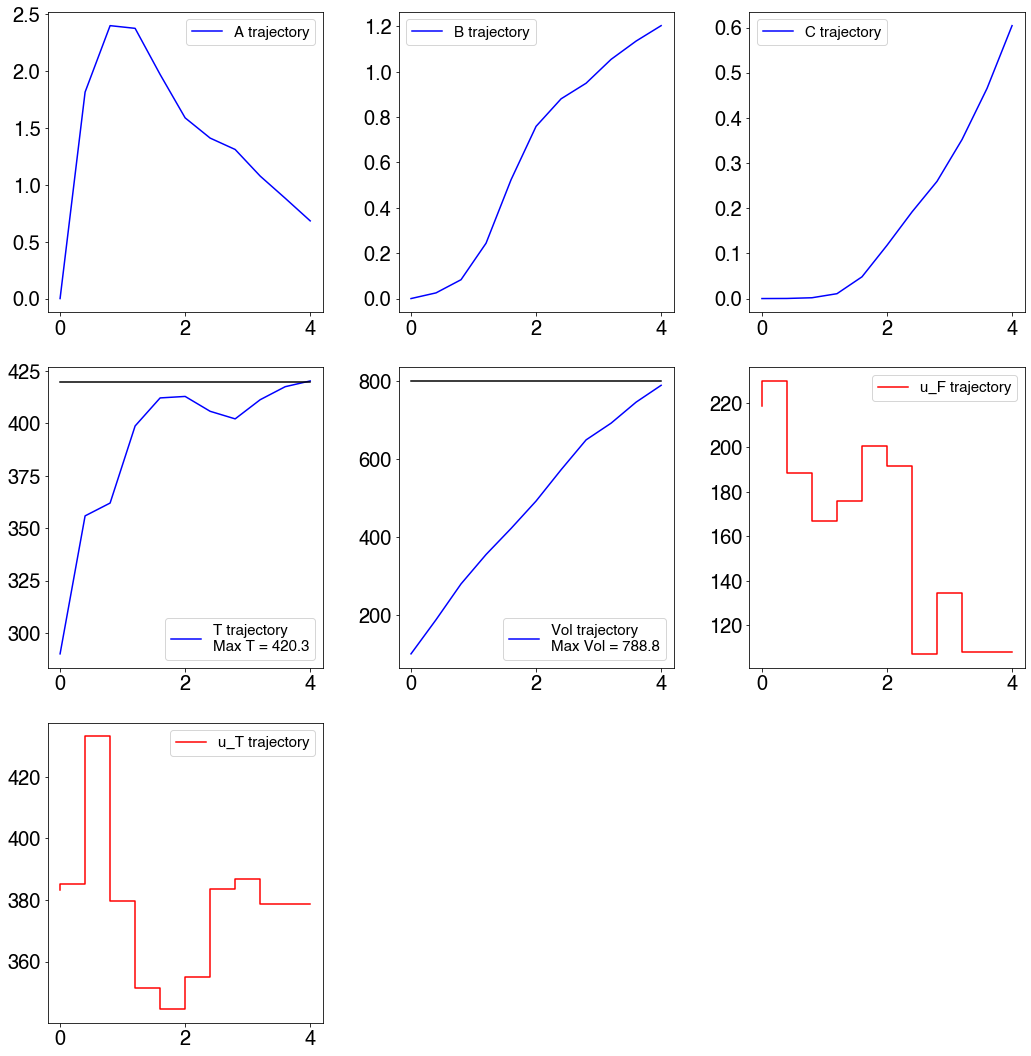

Score: 476.5277179906124


In [443]:
plot_episode(episode)

## Plot state trajectories

In [444]:
# Generate episode pool
episode_pool = []
for i in range(400):
    try:
        episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                           epsilon = 0, 
                                           g1_threshold = a,
                                           g2_threshold = b)]
    except KeyboardInterrupt:
        try:
            episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                               epsilon = 0, 
                                               g1_threshold = a,
                                               g2_threshold = b)]
        except KeyboardInterrupt:
            try:
                episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                               epsilon = 0, 
                                               g1_threshold = a,
                                               g2_threshold = b)]
            except KeyboardInterrupt:
                try:
                    episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                               epsilon = 0, 
                                               g1_threshold = a,
                                               g2_threshold = b)]
                except KeyboardInterrupt:
                    try:
                        episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                               epsilon = 0, 
                                               g1_threshold = a,
                                               g2_threshold = b)]
                    except KeyboardInterrupt:
                        try:
                            episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                               epsilon = 0, 
                                               g1_threshold = a,
                                               g2_threshold = b)]
                        except KeyboardInterrupt:
                            episode_pool += [generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                               epsilon = 0, 
                                               g1_threshold = a,
                                               g2_threshold = b)]

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

No handles with labels found to put in legend.
<ipython-input-56-20cc2e7c17c9>:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,1)
No handles with labels found to put in legend.
<ipython-input-56-20cc2e7c17c9>:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,2)
<ipython-input-56-20cc2e7c17c9>:84: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently r

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

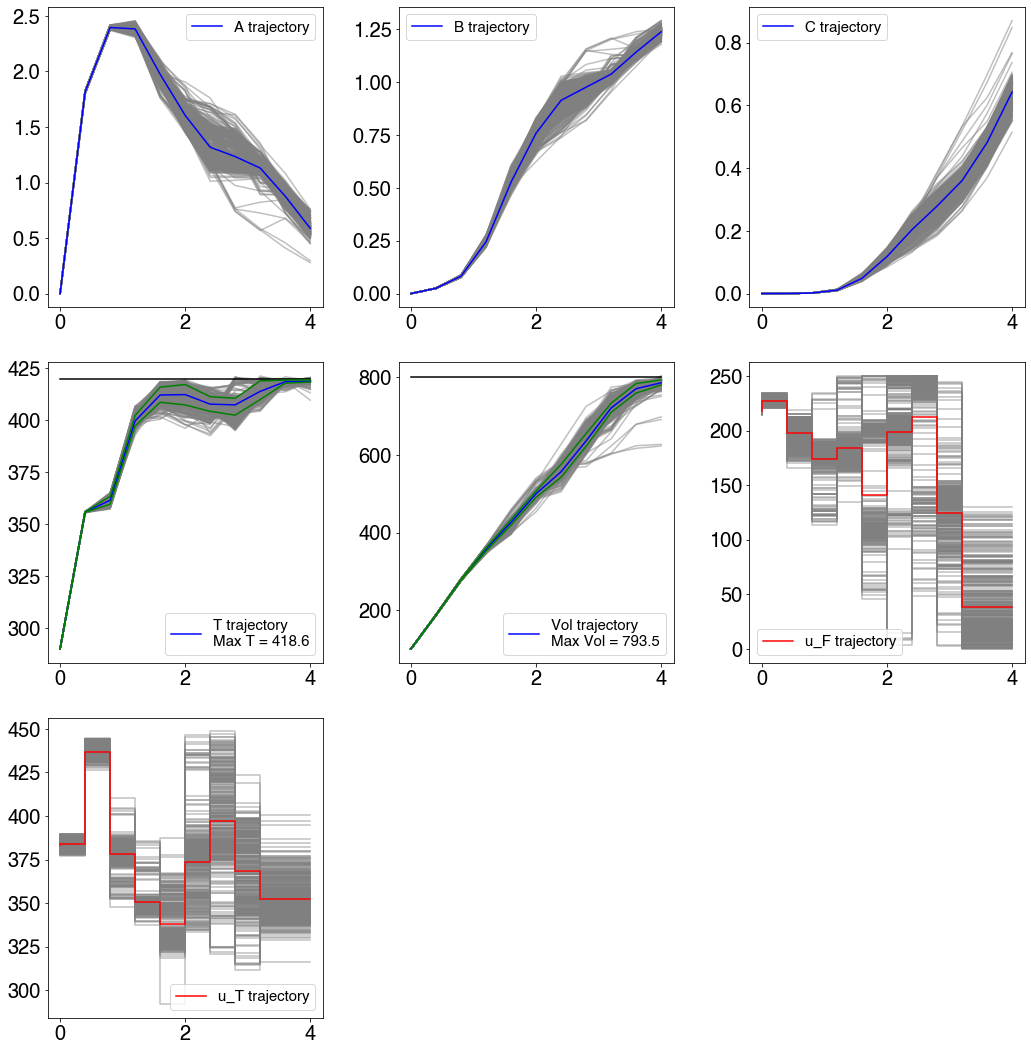

Score: 504.7929947157488
total no. of episodes: 400
episodes that violate g1: 34
episodes that violate g2: 13
episodes that violate both g1 and g2: 1
episodes that violate either g1 or g2: 46


In [445]:
plot_episode_pool(episode_pool)

## Save neural networks

In [449]:
# # Save neural network
# torch.save(Q_net, './NN_models/CS2_Q_net_g1g2_960_ep')
# # Save neural network
# torch.save(g1_net, './NN_models/CS2_g1_net_g1g2_960_ep')
# # Save neural network
# torch.save(g2_net, './NN_models/CS2_g2_net_g1g2_960_ep')

# Load pre-trained neural network
# Q_net = torch.load('./NN_models/CS2_Q_net_g1g2_960_ep')
# Q_net.eval()
# # Load pre-trained neural network
# g1_net = torch.load('./NN_models/CS2_g1_net_g1g2_960_ep')
# g1_net.eval()
# # Load pre-trained neural network
# g2_net = torch.load('./NN_models/CS2_g2_net_g1g2_960_ep')
# g2_net.eval()

## Explore state space

In [451]:
# # Save data to csv
# plotting_state_data.to_csv(r'./Data/CS2_state_space_g1g2_960_ep.csv', index = False)
# # Load data as pd.DataFrame
# plotting_state_data = pd.read_csv('./Data/CS2_state_space_g1g2_960_ep.csv')

In [446]:
# Generate data using random policy
plotting_state_data = []
for i in range(400):
#     initialize_MDP_CDC() # Initialize system
    try:
        episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
    except KeyboardInterrupt:
        try:
            episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
        except KeyboardInterrupt:
            try:
                episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
            except KeyboardInterrupt:
                try:
                    episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
                except KeyboardInterrupt:
                    episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
    data   = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
    for j in data:
        j = j[:-1]
        plotting_state_data += j  # Add datapoints to training set
plotting_state_data = pd.DataFrame(plotting_state_data)
plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[3] - 420 > 0] # Conpath 1
plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[4] - 800 > 0] # Conpath 2
print('No. of states visited:',len(plotting_state_data))
print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))

CC_all  = plotting_state_data[2]
T_all   = plotting_state_data[3]
Vol_all = plotting_state_data[4]

CC_g1  = plotting_state_data_g1_violated[2]
T_g1   = plotting_state_data_g1_violated[3]
Vol_g1 = plotting_state_data_g1_violated[4]

CC_g2  = plotting_state_data_g2_violated[2]
T_g2   = plotting_state_data_g2_violated[3]
Vol_g2 = plotting_state_data_g2_violated[4]

@interact(ns=(-90,90,0.1),ew=(-90,90,0.1))
def interact_poly(ns,ew):
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(CC_all, T_all, Vol_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(CC_g1, T_g1, Vol_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(CC_g2, T_g2, Vol_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('C', labelpad=30)
    plt.ylabel('T', labelpad=50)
    ax.set_zlabel('Vol', fontsize=20, labelpad=20)
    plt.legend()
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    plt.xlim(0,2.5)
    plt.ylim(0,600)
    ax.set_zlim(100, 1000)
    ax.view_init(ns,ew)
    plt.show()

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

No. of states visited: 4400
No. of states where g1 violated: 31
No. of states where g2 violated: 8


interactive(children=(FloatSlider(value=0.0, description='ns', max=90.0, min=-90.0), FloatSlider(value=0.0, de…

## Make gif of evolution of state space

In [452]:
init_g1_threshold = 200
init_g2_threshold = 200
g1_threshold_list = [200]
g2_threshold_list = [200]
for i in range(2000):
    init_g1_threshold *= 0.99
    init_g2_threshold *= 0.99
    g1_threshold_list += [init_g1_threshold]
    g2_threshold_list += [init_g2_threshold]
iteration_list = range(2000)

In [460]:
# SAVING EPISODE BANK - JSON WORKS BUT NOT PICKLE BCOS NESTED LIST
# # open output file for writing
# with open('./Data/CS2_episode_bank_g1g2_960_ep', 'w') as f:
#     json.dump(episode_bank, f)
# # open output file for reading
# with open('./Data/CS2_episode_bank_g1g2_960_ep', 'r') as f:
#     episode_bank = json.load(f)

No. of states visited: 110
No. of states where g1 violated: 100
No. of states where g2 violated: 0


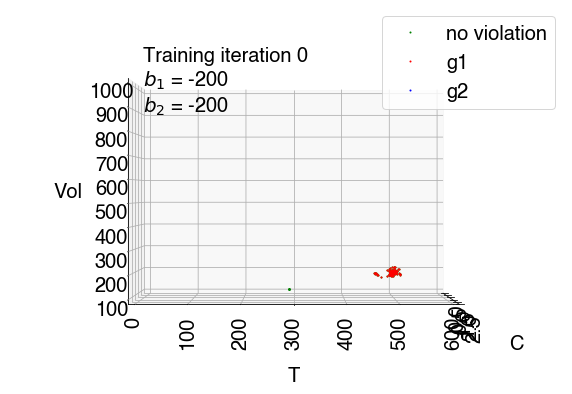

No. of states visited: 110
No. of states where g1 violated: 70
No. of states where g2 violated: 0


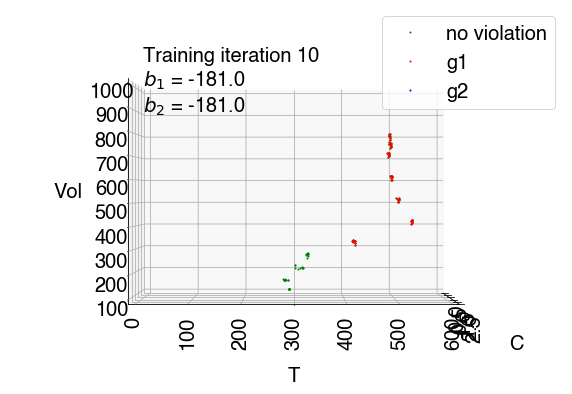

No. of states visited: 110
No. of states where g1 violated: 51
No. of states where g2 violated: 28


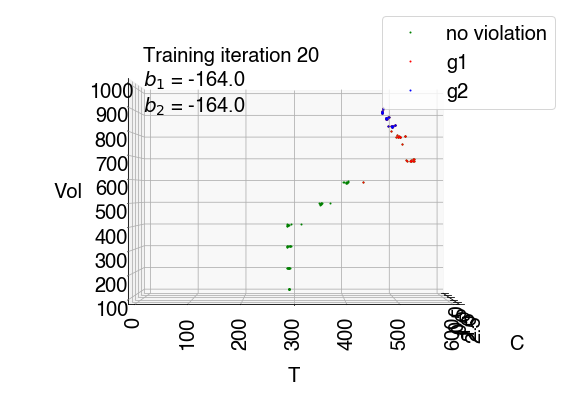

No. of states visited: 110
No. of states where g1 violated: 90
No. of states where g2 violated: 30


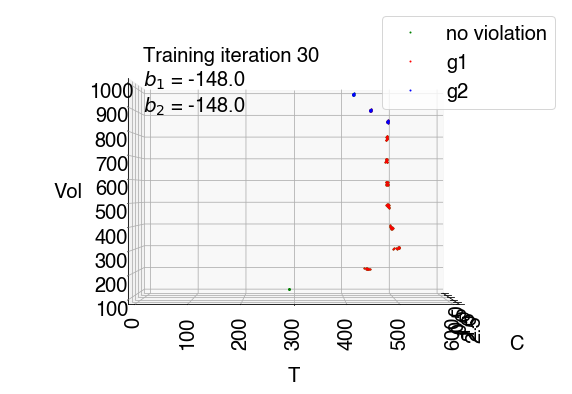

No. of states visited: 110
No. of states where g1 violated: 60
No. of states where g2 violated: 0


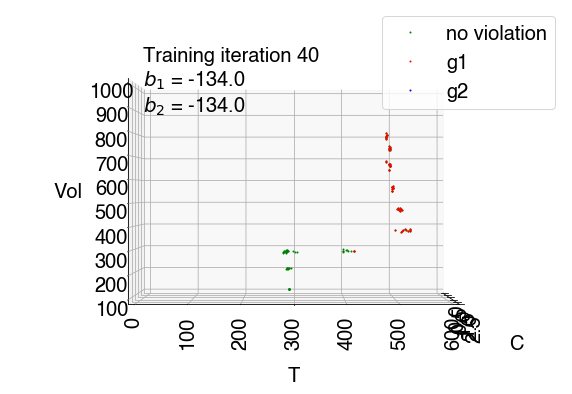

No. of states visited: 110
No. of states where g1 violated: 60
No. of states where g2 violated: 0


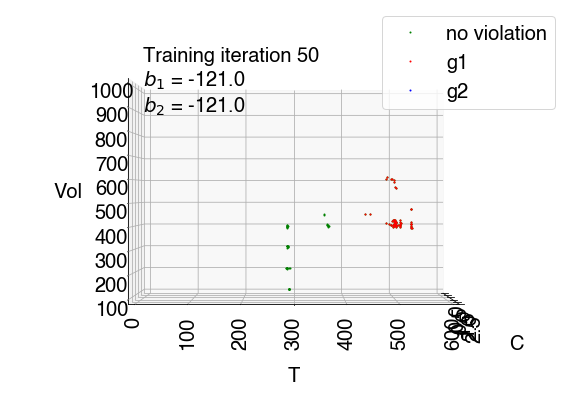

No. of states visited: 110
No. of states where g1 violated: 90
No. of states where g2 violated: 20


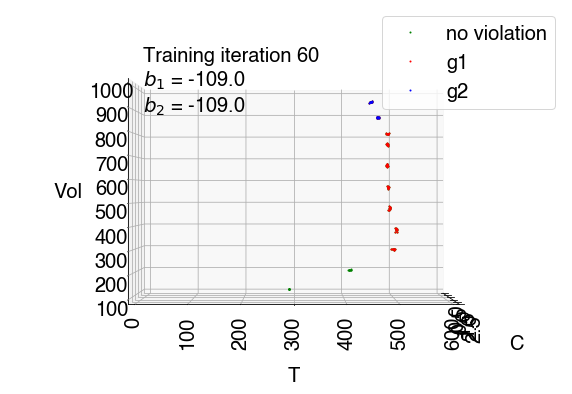

No. of states visited: 110
No. of states where g1 violated: 51
No. of states where g2 violated: 27


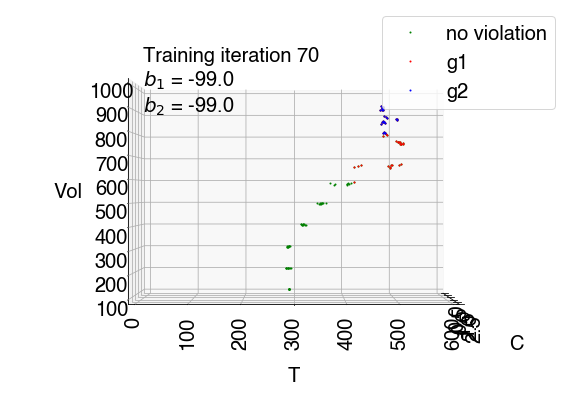

No. of states visited: 110
No. of states where g1 violated: 74
No. of states where g2 violated: 20


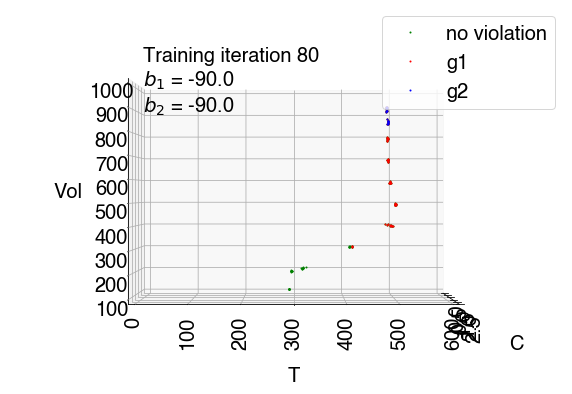

No. of states visited: 110
No. of states where g1 violated: 53
No. of states where g2 violated: 6


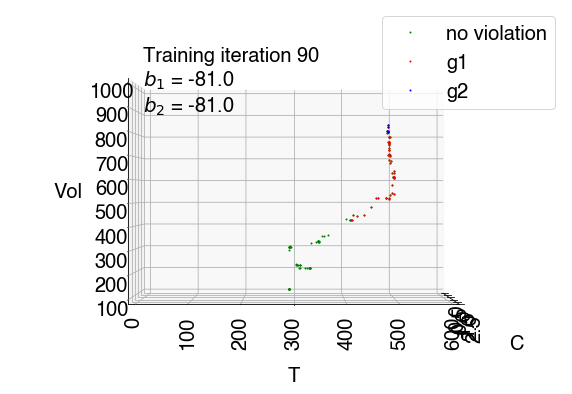

No. of states visited: 110
No. of states where g1 violated: 91
No. of states where g2 violated: 12


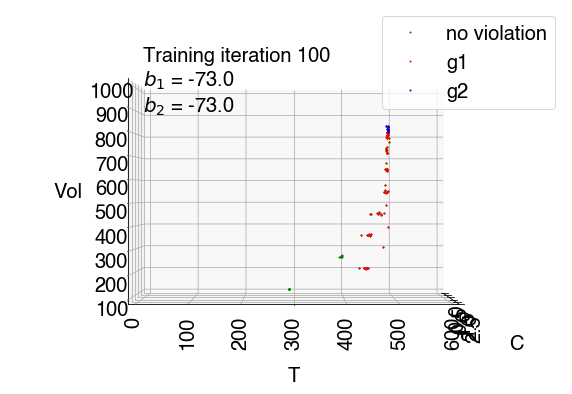

No. of states visited: 110
No. of states where g1 violated: 77
No. of states where g2 violated: 20


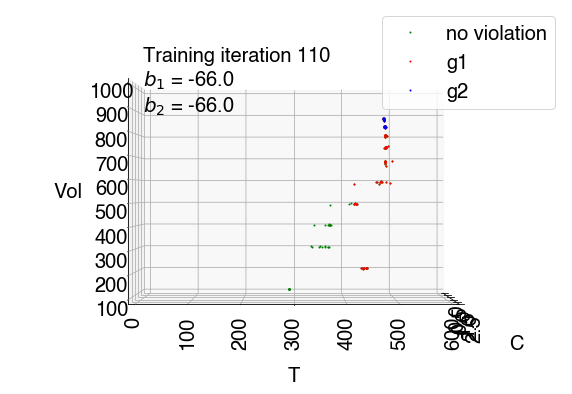

No. of states visited: 110
No. of states where g1 violated: 100
No. of states where g2 violated: 20


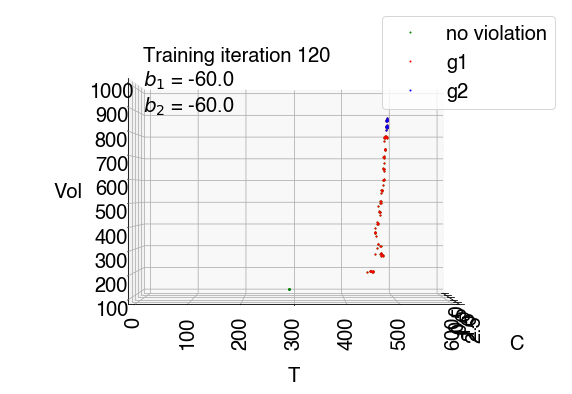

No. of states visited: 110
No. of states where g1 violated: 85
No. of states where g2 violated: 23


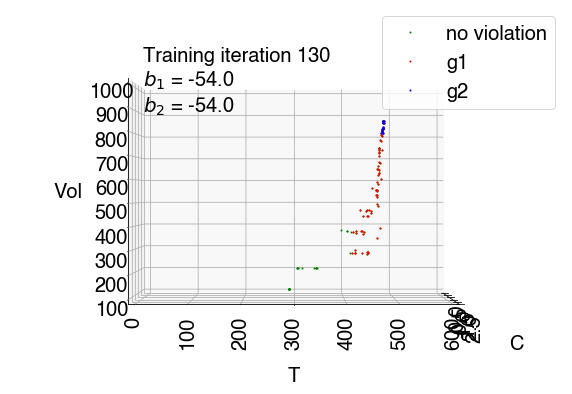

No. of states visited: 99
No. of states where g1 violated: 79
No. of states where g2 violated: 21


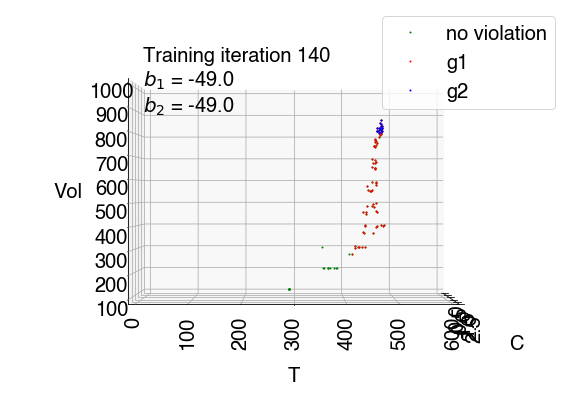

No. of states visited: 110
No. of states where g1 violated: 87
No. of states where g2 violated: 5


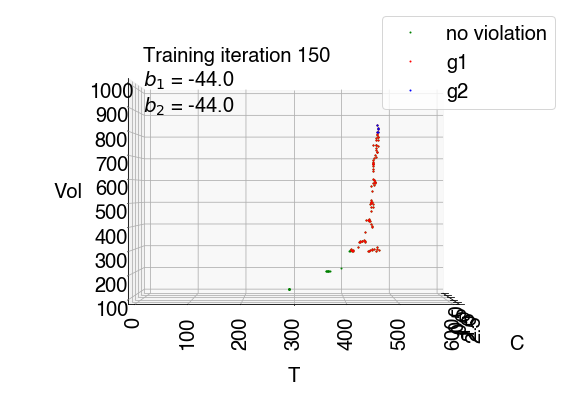

No. of states visited: 110
No. of states where g1 violated: 80
No. of states where g2 violated: 10


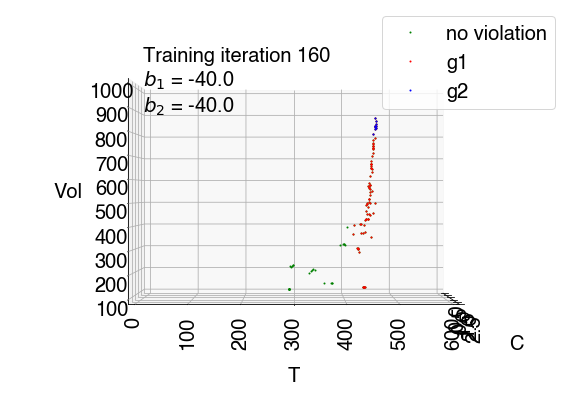

No. of states visited: 110
No. of states where g1 violated: 74
No. of states where g2 violated: 10


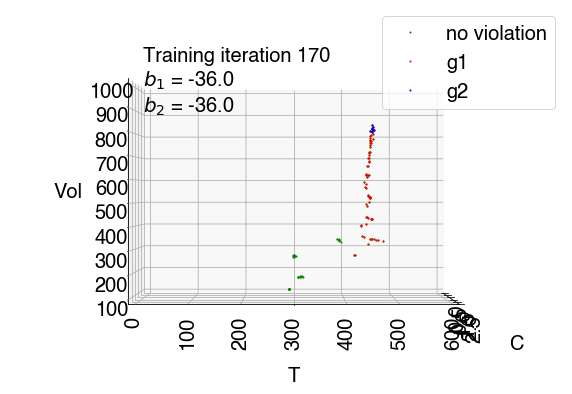

No. of states visited: 110
No. of states where g1 violated: 73
No. of states where g2 violated: 1


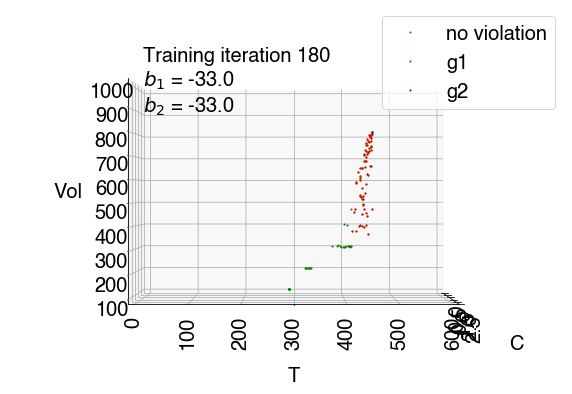

No. of states visited: 110
No. of states where g1 violated: 77
No. of states where g2 violated: 1


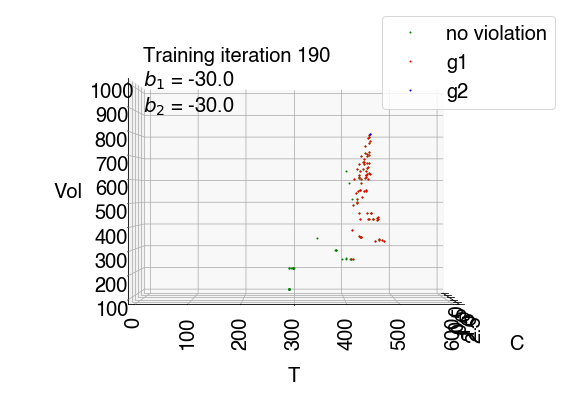

No. of states visited: 110
No. of states where g1 violated: 10
No. of states where g2 violated: 0


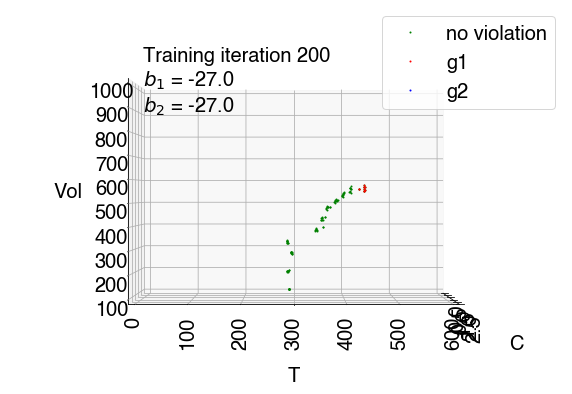

No. of states visited: 110
No. of states where g1 violated: 78
No. of states where g2 violated: 10


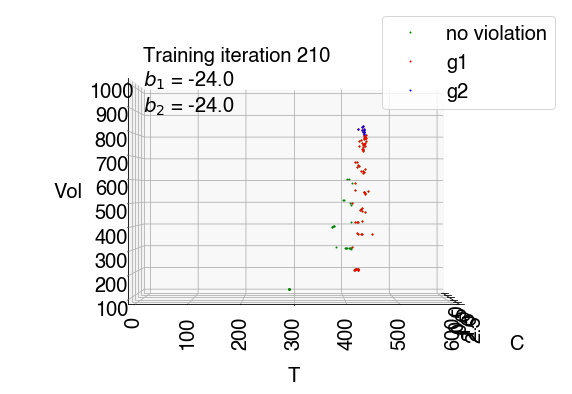

No. of states visited: 110
No. of states where g1 violated: 84
No. of states where g2 violated: 13


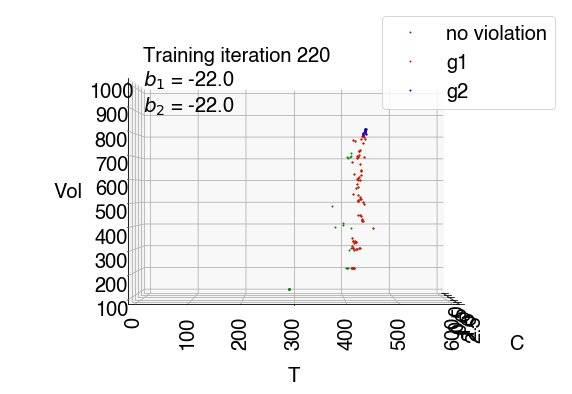

No. of states visited: 110
No. of states where g1 violated: 65
No. of states where g2 violated: 6


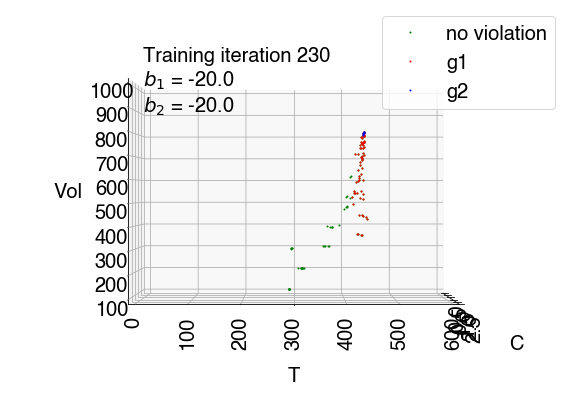

No. of states visited: 110
No. of states where g1 violated: 73
No. of states where g2 violated: 6


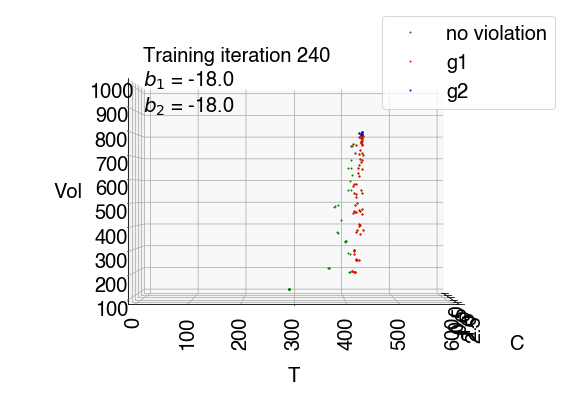

No. of states visited: 110
No. of states where g1 violated: 85
No. of states where g2 violated: 11


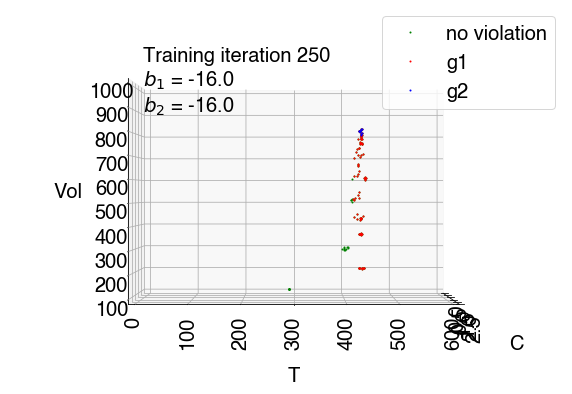

No. of states visited: 110
No. of states where g1 violated: 66
No. of states where g2 violated: 22


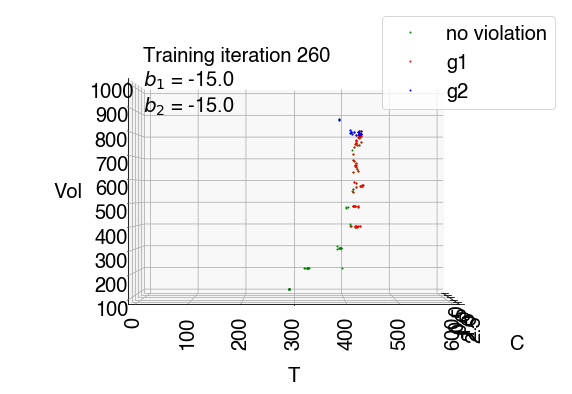

No. of states visited: 110
No. of states where g1 violated: 54
No. of states where g2 violated: 7


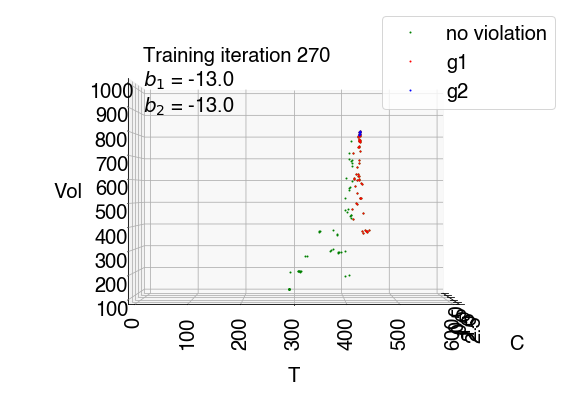

No. of states visited: 99
No. of states where g1 violated: 47
No. of states where g2 violated: 2


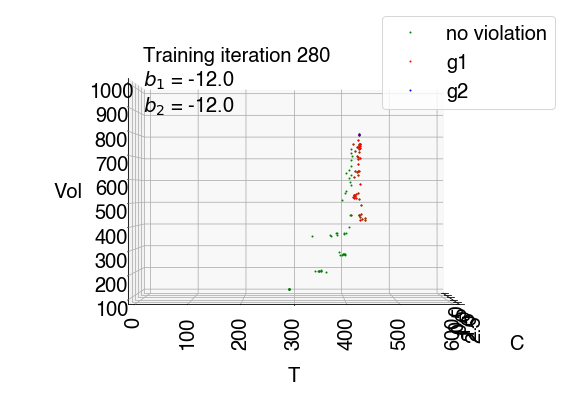

No. of states visited: 110
No. of states where g1 violated: 68
No. of states where g2 violated: 9


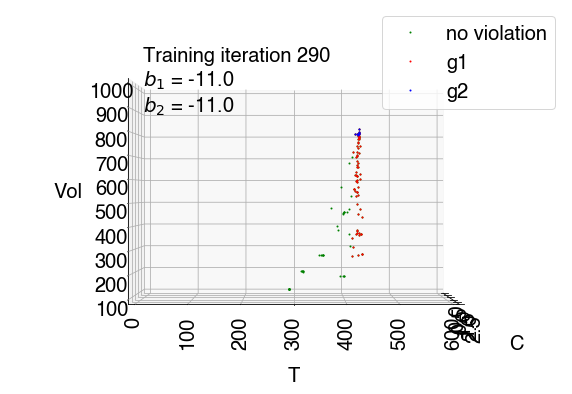

No. of states visited: 110
No. of states where g1 violated: 51
No. of states where g2 violated: 0


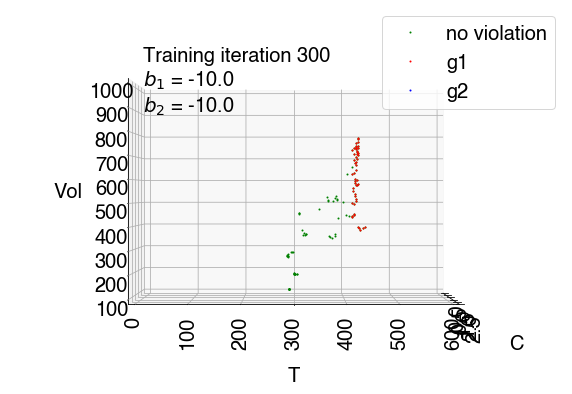

No. of states visited: 110
No. of states where g1 violated: 65
No. of states where g2 violated: 0


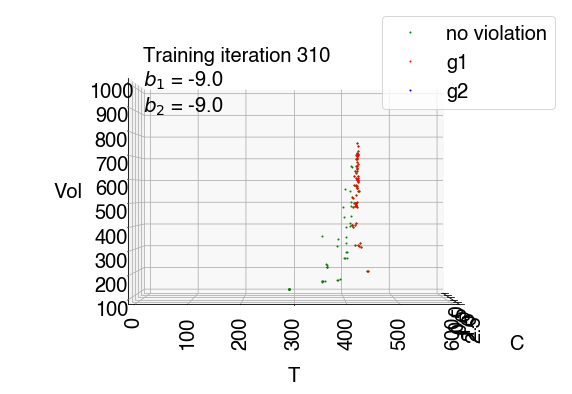

No. of states visited: 110
No. of states where g1 violated: 42
No. of states where g2 violated: 2


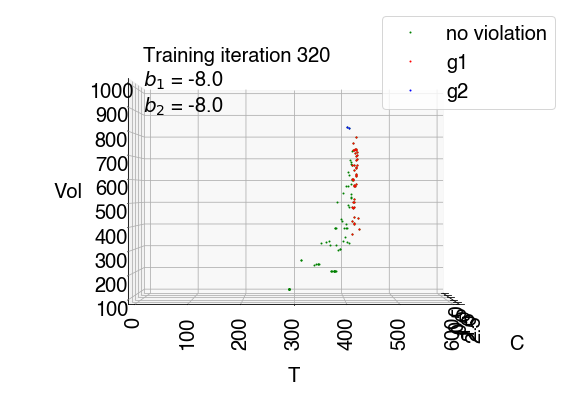

No. of states visited: 110
No. of states where g1 violated: 46
No. of states where g2 violated: 1


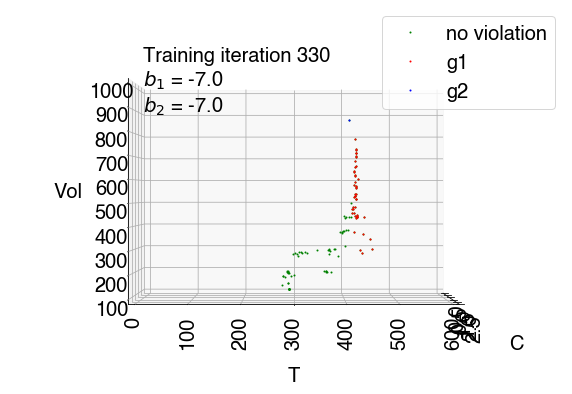

No. of states visited: 110
No. of states where g1 violated: 65
No. of states where g2 violated: 0


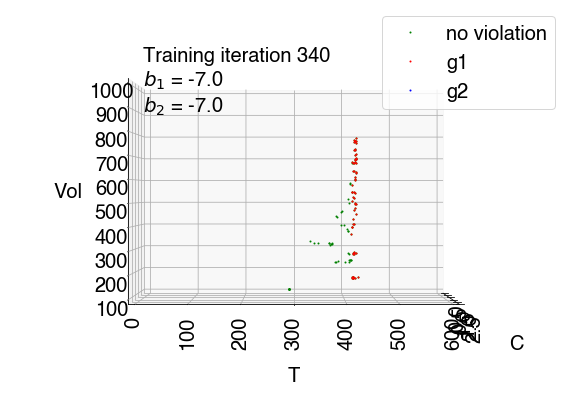

No. of states visited: 110
No. of states where g1 violated: 58
No. of states where g2 violated: 2


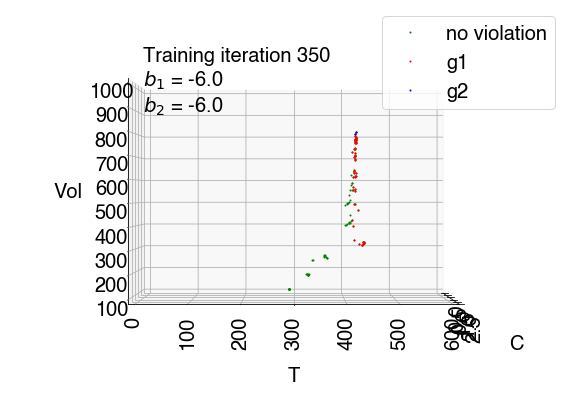

No. of states visited: 110
No. of states where g1 violated: 43
No. of states where g2 violated: 6


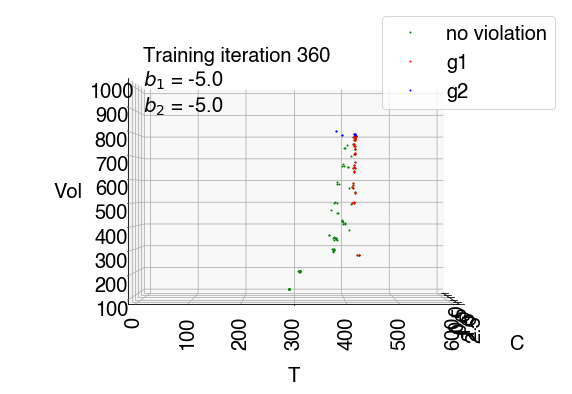

No. of states visited: 110
No. of states where g1 violated: 56
No. of states where g2 violated: 0


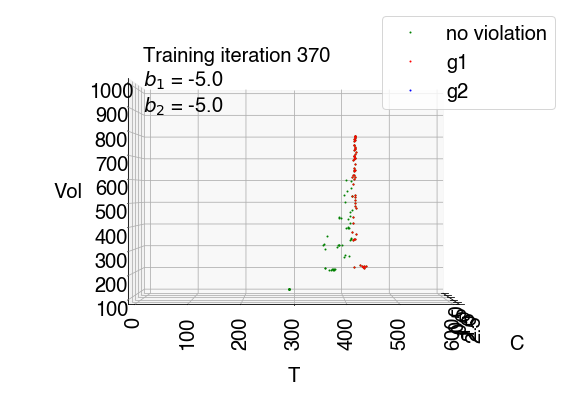

No. of states visited: 110
No. of states where g1 violated: 36
No. of states where g2 violated: 1


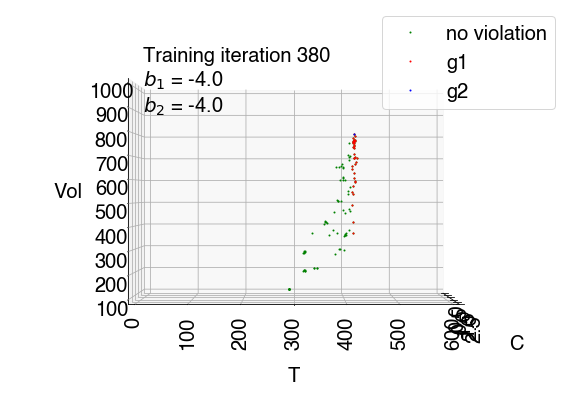

No. of states visited: 110
No. of states where g1 violated: 56
No. of states where g2 violated: 9


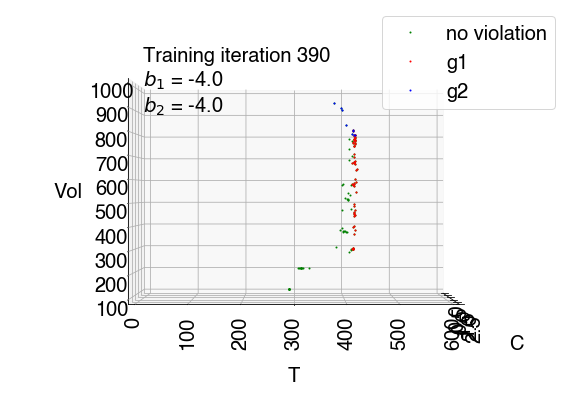

No. of states visited: 110
No. of states where g1 violated: 35
No. of states where g2 violated: 0


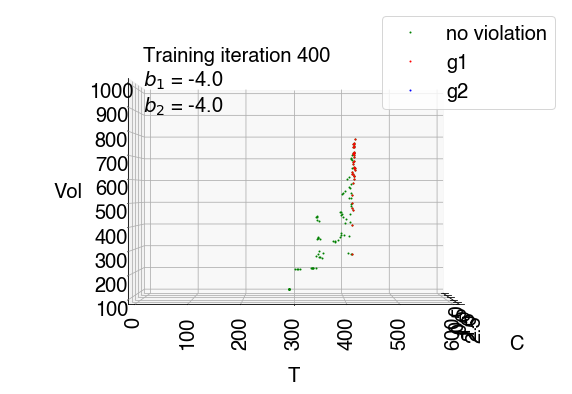

No. of states visited: 110
No. of states where g1 violated: 37
No. of states where g2 violated: 0


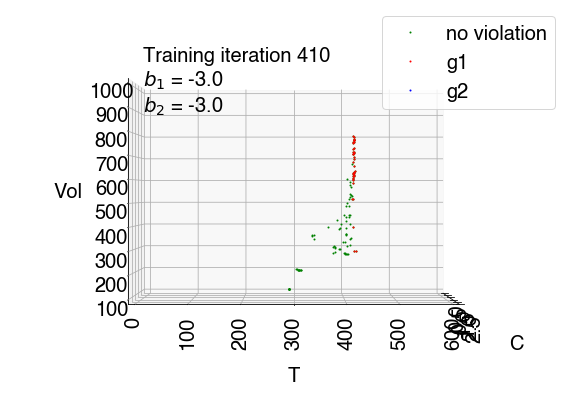

No. of states visited: 110
No. of states where g1 violated: 52
No. of states where g2 violated: 2


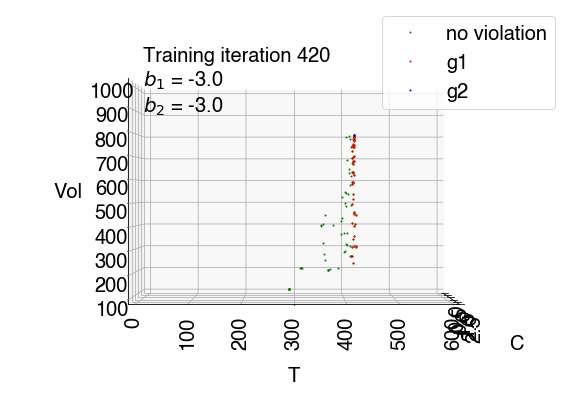

No. of states visited: 110
No. of states where g1 violated: 38
No. of states where g2 violated: 1


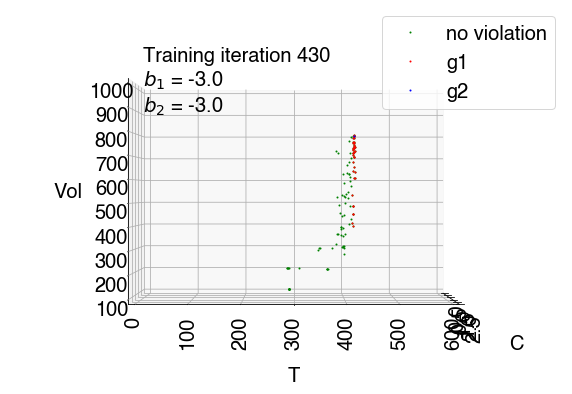

No. of states visited: 110
No. of states where g1 violated: 57
No. of states where g2 violated: 2


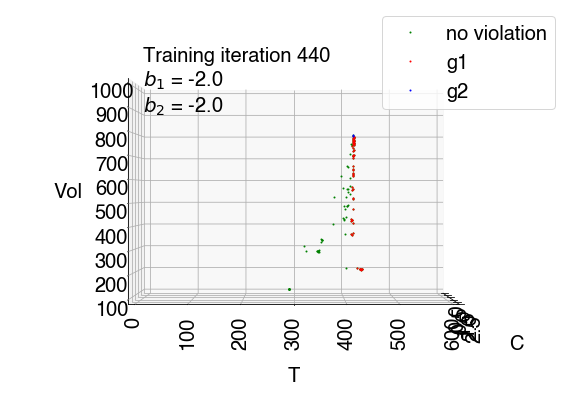

No. of states visited: 110
No. of states where g1 violated: 51
No. of states where g2 violated: 4


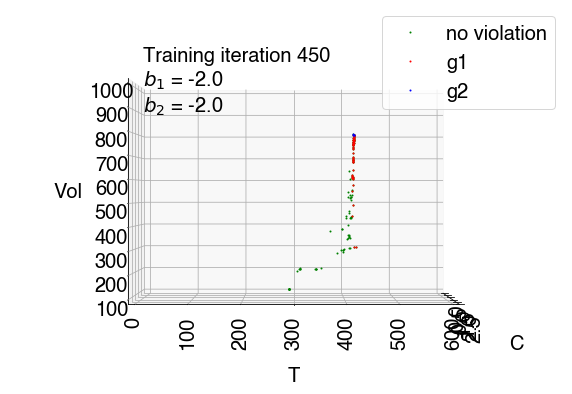

No. of states visited: 110
No. of states where g1 violated: 43
No. of states where g2 violated: 0


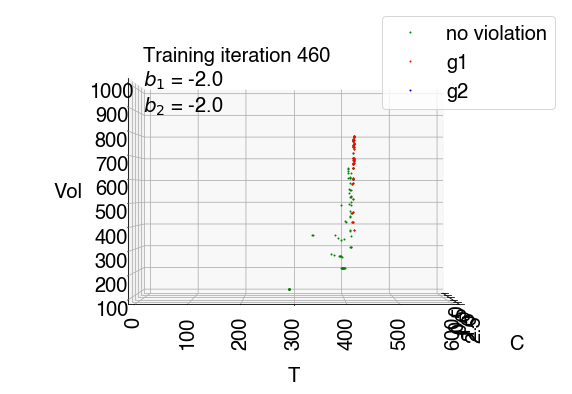

No. of states visited: 110
No. of states where g1 violated: 58
No. of states where g2 violated: 4


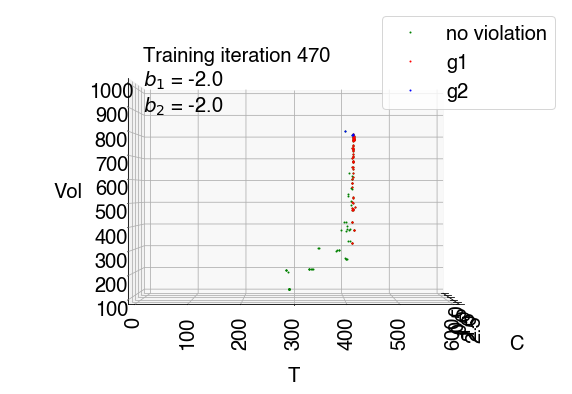

No. of states visited: 110
No. of states where g1 violated: 42
No. of states where g2 violated: 1


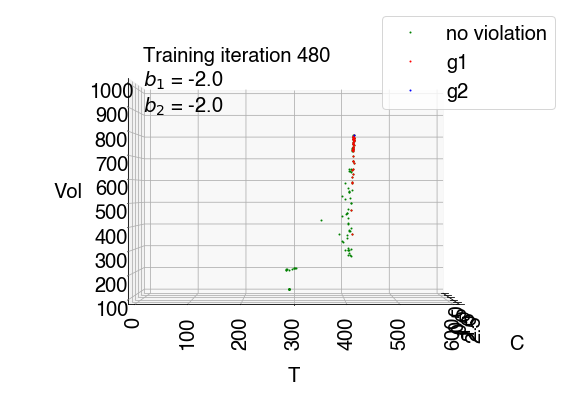

No. of states visited: 110
No. of states where g1 violated: 35
No. of states where g2 violated: 0


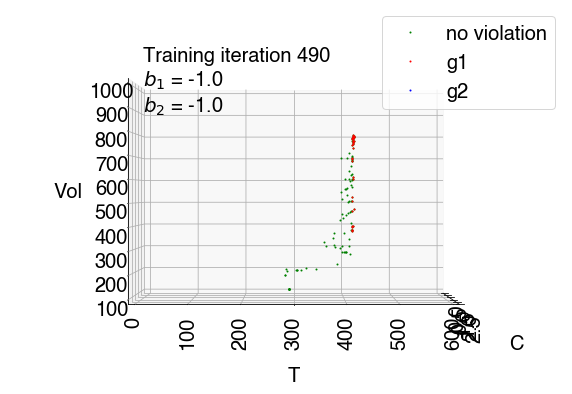

No. of states visited: 110
No. of states where g1 violated: 48
No. of states where g2 violated: 1


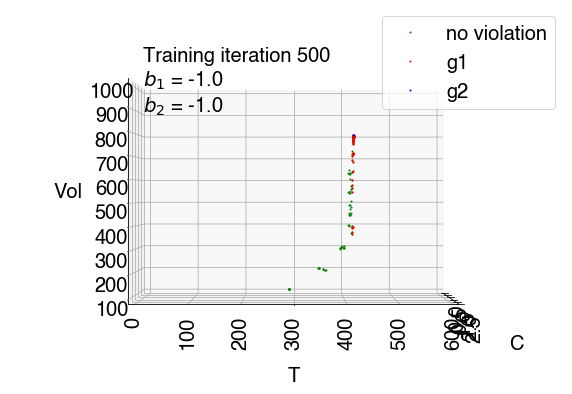

No. of states visited: 110
No. of states where g1 violated: 53
No. of states where g2 violated: 0


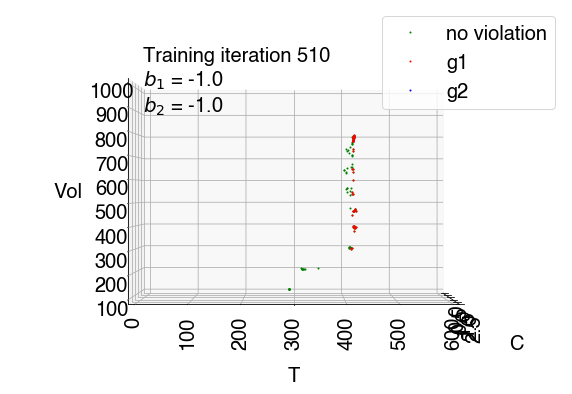

No. of states visited: 110
No. of states where g1 violated: 20
No. of states where g2 violated: 0


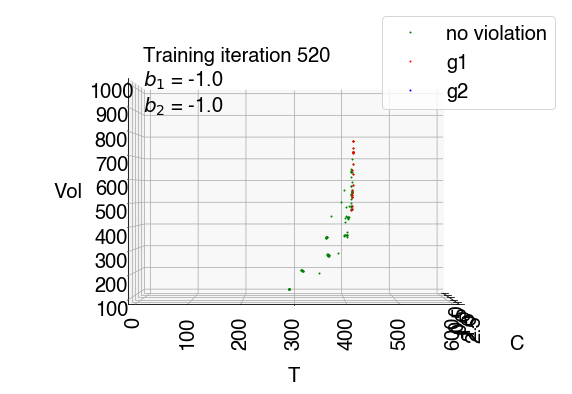

No. of states visited: 110
No. of states where g1 violated: 0
No. of states where g2 violated: 0


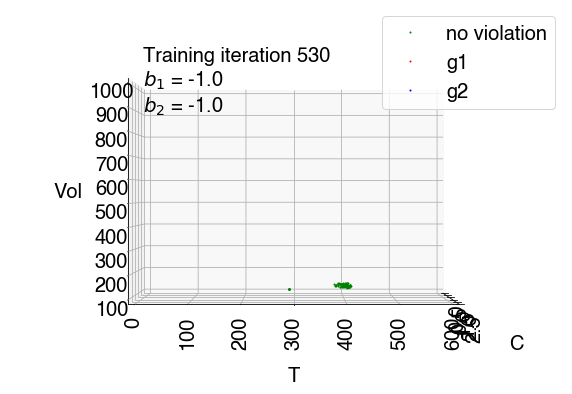

No. of states visited: 110
No. of states where g1 violated: 15
No. of states where g2 violated: 0


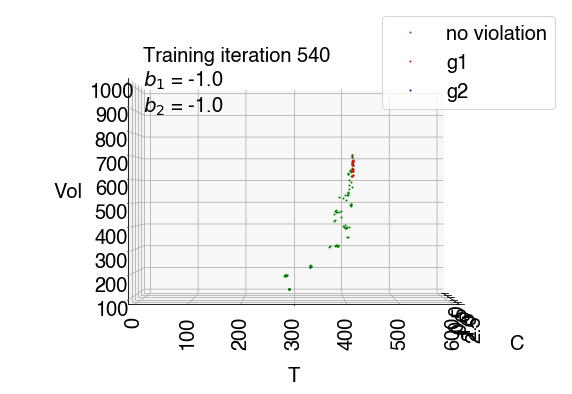

No. of states visited: 110
No. of states where g1 violated: 38
No. of states where g2 violated: 2


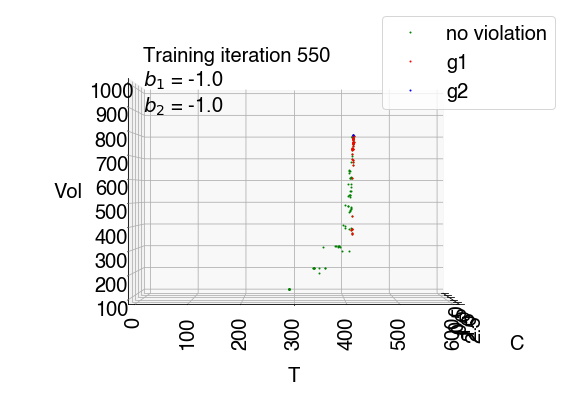

No. of states visited: 110
No. of states where g1 violated: 27
No. of states where g2 violated: 0


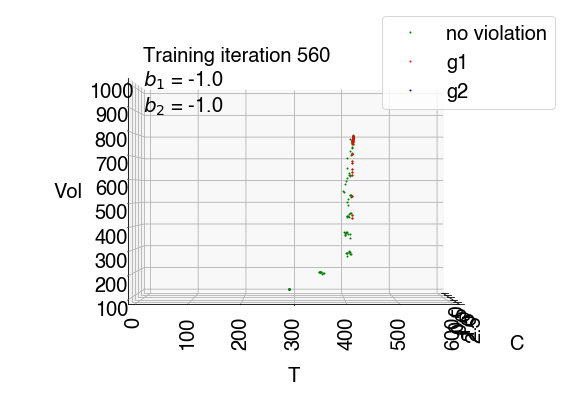

No. of states visited: 110
No. of states where g1 violated: 40
No. of states where g2 violated: 2


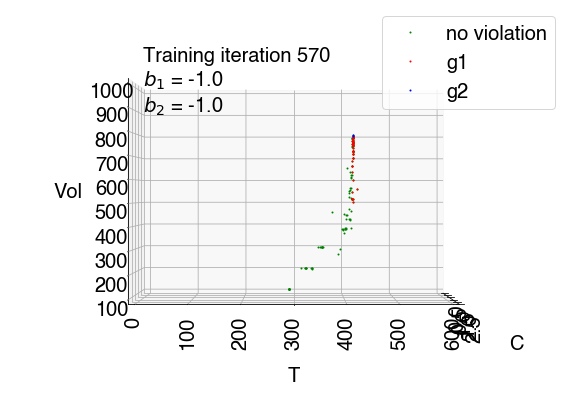

No. of states visited: 110
No. of states where g1 violated: 27
No. of states where g2 violated: 4


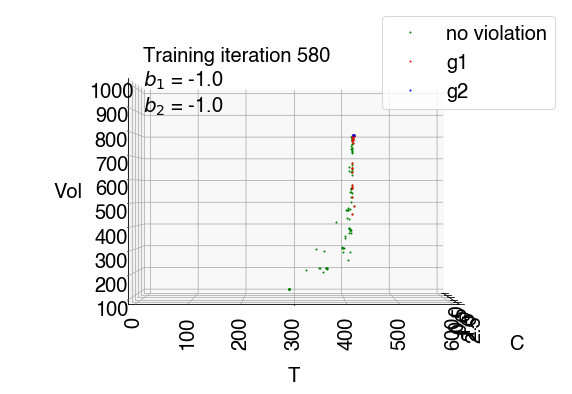

No. of states visited: 99
No. of states where g1 violated: 22
No. of states where g2 violated: 0


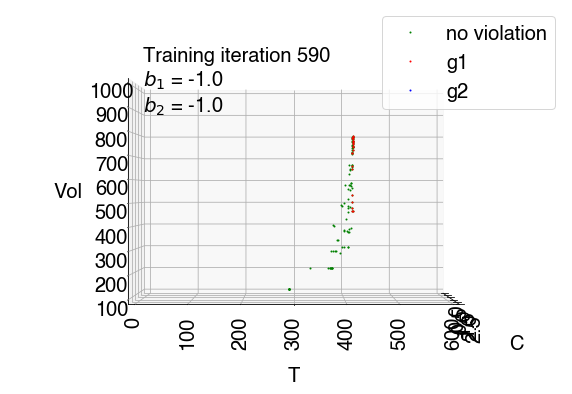

No. of states visited: 110
No. of states where g1 violated: 8
No. of states where g2 violated: 0


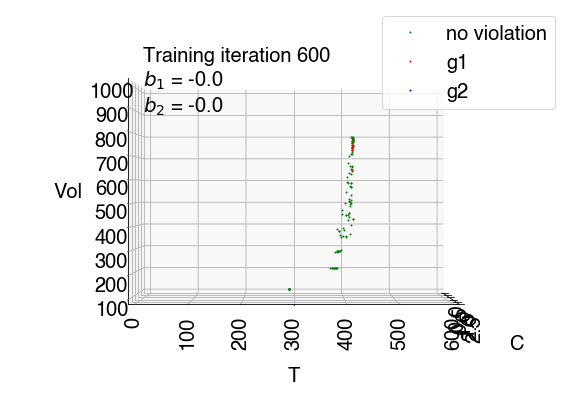

No. of states visited: 110
No. of states where g1 violated: 13
No. of states where g2 violated: 4


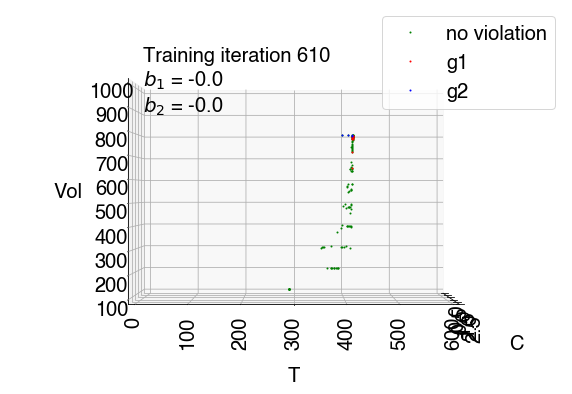

No. of states visited: 110
No. of states where g1 violated: 31
No. of states where g2 violated: 1


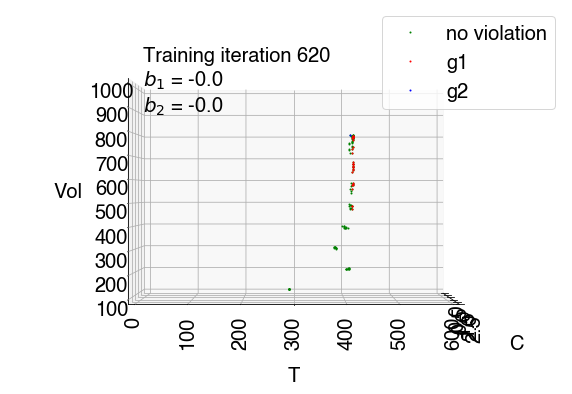

No. of states visited: 110
No. of states where g1 violated: 23
No. of states where g2 violated: 0


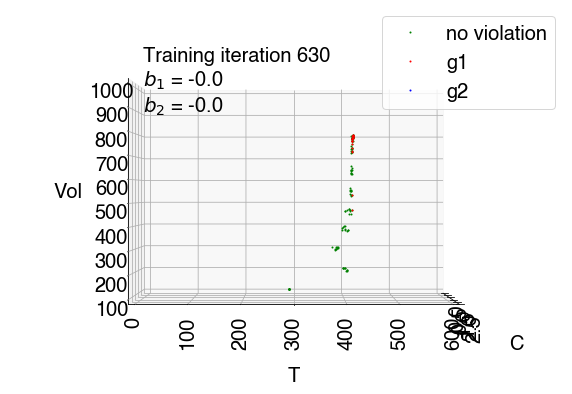

No. of states visited: 110
No. of states where g1 violated: 20
No. of states where g2 violated: 2


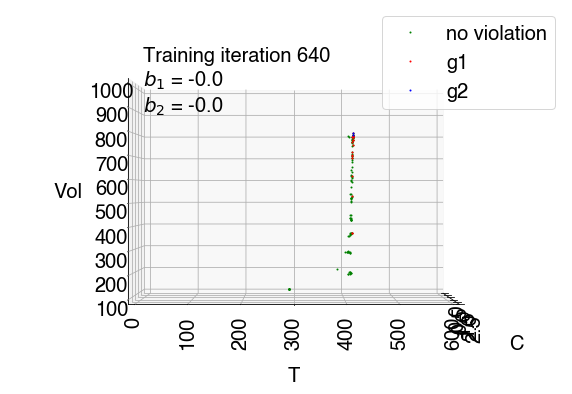

No. of states visited: 110
No. of states where g1 violated: 15
No. of states where g2 violated: 7


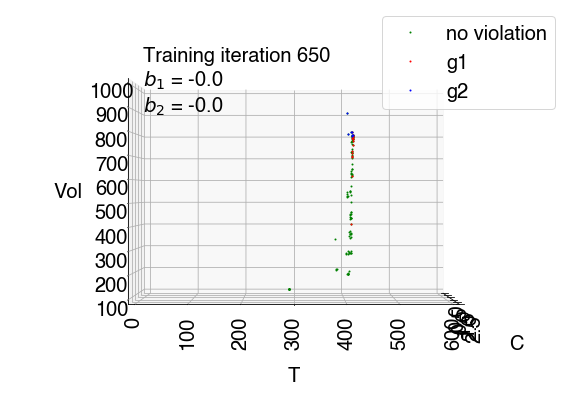

No. of states visited: 110
No. of states where g1 violated: 16
No. of states where g2 violated: 0


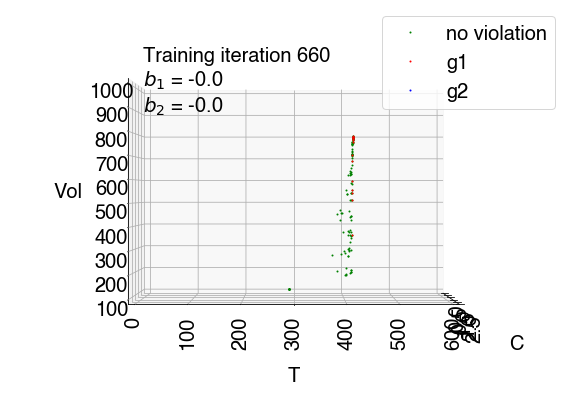

No. of states visited: 110
No. of states where g1 violated: 34
No. of states where g2 violated: 4


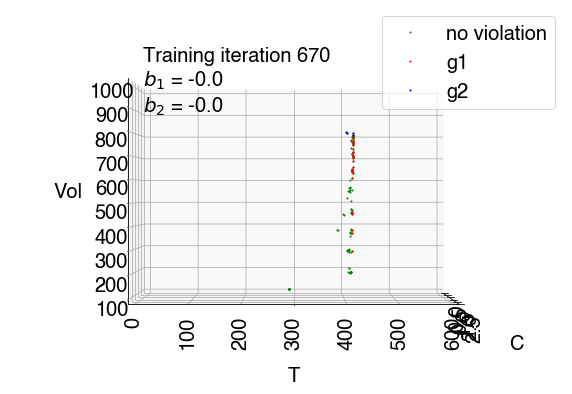

No. of states visited: 110
No. of states where g1 violated: 24
No. of states where g2 violated: 2


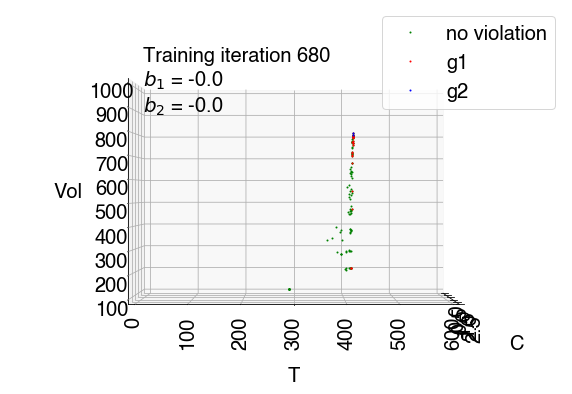

No. of states visited: 110
No. of states where g1 violated: 14
No. of states where g2 violated: 1


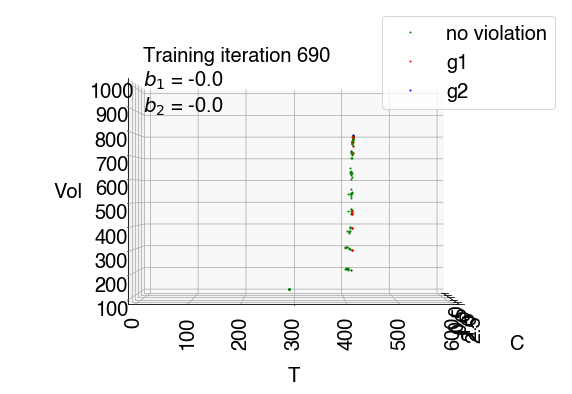

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 0


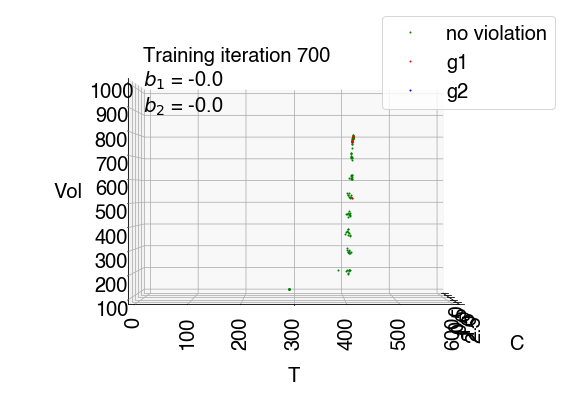

No. of states visited: 110
No. of states where g1 violated: 17
No. of states where g2 violated: 3


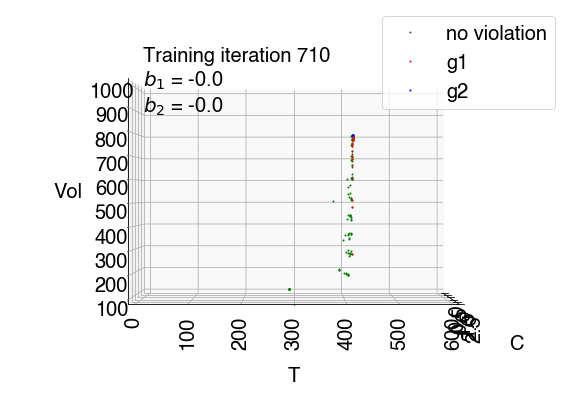

No. of states visited: 110
No. of states where g1 violated: 14
No. of states where g2 violated: 1


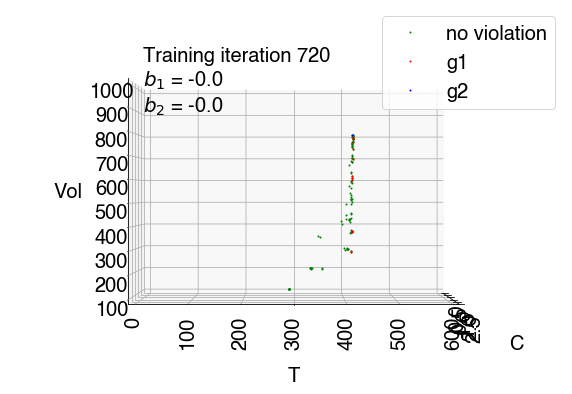

No. of states visited: 110
No. of states where g1 violated: 8
No. of states where g2 violated: 4


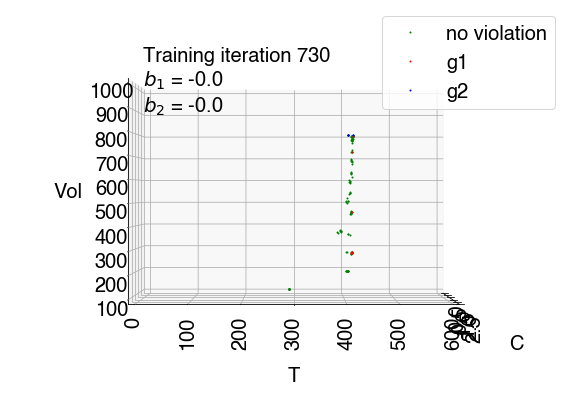

No. of states visited: 110
No. of states where g1 violated: 9
No. of states where g2 violated: 1


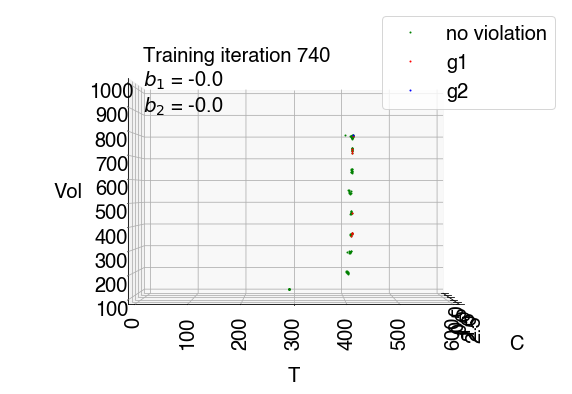

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 0


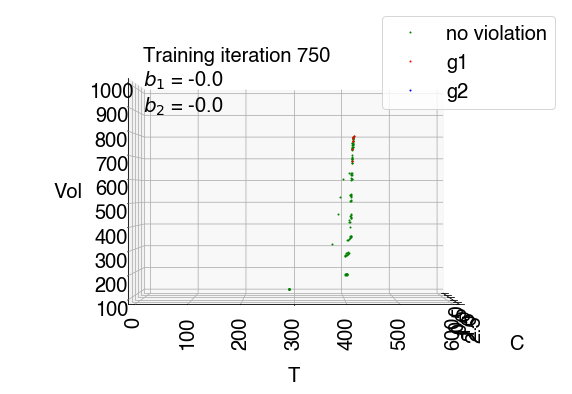

No. of states visited: 110
No. of states where g1 violated: 14
No. of states where g2 violated: 0


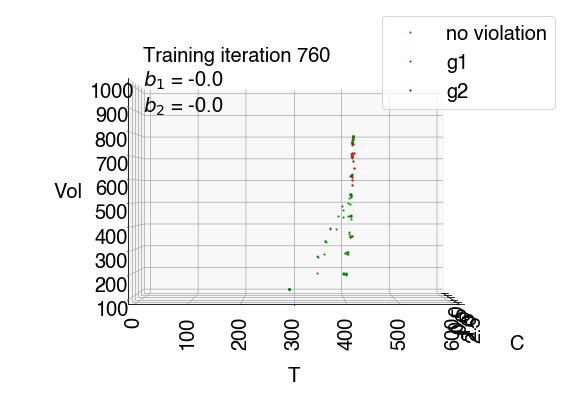

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 7


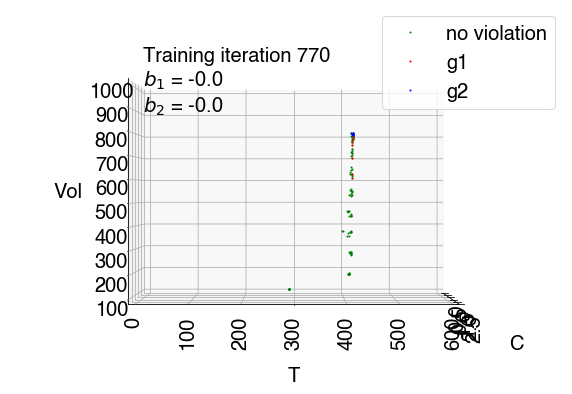

No. of states visited: 110
No. of states where g1 violated: 17
No. of states where g2 violated: 1


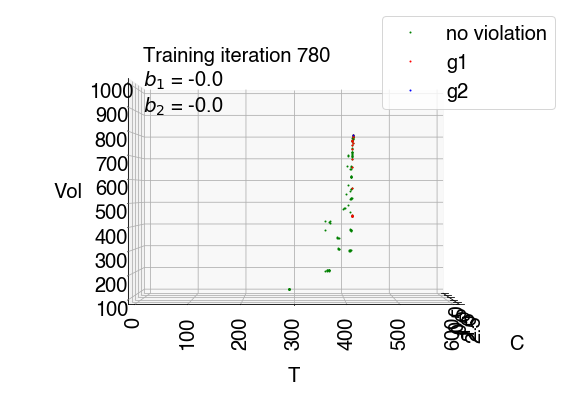

No. of states visited: 99
No. of states where g1 violated: 5
No. of states where g2 violated: 2


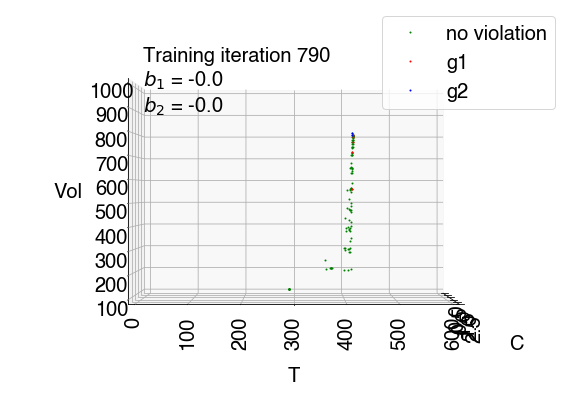

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 0


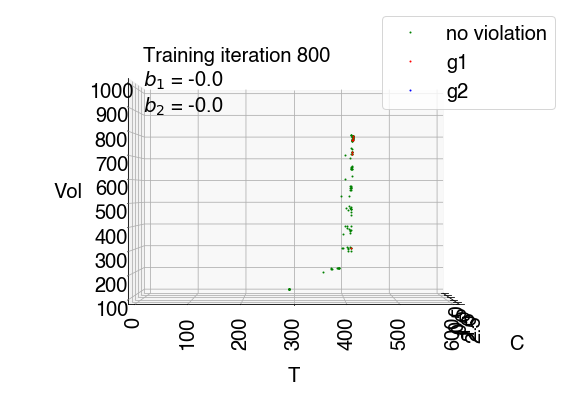

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 0


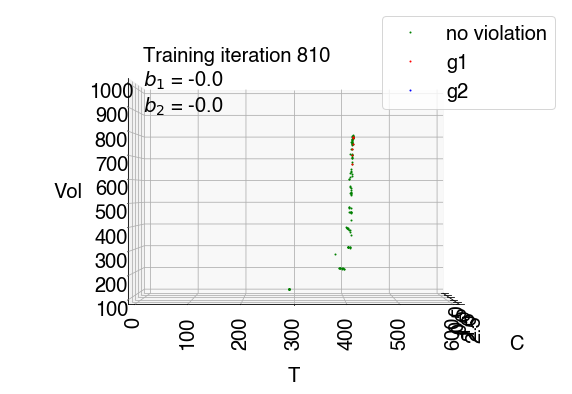

No. of states visited: 110
No. of states where g1 violated: 6
No. of states where g2 violated: 0


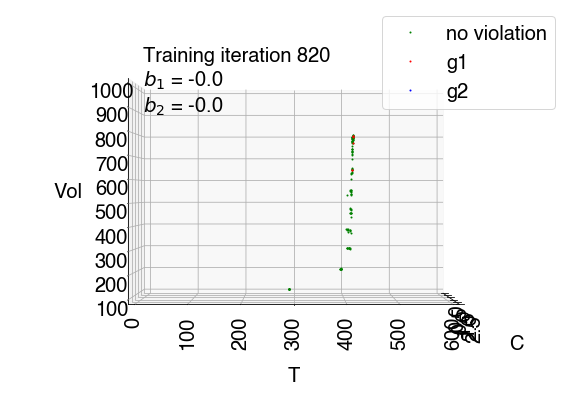

No. of states visited: 110
No. of states where g1 violated: 23
No. of states where g2 violated: 6


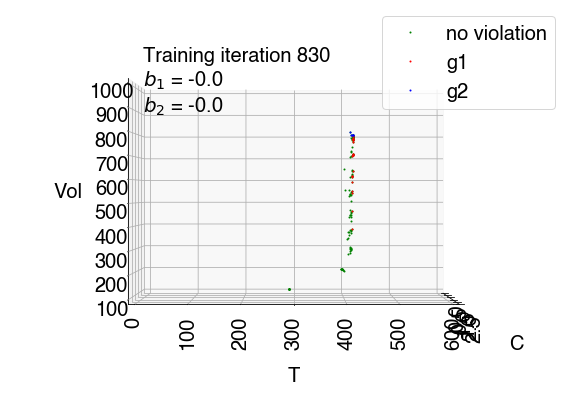

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 3


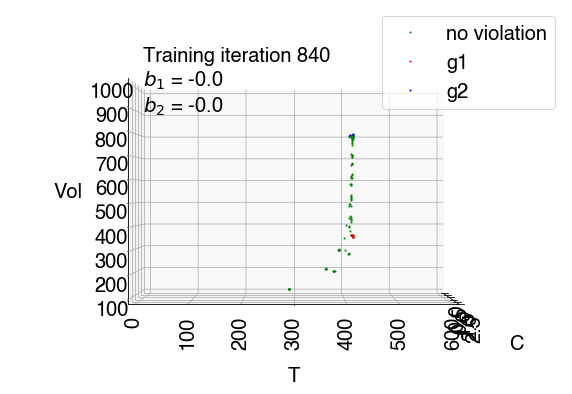

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 0


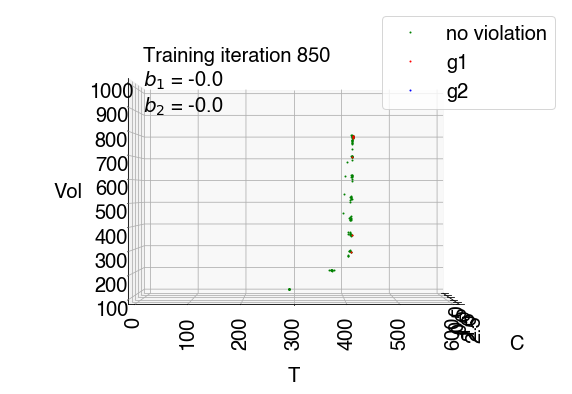

No. of states visited: 110
No. of states where g1 violated: 8
No. of states where g2 violated: 1


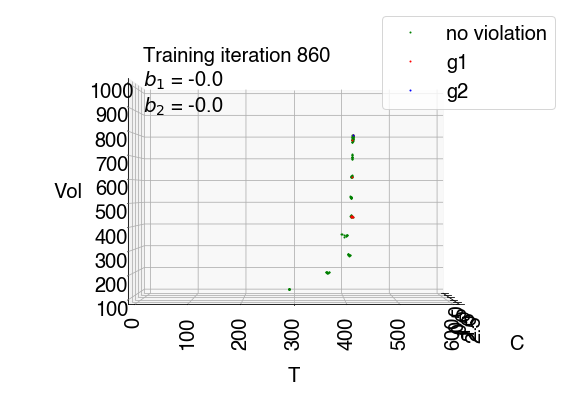

No. of states visited: 110
No. of states where g1 violated: 15
No. of states where g2 violated: 1


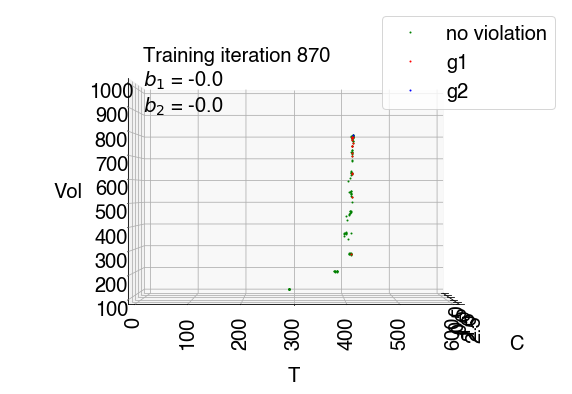

No. of states visited: 110
No. of states where g1 violated: 24
No. of states where g2 violated: 3


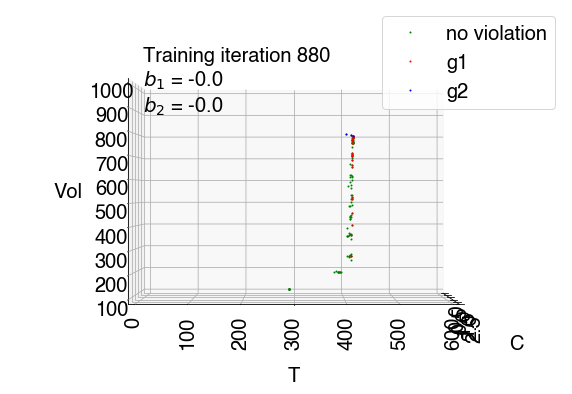

No. of states visited: 110
No. of states where g1 violated: 8
No. of states where g2 violated: 0


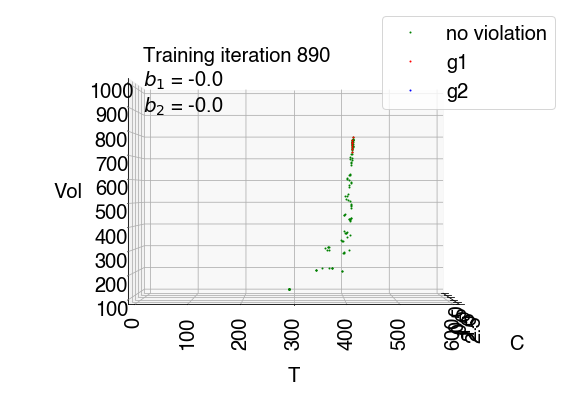

No. of states visited: 110
No. of states where g1 violated: 4
No. of states where g2 violated: 5


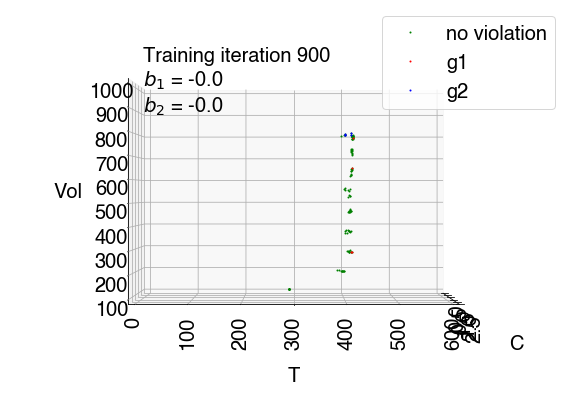

No. of states visited: 110
No. of states where g1 violated: 7
No. of states where g2 violated: 1


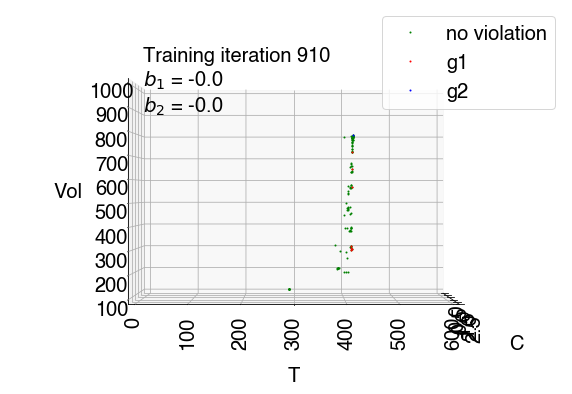

No. of states visited: 110
No. of states where g1 violated: 12
No. of states where g2 violated: 0


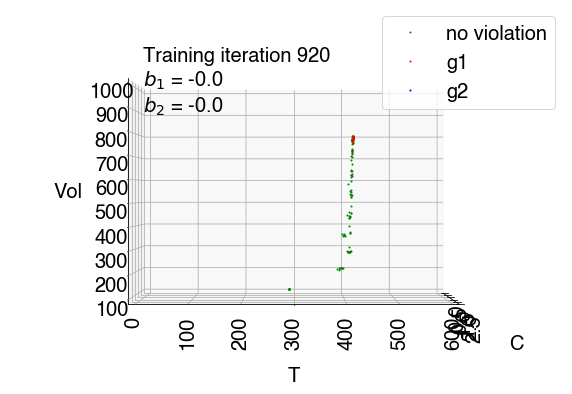

No. of states visited: 110
No. of states where g1 violated: 16
No. of states where g2 violated: 0


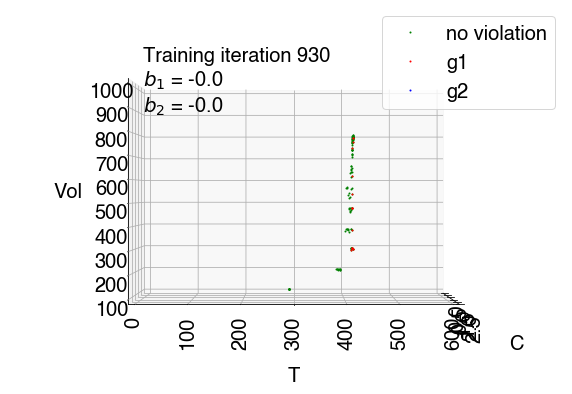

No. of states visited: 110
No. of states where g1 violated: 5
No. of states where g2 violated: 0


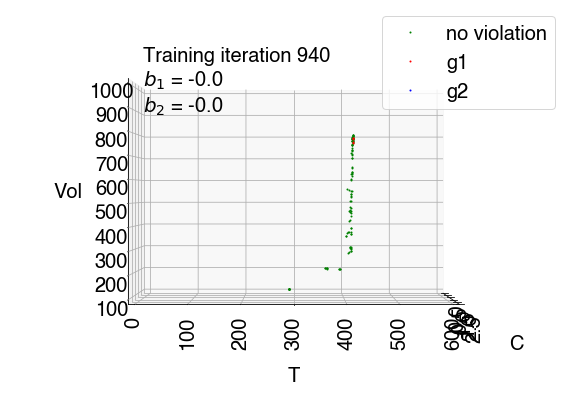

No. of states visited: 110
No. of states where g1 violated: 6
No. of states where g2 violated: 3


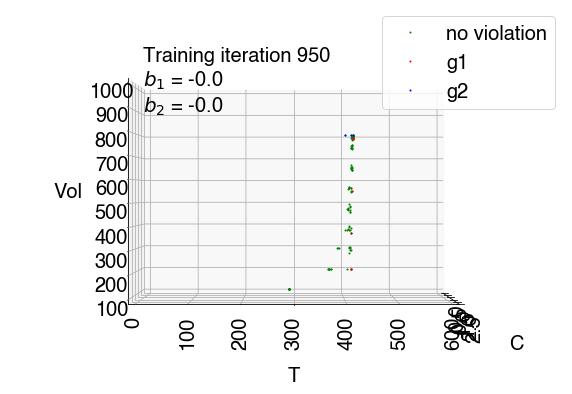

In [459]:
# Plot episode bank 
my_images = []  # For saving into gif

for i in range(len(episode_bank)): # i is the index for iteration
    plotting_state_data = []
    
    for j in range(len(episode_bank[i])): # j is the index for different episodes
        episode = episode_bank[i][j]

        data = extract_data_from_episode(episode, discount_factor = 0.9)   # Extract datapoint from episode
        for z in data:
            z = z[:-1]
            plotting_state_data += z  # Add datapoints to training set
    iteration = iteration_list[::10][i] # Record training iteration
    g1_threshold = g1_threshold_list[::10][i] # Record g1_threshold
    g2_threshold = g2_threshold_list[::10][i] # Record g2_threshold
    # plotting_state_data
    plotting_state_data = pd.DataFrame(plotting_state_data)
    plotting_state_data_g1_violated = plotting_state_data[plotting_state_data[3] - 420 > 0] # Conpath 1
    plotting_state_data_g2_violated = plotting_state_data[plotting_state_data[4] - 800 > 0] # Conpath 2
    print('No. of states visited:',len(plotting_state_data))
    print('No. of states where g1 violated:',len(plotting_state_data_g1_violated))
    print('No. of states where g2 violated:',len(plotting_state_data_g2_violated))

    CC_all  = plotting_state_data[2]
    T_all   = plotting_state_data[3]
    Vol_all = plotting_state_data[4]

    CC_g1  = plotting_state_data_g1_violated[2]
    T_g1   = plotting_state_data_g1_violated[3]
    Vol_g1 = plotting_state_data_g1_violated[4]

    CC_g2  = plotting_state_data_g2_violated[2]
    T_g2   = plotting_state_data_g2_violated[3]
    Vol_g2 = plotting_state_data_g2_violated[4]

    
    fig = plt.figure(figsize = (10,7))
    ax = plt.axes(projection='3d')

    # Data for a three-dimensional line
    ax.plot3D(CC_all, T_all, Vol_all, 'g', label = 'no violation', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(CC_g1, T_g1, Vol_g1, 'r', label = 'g1', linestyle = '', marker = 'o', markersize = 1)
    ax.plot3D(CC_g2, T_g2, Vol_g2, 'b', label = 'g2', linestyle = '', marker = 'o', markersize = 1)
    plt.xlabel('C', labelpad=30)
    plt.ylabel('T', labelpad=50)
    ax.set_zlabel('Vol', fontsize=20, labelpad=20)
    plt.legend(loc = 'upper right')
    plt.xticks(rotation=90)
    plt.yticks(rotation=90)
    plt.xlim(0,2.5)
    plt.ylim(0,600)
    ax.set_zlim(100, 1000)
    ax.text(1.25,0,900,'Training iteration {} \n$b_1$ = {} \n$b_2$ = {}'.format(iteration, -1*round(g1_threshold,0), -1*round(g2_threshold,0)),None)
    ax.view_init(0,0)
    plt.show()
        
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    my_images.append(image)

# save images as a gif    
imageio.mimsave('./Data/CS2_training_g1g2_960_ep.gif', my_images, fps=6)

## Distribution of objective value

In [538]:
# # Save data
# with open('./Data/CS2_obj_dist_g1g2_960_ep', 'wb') as f:
#     pickle.dump(scores, f, pickle.HIGHEST_PROTOCOL)
# Load data
# with open('./Data/CS2_obj_dist_g1g2_960_ep', 'rb') as f:
#     scores = pickle.load(f)

In [531]:
# Score policy using 400 MC episodes
scores = []
for i in range(400):
    try:
        score = score_NN_policy(GA_optimize_constrained, 
                                            initial_state = [0., 0., 0., 290., 100., 0], 
                                            num_iterations = 1, 
                                            get_control = False, 
                                            g1_threshold = a,
                                            g2_threshold = b)
    except KeyboardInterrupt:
        try:
            score = score_NN_policy(GA_optimize_constrained, 
                                            initial_state = [0., 0., 0., 290., 100., 0], 
                                            num_iterations = 1, 
                                            get_control = False, 
                                            g1_threshold = a,
                                            g2_threshold = b)
        except KeyboardInterrupt:
            try:
                score = score_NN_policy(GA_optimize_constrained, 
                                            initial_state = [0., 0., 0., 290., 100., 0], 
                                            num_iterations = 1, 
                                            get_control = False, 
                                            g1_threshold = a,
                                            g2_threshold = b)
            except KeyboardInterrupt:
                try:
                    score = score_NN_policy(GA_optimize_constrained, 
                                            initial_state = [0., 0., 0., 290., 100., 0], 
                                            num_iterations = 1, 
                                            get_control = False, 
                                            g1_threshold = a,
                                            g2_threshold = b)
                except KeyboardInterrupt:
                    score = score_NN_policy(GA_optimize_constrained, 
                                            initial_state = [0., 0., 0., 290., 100., 0], 
                                            num_iterations = 1, 
                                            get_control = False, 
                                            g1_threshold = a,
                                            g2_threshold = b)
    scores += [score] # append score

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@score_NN_policy TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


No handles with labels found to put in legend.


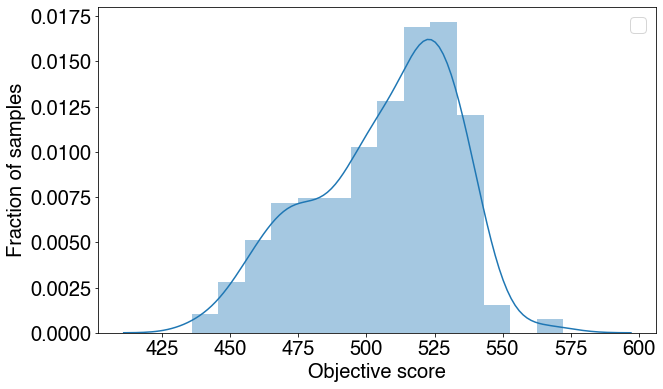

In [539]:
# Plot distribution of objectives
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(scores, norm_hist = True)
ax.set(xlabel= 'Objective score', ylabel = 'Fraction of samples')
# plt.plot([0,0],[0,0.0023], linestyle = '--', color = 'r')
plt.legend()
plt.show()

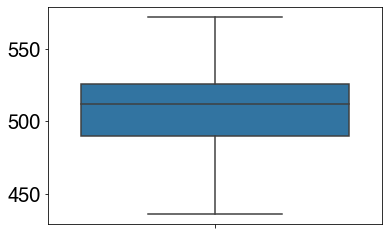

In [542]:
# Boxplot of objective values
plt.figure()
sns.boxplot(scores, orient = 'v')
plt.show()

## Plot g1 and g2 trajectories

In [534]:
# SAVING g1_pool and g2_pool - JSON WORKS BUT NOT PICKLE BCOS NESTED LIST
import json
# # open output file for writing
# with open('./Data/CS2_g1_pool_g1g2_960_ep', 'w') as f:
#     json.dump(g1_pool, f)
# with open('./Data/CS2_g2_pool_g1g2_960_ep', 'w') as f:
#     json.dump(g2_pool, f)
# open output file for reading
# with open('./Data/CS2_g1_pool_g1g2_960_ep', 'r') as f:
#     g1_pool = json.load(f)
# with open('./Data/CS2_g2_pool_g1g2_960_ep', 'r') as f:
#     g2_pool = json.load(f)

In [530]:
g1_pool = [] # List of lists of g1 trajectories
g2_pool = []

t_list = np.arange(0,4.4,0.4) # Define time

for i in range(400):
#     initialize_MDP_BioEnv() # Initialize system
    try:
        episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
    except KeyboardInterrupt:
        try:
            episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
        except KeyboardInterrupt:
            try:
                episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
            except KeyboardInterrupt:
                try:
                    episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
                except KeyboardInterrupt:
                    episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
    g1_list = extract_constraint_values_from_episode_NO_ORACLE(episode, T_limit = 420, Vol_limit = 800)[1]
    g2_list = extract_constraint_values_from_episode_NO_ORACLE(episode, T_limit = 420, Vol_limit = 800)[2]
    g1_pool += [list(g1_list)]
    g2_pool += [list(g2_list)]

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

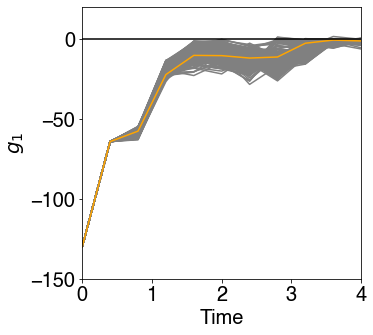

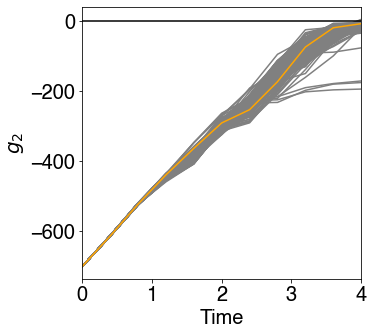

In [535]:
# Plot g1 trajectory
plt.figure(figsize = (5, 5))
for g1_list in g1_pool:
    plt.plot(t_list, g1_list, color = 'grey')
g1_pool = np.array(g1_pool)
g1_average  = g1_pool.mean(axis = 0) # Take average of trajectory
plt.plot(t_list, g1_list, color = 'orange')
plt.plot([-100,2500], [0,0], color = 'black')
plt.xlabel('Time')
plt.ylabel('$g_1$')
plt.ylim(-150, 20)
plt.xlim(0,4)
plt.show()

# Plot g2 trajectory
plt.figure(figsize = (5, 5))
for g2_list in g2_pool:
    plt.plot(t_list, g2_list, color = 'grey')
g2_pool = np.array(g2_pool)
g2_average  = g2_pool.mean(axis = 0) # Take average of trajectory
plt.plot(t_list, g2_list, color = 'orange')
plt.plot([-100,2500], [0,0], color = 'black')
plt.xlabel('Time')
plt.ylabel('$g_2$')
# plt.ylim(-0.04,0.005)
plt.xlim(0,4)
plt.show()

## Plot distribution of g values

In [517]:
# # Save data
# with open('./Data/CS2_max_g1_g1g2_960_ep', 'wb') as f:
#     pickle.dump(max_g1_list, f, pickle.HIGHEST_PROTOCOL)
# with open('./Data/CS2_max_g2_g1g2_960_ep', 'wb') as f:
#     pickle.dump(max_g2_list, f, pickle.HIGHEST_PROTOCOL)
    
# # Load pre-run data
# with open('./Data/CS2_max_g1_g1g2_960_ep', 'rb') as f:
#     max_g1_list = pickle.load(f)
# with open('./Data/CS2_max_g2_g1g2_960_ep', 'rb') as f:
#     max_g2_list = pickle.load(f)

In [512]:
max_g1_list = []
max_g2_list = []
for i in range(400):
#     initialize_MDP_BioEnv()
    try:
        episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
    except KeyboardInterrupt:
        try:
            episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
        except KeyboardInterrupt:
            try:
                episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
            except KeyboardInterrupt:
                try:
                    episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b) # Generate 1 episode
                except KeyboardInterrupt:
                    episode = generate_episode_with_NN(GA_optimize_constrained, [0., 0., 0., 290., 100., 0], 
                                   epsilon = 0, 
                                   g1_threshold = a,
                                   g2_threshold = b)
    # WORST violation of this episode
    max_g1 = max(extract_constraint_values_from_episode(episode, T_limit = 420, Vol_limit = 800)[1])[0]
    max_g2 = max(extract_constraint_values_from_episode(episode, T_limit = 420, Vol_limit = 800)[2])[0]

    max_g1_list += [max_g1]
    max_g2_list += [max_g2]

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@generate_episode_with_NN TOOK TOO LONG @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@

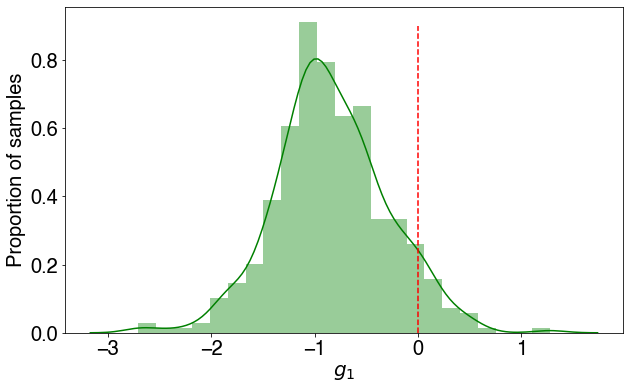

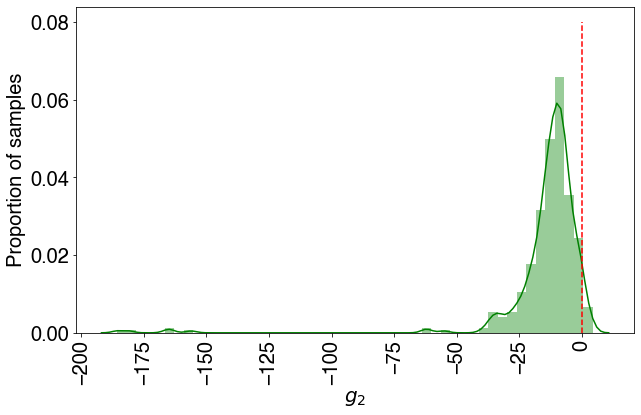

In [518]:
# Plot distribution of g1
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(max_g1_list, norm_hist = True, color = 'green')
ax.set(xlabel= '$g_1$', ylabel = 'Proportion of samples')
plt.plot([0,0],[0,0.9], linestyle = '--', color = 'r')
# plt.xlim(-1000,1000)
plt.show()

# Plot distribution of g2
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.distplot(max_g2_list, norm_hist = True, color = 'green')
ax.set(xlabel= '$g_2$', ylabel = 'Proportion of samples')
plt.plot([0,0],[0,0.08], linestyle = '--', color = 'r')
plt.xticks(rotation=90)
# plt.xlim(-0.055,0.022)
plt.show()